<span style="color:red">Read me:
This is a Capstone In Partial Fulfillment of the Requirements for the Degree of Master of Science in Computational Finance - De La Salle University | Financial Machine Learning program. 12/14/2023.
I would like to thank sir Francis, Megaworld Corp. for the mentorship and dedication in teaching Programming, DS, and AIML

The original dataset includes 150 features which has been reduced to 21 by using domain knowledge and forward selection (Moro et al., 2014). Hence the data we are working has 21 preprocessed features. The goal of this capstone is to further maximize true positive and accuracy by feature selection, preprocessing, and modeling methods.

Two methods are performed (Part 1 and Part 2), each with varying preprocessing techniques and modeling. The best model is then provided in the last cell. Both Parts are Mutually Exclusive to each other.

---

Notes:
1. Please do not run all as it will take time & time consuming outputs will be overwritten.
2. If you plan to run, run the notebook in Google colab runtime env.
3. After part 1: Restart session, run first 2 cells then run part 2 section only. (still debugging to run all)
4. Neural Net (NN) epochs is set to 100. Set to 3-12 for less time or you may just view the stored output.
5. Binary type cast conversion via .astype() is unreliable, use diff syntax
6. Workflow and thought process is found in Part 3; specific code logic is commented on cell itself.</span>


In [ ]:
! pip install sweetviz
! pip install missingno
import sweetviz as sv # Data viz
import pandas as pd # DataFrame
import numpy as np # Numerical Computation
import matplotlib.pyplot as plt # Data viz
import seaborn as sns # Data viz
import zipfile # Unzip
import io # Supports web requests
import requests # Get URL
import missingno as msno # Missing Data
from sklearn.preprocessing import StandardScaler # Scaling
from sklearn.cluster import KMeans # ML Model
from sklearn.linear_model import LogisticRegression # ML Model
from sklearn.tree import DecisionTreeClassifier, plot_tree # ML Model
from sklearn.neighbors import KNeighborsClassifier #ML Model
from sklearn.naive_bayes import GaussianNB # ML Model
from sklearn.svm import SVC # ML Model
import tensorflow as tf # NN Model
from imblearn.over_sampling import RandomOverSampler # Imbalanced Data
from sklearn.model_selection import train_test_split # Split
from sklearn.ensemble import RandomForestClassifier # ML Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Metrics

# Source and citation, import, unzip dataset, declare pd dataframe, list of variables
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip'
response = requests.get(url)
if response.status_code == 200:
  with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
    csv_file = 'bank-additional/bank-additional-full.csv'
    df = pd.read_csv(zip_file.open(csv_file), sep=';')
    data_dict_file = 'bank-additional/bank-additional-names.txt'
    with zip_file.open(data_dict_file) as data_dict_f:
      data_dict_lines = data_dict_f.readlines()
    for line in data_dict_lines:
      print(line.decode('utf-8').strip())
else:
  print('Failed. Status code:', response.status_code)
%matplotlib inline

﻿Citation Request:
This dataset is publicly available for research. The details are described in [Moro et al., 2014].
Please include this citation if you plan to use this database:

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, In press, http://dx.doi.org/10.1016/j.dss.2014.03.001

Available at: [pdf] http://dx.doi.org/10.1016/j.dss.2014.03.001
[bib] http://www3.dsi.uminho.pt/pcortez/bib/2014-dss.txt

1. Title: Bank Marketing (with social/economic context)

2. Sources
Created by: Sérgio Moro (ISCTE-IUL), Paulo Cortez (Univ. Minho) and Paulo Rita (ISCTE-IUL) @ 2014

3. Past Usage:

The full dataset (bank-additional-full.csv) was described and analyzed in:

S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems (2014), doi:10.1016/j.dss.2014.03.001.

4. Relevant Information:

This dataset is based on "Bank Marketing" U

---
# Exploratory Data Analysis

In [ ]:
# Backup copy, specifically to segment df preprocessing as we have two df
df_copy = df.copy(deep = True) # DF exclusive for our first methodology
df1 = df_copy # DF exclusive for our probability plotting in EDA
df2 = df_copy # DF exclusive for our second methodology

In [ ]:
# HTML analysis on DataFrame, relevant for feature selection and preprocessing
'''
my_report = sv.analyze(df)
my_report.show_html()
'''
# Check colab file tab on top left bottom portion for the html file

'\nmy_report = sv.analyze(df)\nmy_report.show_html()\n'

In [ ]:
# We must first note that the data is imbalanced and skewed | out of 41187 rows only 4640 took out a term deposit, a 12% conversion rate
# The model has not seen enough 1's to make a good prediction on new data

show_imbalance = df['y'].value_counts()
show_imbalance = show_imbalance.to_string(index = False, dtype = False)
imbalance_percentage = (1-(4640/len(df.y)))
print(f'{show_imbalance}\nY Column No/Yes percentage: {imbalance_percentage}')

36548
 4640
Y Column No/Yes percentage: 0.8873458288821987


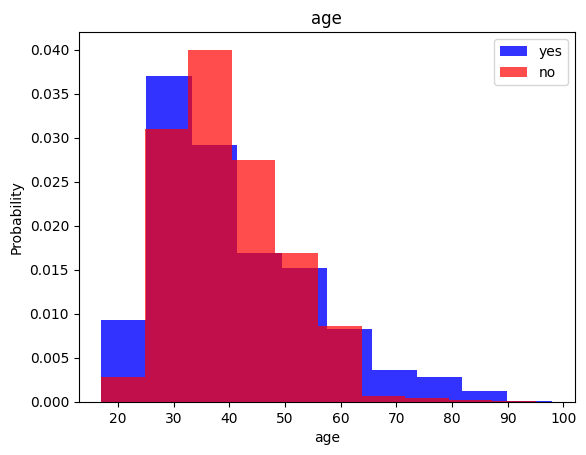

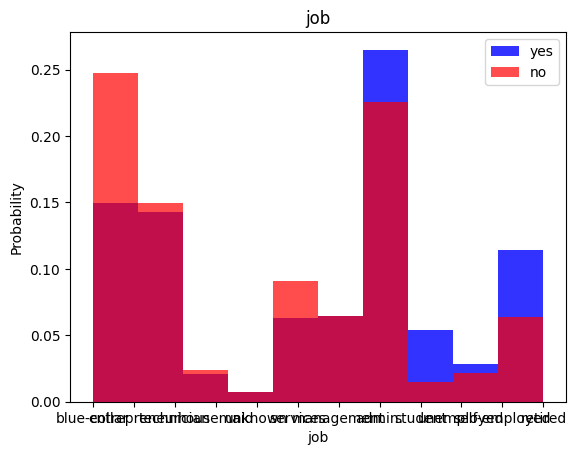

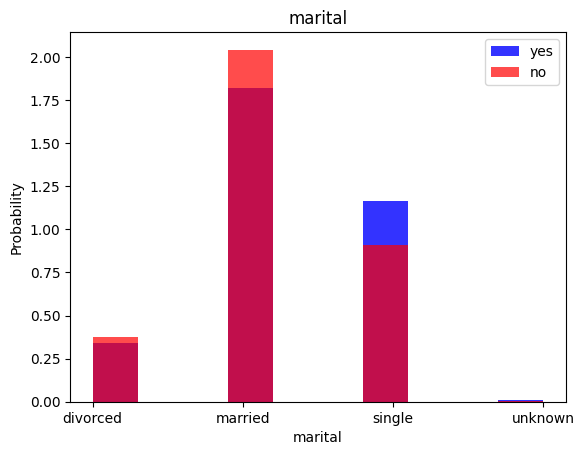

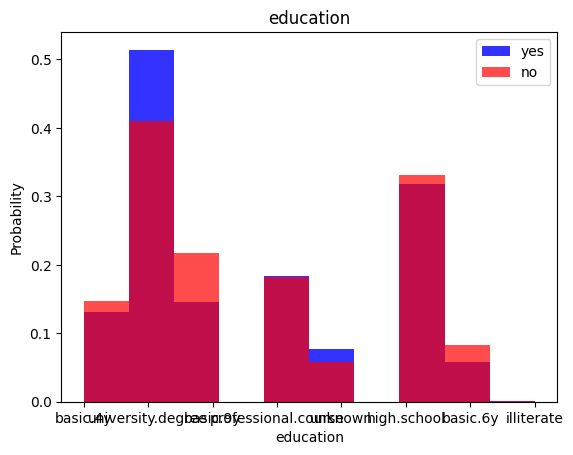

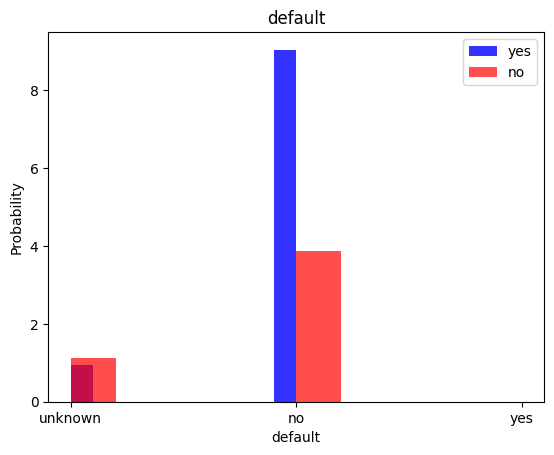

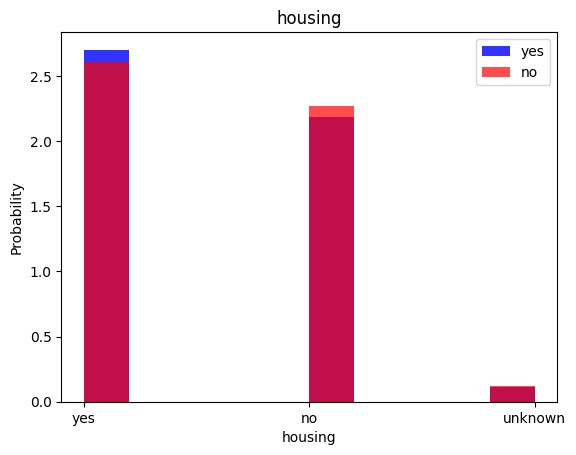

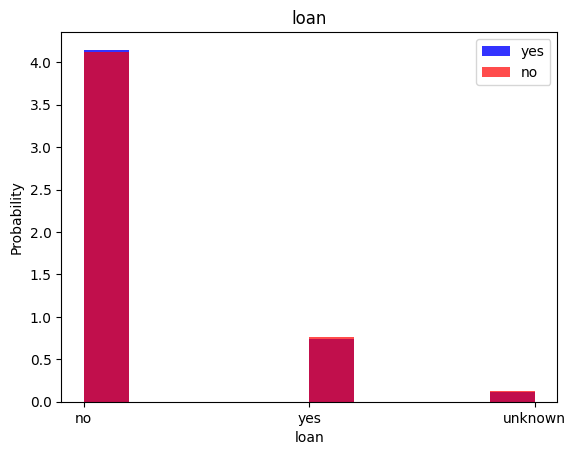

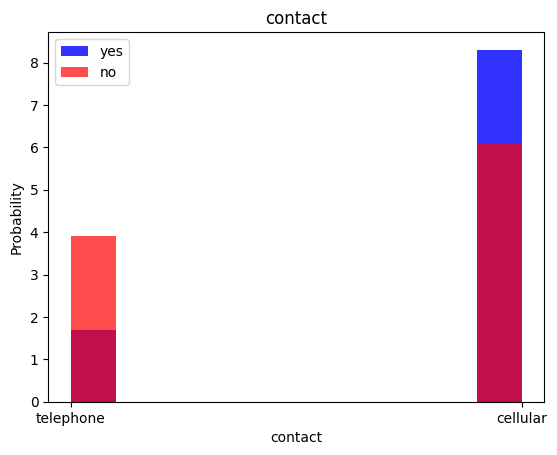

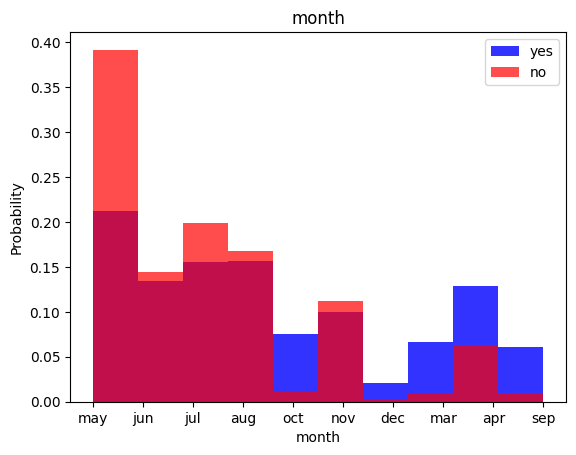

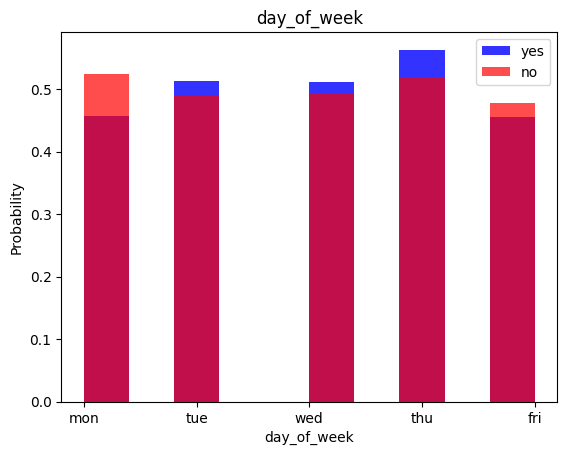

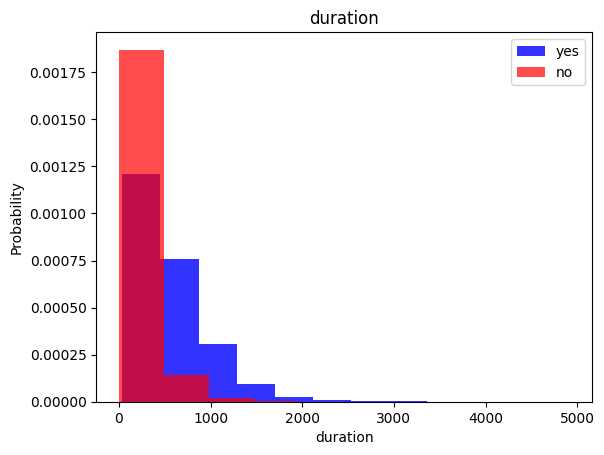

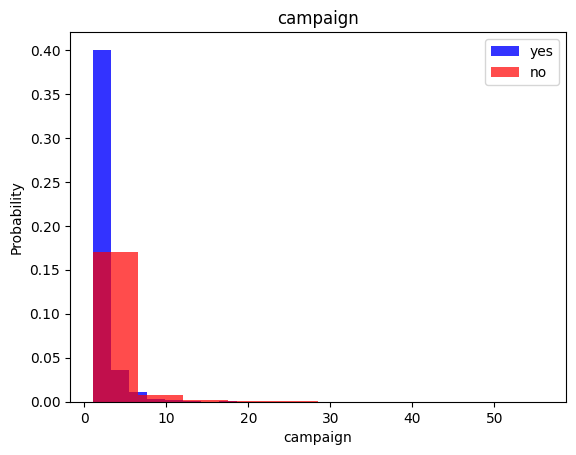

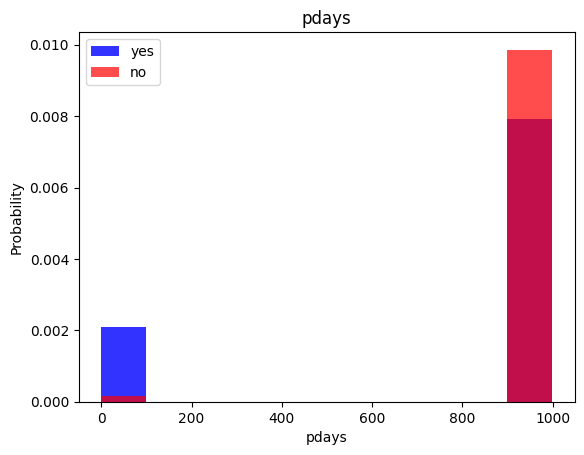

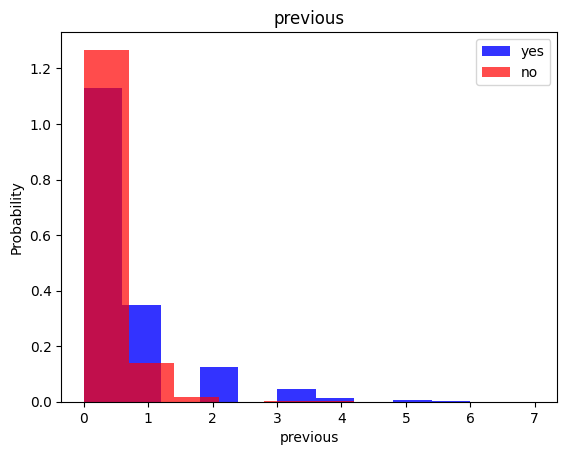

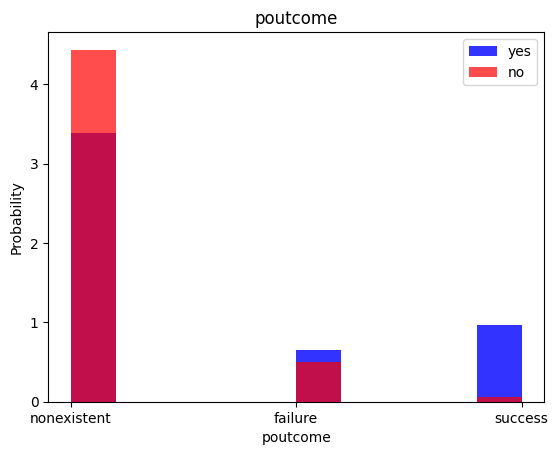

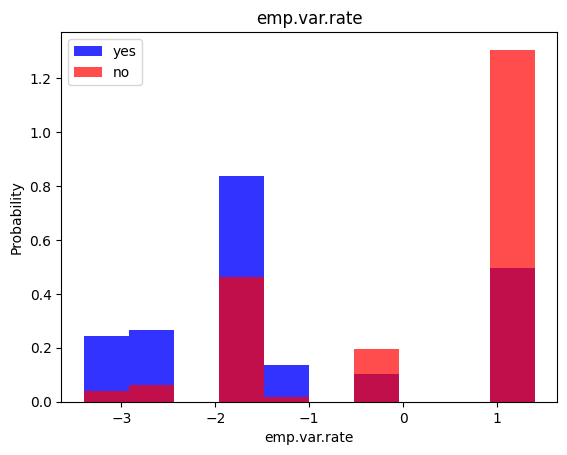

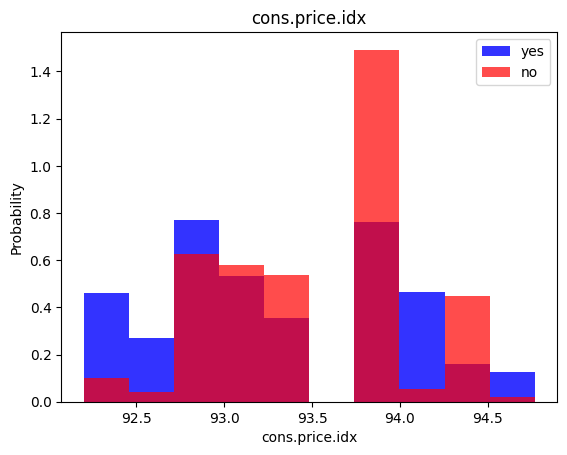

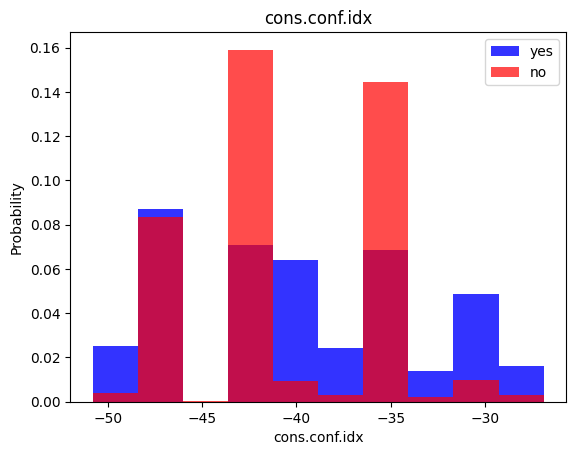

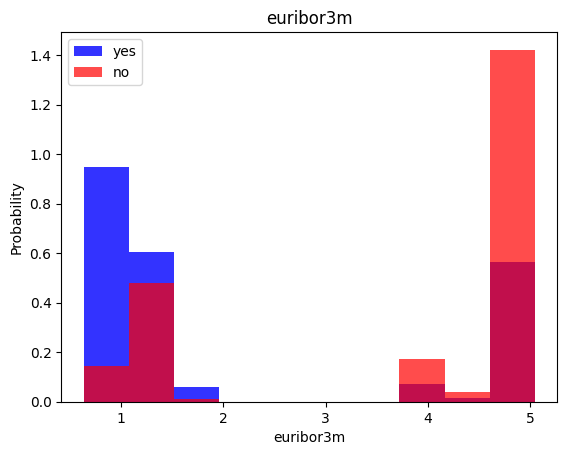

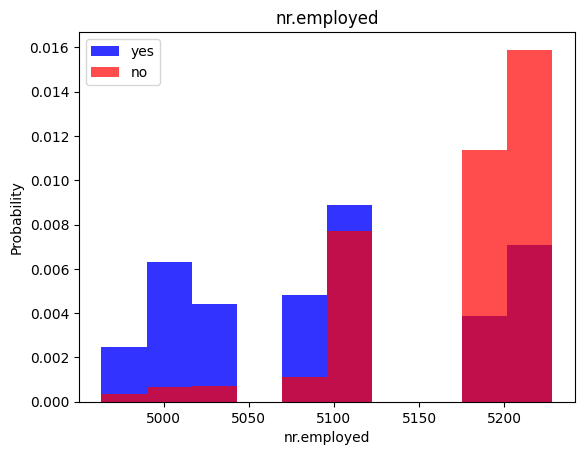

In [ ]:
# Plotting the probability density for each column with regards to the binary variable
# Blue color density is increased to 0.8 alpha to enhance visibility as there more reds (imbalanced data)
# Density = True means to balance the probability distribution to deal with outliers

df1['y'] = (df1['y'] == 'yes').astype(int) #binary conversion take note this is not the df we would use in preprocessing

for label in df1.columns[:-1]:
  plt.hist(df1[df1["y"]==1][label], color='blue', label='yes', alpha=0.8, density=True)
  plt.hist(df1[df1["y"]==0][label], color='red', label='no', alpha=0.7, density=True)
  plt.title(label)
  plt.ylabel("Probability")
  plt.xlabel(label)
  plt.legend()
  plt.show()

---
# Part 1: First Methodology

---
## Preprocessing

In [ ]:
# Drop duration; Only used as benchmark, highly affects output unrealistically, refer to attribute information on [duration]
df = df.drop('duration', axis = 'columns')
df.columns.tolist()

['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'y']

In [ ]:
# Dropping Duplicates: retain first duplicate instance
df = df.drop_duplicates(keep='first')

<function matplotlib.pyplot.show(close=None, block=None)>

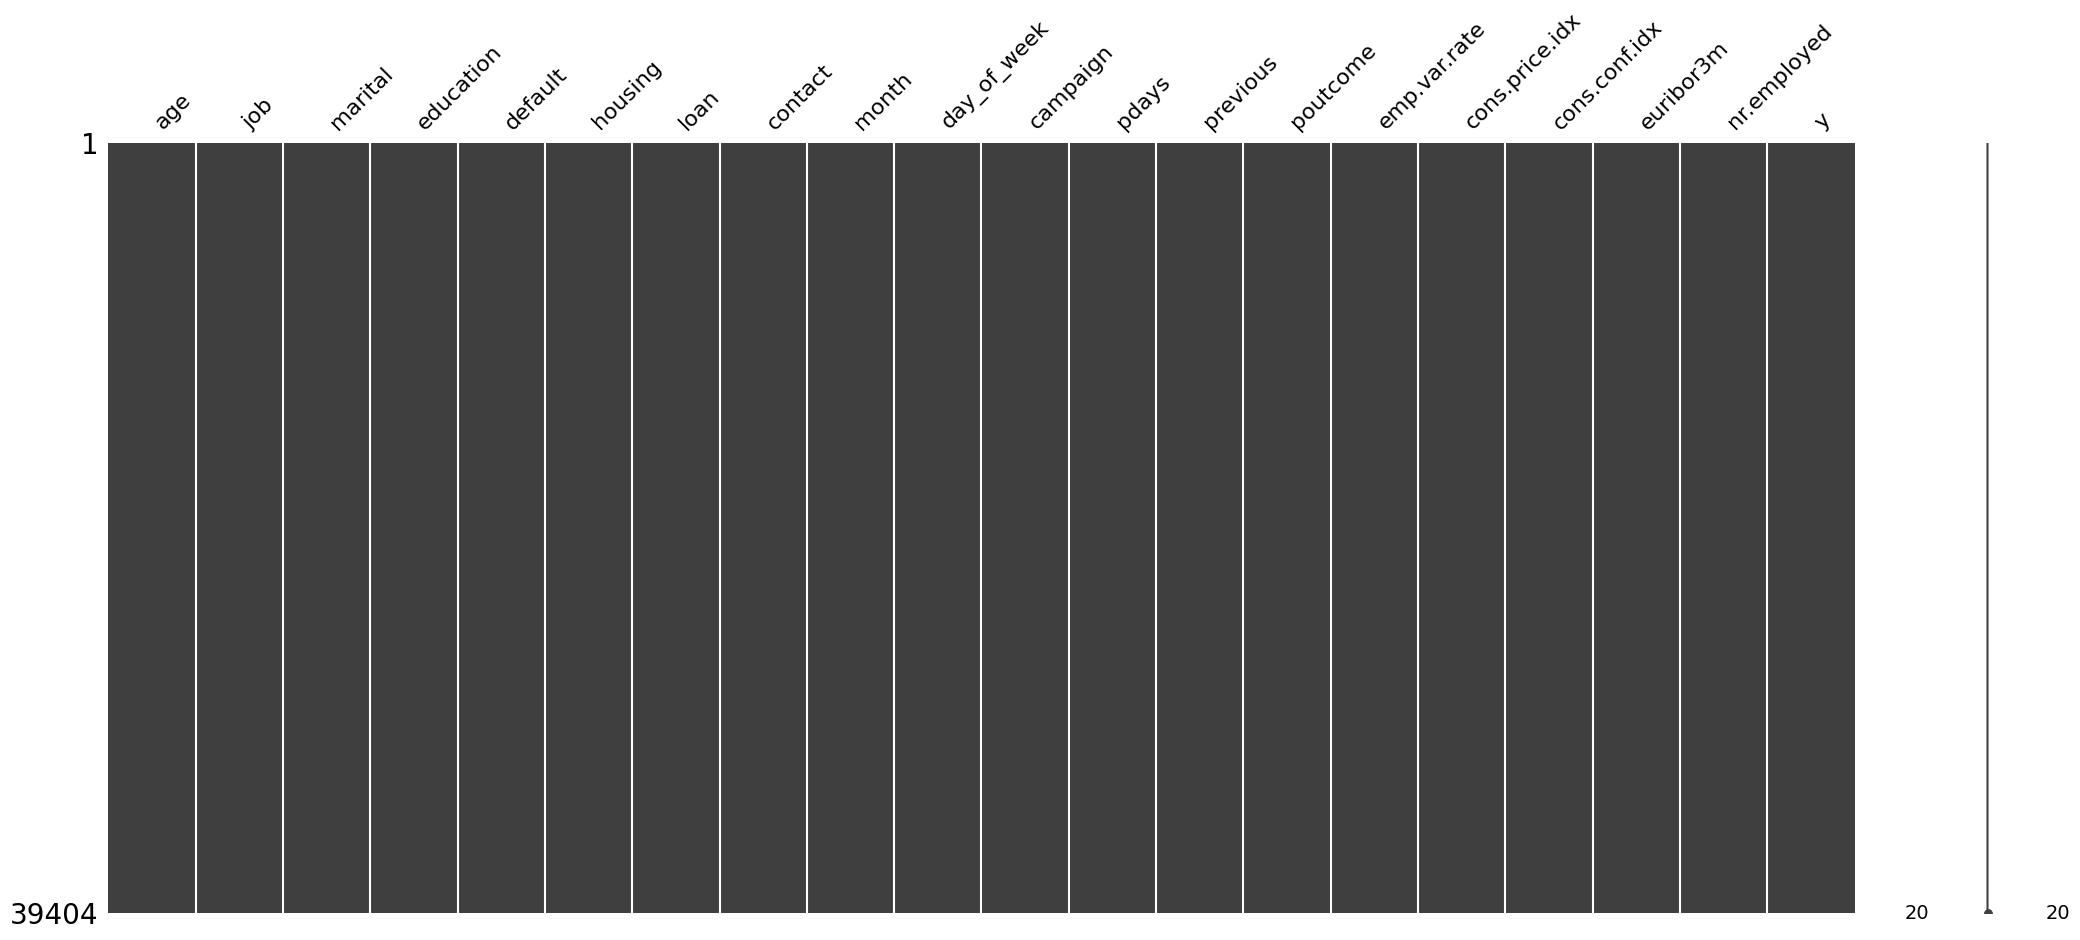

In [ ]:
# No missing data. Else, <> df.fillna(df['y'].mode()[0]) <> is an easy method to use as it addresses both categorical and floating classess in a single line, although it is not the best option
#df = df.fillna(df['y'].mode()[0])
msno.matrix(df)
plt.show

In [ ]:
# pdays contains ordinal data which means it is categorical data; therefore it is converted into a categorical dtype
# since pdays is categorical we would not need to remediate 999 as an outlier | 999 == not previously contacted
pdays_unique = df['pdays'].unique()
print(pdays_unique)
df['pdays'] = df['pdays'].astype('category')

[999   6   4   3   5   1   0  10   7   8   9  11   2  12  13  14  15  16
  21  17  18  22  25  26  19  27  20]


In [ ]:
# Further categorical conversion, date is an ordinal data ['month', 'day_of_week']

df['month'] = df['month'].astype('category')
df['day_of_week'] = df['day_of_week'].astype('category')


In [ ]:
# converting [y] into binary, no == 0, yes == 1
df['y'] = (df['y'] == 'yes').astype(int)
df['y']

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, Length: 39404, dtype: int64

In [ ]:
df['y'].unique() # Checking if .astype() error has not occured. Confirmed there are unique 1 values in the df

In [ ]:
# One hot encoding
# Listing Categorical columns
# Listing Number of Columns vs Old number of columns

categorical_columns = df.select_dtypes(include=['object', 'category'])
categorical_columns = categorical_columns.columns.tolist()
print('Categorical Columns:', categorical_columns)

#  converts categorical variables into dummy variables Each category in the original column gets its own dummy column with binary values. We are now working with 88 purely numerical columns
df_encoded = pd.get_dummies(df)
print('-> With dummies:', len(df_encoded.columns), 'columns vs','without dummies: ', len(df.columns), 'columns')

# The logic for not dropping any variables is that the dataset has already been feature selected by the previous researchers, therefore all 20 variables have a significance to them [Moro et al., 2014].
df = df_encoded
df.head()

Categorical Columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'pdays', 'poutcome']
-> With dummies: 89 columns vs without dummies:  20 columns


age  campaign  previous  emp.var.rate  cons.price.idx  cons.conf.idx  \
0   56         1         0           1.1          93.994          -36.4   
1   57         1         0           1.1          93.994          -36.4   
2   37         1         0           1.1          93.994          -36.4   
3   40         1         0           1.1          93.994          -36.4   
4   56         1         0           1.1          93.994          -36.4   

   euribor3m  nr.employed  y  job_admin.  ...  pdays_20  pdays_21  pdays_22  \
0      4.857       5191.0  0           0  ...         0         0         0   
1      4.857       5191.0  0           0  ...         0         0         0   
2      4.857       5191.0  0           0  ...         0         0         0   
3      4.857       5191.0  0           1  ...         0         0         0   
4      4.857       5191.0  0           0  ...         0         0         0   

   pdays_25  pdays_26  pdays_27  pdays_999  poutcome_failure  \
0         0         0         0          1                 0   
1         0         0         0          1                 0   
2         0         0         0          1                 0   
3         0         0         0          1                 0   
4         0         0         0          1                 0   

   poutcome_nonexistent  poutcome_success  
0                     1                 0  
1                     1                 0  
2                     1                 0  
3                     1                 0  
4                     1                 0  

[5 rows x 89 columns]

In [ ]:
# Bring target var into the last column
# Note that our target column ['y] position has shifted in the middle of our dataframe during categorical conversion (see df above this cell)
# This code returns it to the proper position in the last column
# Important note: without this code the model is overfitted. managed to fix the overfitting (0.999 accuracy) in the last iteration sent over email (capstoneRG2.ipynb) using this simple debug method.
df['y'] = df.pop('y')
df = pd.concat([df.iloc[:, :-1], df.iloc[:, -1]], axis=1)
df

age  campaign  previous  emp.var.rate  cons.price.idx  cons.conf.idx  \
0       56         1         0           1.1          93.994          -36.4   
1       57         1         0           1.1          93.994          -36.4   
2       37         1         0           1.1          93.994          -36.4   
3       40         1         0           1.1          93.994          -36.4   
4       56         1         0           1.1          93.994          -36.4   
...    ...       ...       ...           ...             ...            ...   
41183   73         1         0          -1.1          94.767          -50.8   
41184   46         1         0          -1.1          94.767          -50.8   
41185   56         2         0          -1.1          94.767          -50.8   
41186   44         1         0          -1.1          94.767          -50.8   
41187   74         3         1          -1.1          94.767          -50.8   

       euribor3m  nr.employed  job_admin.  job_blue-collar  ...  pdays_21  \
0          4.857       5191.0           0                0  ...         0   
1          4.857       5191.0           0                0  ...         0   
2          4.857       5191.0           0                0  ...         0   
3          4.857       5191.0           1                0  ...         0   
4          4.857       5191.0           0                0  ...         0   
...          ...          ...         ...              ...  ...       ...   
41183      1.028       4963.6           0                0  ...         0   
41184      1.028       4963.6           0                1  ...         0   
41185      1.028       4963.6           0                0  ...         0   
41186      1.028       4963.6           0                0  ...         0   
41187      1.028       4963.6           0                0  ...         0   

       pdays_22  pdays_25  pdays_26  pdays_27  pdays_999  poutcome_failure  \
0             0         0         0         0          1                 0   
1             0         0         0         0          1                 0   
2             0         0         0         0          1                 0   
3             0         0         0         0          1                 0   
4             0         0         0         0          1                 0   
...         ...       ...       ...       ...        ...               ...   
41183         0         0         0         0          1                 0   
41184         0         0         0         0          1                 0   
41185         0         0         0         0          1                 0   
41186         0         0         0         0          1                 0   
41187         0         0         0         0          1                 1   

       poutcome_nonexistent  poutcome_success  y  
0                         1                 0  0  
1                         1                 0  0  
2                         1                 0  0  
3                         1                 0  0  
4                         1                 0  0  
...                     ...               ... ..  
41183                     1                 0  1  
41184                     1                 0  0  
41185                     1                 0  0  
41186                     1                 0  1  
41187                     0                 0  0  

[39404 rows x 89 columns]

In [ ]:
# Further preprocessing: Train, valid, test, random sampling, standard scaling, randomoversampler (imbalanced data), and put back together using reshape

#split data set into train, valid, test; 60:20:20, respectively
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))]) # df.sample(frac=1) randomly sample a fraction of rows from the DataFrame.

# Why do we need a validation set -
# Training set: A set of examples used for learning, that is to fit the parameters of the classifier.
# Validation set: A set of examples used to tune the parameters of a classifier, for example to choose the number of hidden units in a neural network.
# Test set: A set of examples used only to assess the performance of a fully-specified classifier. (Ripley, 1996)


# Simply, the validation set is mostly used for tuning the hyperparameters
# More simply, the validation set is a kind of reality check during/after training the model, once final model is chosen we apply the test set

In [ ]:
# Notes:
# Vectors is basically a one-dimensional array. While arrays, on the other hand, can have multiple dimensions 1d, 2d, 3d. 3d arrays is simply a matrix (rows x columts) with layers.
# Tensors in machine learning is multi-dimensional can take the form of all the dimensions of the array are are more generalized, flexible as compared to a fixed 2d (matrix) or 3d array. Eg TensorFlow


# First we need to extract X and y var from our df
def scale_dataset(dataframe, oversample=False):
    X = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values

# Another way for slicing
# X = dataset.iloc[:, :-1].values #selects all the columns except last one
# y = dataset.iloc[:, -1].values #selects last column

# Feature Scaling on X
# Log transformation and other scalers did not have any impact on the metrics tests and results hence standard scaler is used as a base scaling technique
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

# RandomOverSampler from the imbalanced-learn library to oversample the minority class, making the class distribution more balanced
    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

# Concatenation ensures X and y fits after scaling and oversampling
    data = np.hstack((X, np.reshape(y, (-1, 1)))) # horizontally stacks an array X and the reshaped array y (converted to a column vector) using np hstack function


    return data, X, y

In [ ]:
train, X_train, y_train = scale_dataset(train, oversample=True) # Oversample our train
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

---
## Modeling and metrics

---
### Knn

In [ ]:
# Initializing classes
# To connect the model object (regressor) to our training dataset we use the .fit method, the fit method is a method of the linear regression class. This is a standard process in all AI/ML Models
# A class like (LinearRegression) not only has instructions but also tools that are called methods which complete some actions like training a certain set or predicting some future results on the test set
# Example: knn_model.fit(X_train, y_train) #the fit method will train the k nearest neighbor model on the training set, so you enter the training set itself on the parenthesis.It expects a certain format which is the couple X_train and y_train


In [ ]:
#Knn class initialization
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
# knn_model.predict(testset)

# We input X_test to output the predicted y variable by the trained lr_model
# We store it in y_pred and compare that to y_test (actual)

y_pred = knn_model.predict(X_test)
print(classification_report(y_test, y_pred)) #comparing the predicted y (trained values) to the y test (actual values)

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      6987
           1       0.29      0.31      0.30       894

    accuracy                           0.84      7881
   macro avg       0.60      0.61      0.60      7881
weighted avg       0.84      0.84      0.84      7881



---
### Naive bayes

In [ ]:
# Naive Bayes model is unpredictable and arbitrarily returns 12%-90% accuracy score and 1 or 0 is sometimes undefined. In this case 1 is undefined on both precision and recall (see classification report)
# Identified issue: Division by zero was not remediated
# Naive Bayes model relies on probability and/or uses a probability equation within the algorithm and is therefore inherently stochastic in nature. Simply results are not consistent.

nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train)

In [ ]:
y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6987
           1       0.00      0.00      0.00       894

    accuracy                           0.89      7881
   macro avg       0.44      0.50      0.47      7881
weighted avg       0.79      0.89      0.83      7881



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---
### Logistic Regression

In [ ]:
lg_model = LogisticRegression()
lg_model = lg_model.fit(X_train, y_train)

In [ ]:
y_pred = lg_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89      6935
           1       0.36      0.63      0.46       946

    accuracy                           0.82      7881
   macro avg       0.65      0.74      0.68      7881
weighted avg       0.87      0.82      0.84      7881



---
### Support Vector Machine

In [ ]:
# Best model for Part 1

svm_model = SVC()
svm_model = svm_model.fit(X_train, y_train)

In [ ]:
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      6935
           1       0.40      0.61      0.48       946

    accuracy                           0.84      7881
   macro avg       0.67      0.74      0.70      7881
weighted avg       0.88      0.84      0.86      7881



---
### Neural Net


In [ ]:
'''
Model info: TensorFlow with keras API to implement a Deep Feedforwrad neural network

---
Feedforward Neural Network (FNN):
The Keras Sequential model with dense layers is an example of a Feedforward Neural Network. In a Feedforward network, information moves in one direction, from the input layer to the output layer.
Dense layers, aka fully connected layers, connect each neuron in one layer to every neuron in the next layer, allowing for complex mappings between inputs and outputs.

---
Activation Function (Hidden Layer): ReLu - ReLU is effective in converting linear combinations of inputs into non-linear outputs, which can help to capture more complex relationships.
Activation function (Output Layer): Sigmoid (logistic function) converts into binary (classification)

---
Loss function: Binary Cross-entropy loss (specifically used in classification)

---

Optimizer: Adam (Stochastic Gradient Descent)

Adam initializes two moving average variables: Both are initialized to zero vectors.
Compute Gradients. Adam optimizer employs a hybrid of two gradient descent methods.
In each iteration of training, the model's parameters are updated based on the gradients of the loss function with respect to those parameters. Computed using backpropagation.
Weights are updated using exponential decay. The updates are calculated using the gradients from the current iteration.

Summary: Adam combines the advantages of two other popular optimization algorithms: RMSprop (root mean square propagation) and momentum optimization for maintaining moving averages of the gradients.



Why do we need optimizers in Machine Learning?

Any deep learning model uses an algorithm to generalize the data and make predictions on previously unseen data.
We require an algorithm that maps input examples to output examples and an optimization algorithm.
When mapping inputs to outputs, an optimization algorithm determines the value of the parameters (weights) that minimize the error.
These optimization algorithms or optimizers have a significant impact on the deep learning model's accuracy and runtime.

---
Other info:

Optimizer: is a function or algorithm that modifies the neural network's attributes, such as weights and learning rate. helps to reduce overall loss and improve accuracy.
Choosing the right weights for the model is difficult because a deep-learning model typically has millions of parameters.
The optimizer's role is to update the model's weights iteratively during training based on the gradient of the loss function with respect to the parameters.
While optimizers like Adam in machine learning adjust model parameters during training to minimize the loss function, they don't directly optimize hyperparameters.
Hyperparameters, such as the one listed below (epoch, num nodes, dropout, lr, batch), are set by the user and often require manual tuning or optimization techniques.
We have set the hyperparameters below as a list [] for the optimizer to choose from.

Where:

Epoch: The number of times the algorithm runs through the entire training dataset.
Dropout prob: disregarding certain nodes in a layer at random during training. prevents overfitting by ensuring that no units are codependent with one another
Batch: This is the number of samples that will be used to update the model parameters. Sample: A sample is one row from a dataset.
Learning Rate: The learning rate is a parameter that tells the model how frequently the model weights should be updated.
Loss Function: It is used to calculate the cost, which is the difference between the predicted and actual value.
Weights: control the signal (strength of the connection) between two neurons. Weights decides how much influence the input will have on the output.
Bias: which are constant, is an additional input into the next layer that will always have the value of 1.

'''

In [ ]:
# Neural Net plotting initialization

# data visualization function for easier hyperparameter tuning | source: TensorFlow

# Plotting the loss and accuracy against epochs

def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary crossentropy')
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid(True)

  plt.show()


In [ ]:
# Main NN model function, compiler, and history

# Binary cross-entropy loss is used as our loss function, it is used mainly on binary data or classification

# Sigmoid is used on the last layer so we can restrict our output to binary (1 or 0) it is a logistic function | 88 is our df.shape

def train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
  nn_model = tf.keras.Sequential([
      tf.keras.layers.Dense(num_nodes, activation = 'relu', input_shape = (88,)),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(num_nodes, activation = 'relu'),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(1, activation = 'sigmoid')
  ])

# Compile since it is a Neural network | Adam (Adaptive Moment Estimation) is an optimization algorithm which uses a combination of Gradients, EMA, and RMS
  nn_model.compile(optimizer = tf.keras.optimizers.Adam(lr), loss = 'binary_crossentropy',
                  metrics = ['accuracy'])

# Keeps track of the history which is then passed into the plot_history function to produce a graph of the loss and accuracy per epoch
  history = nn_model.fit(
      X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose = 0
  )

  return nn_model, history


16 nodes, dropout 0, lr 0.01, batch size 32


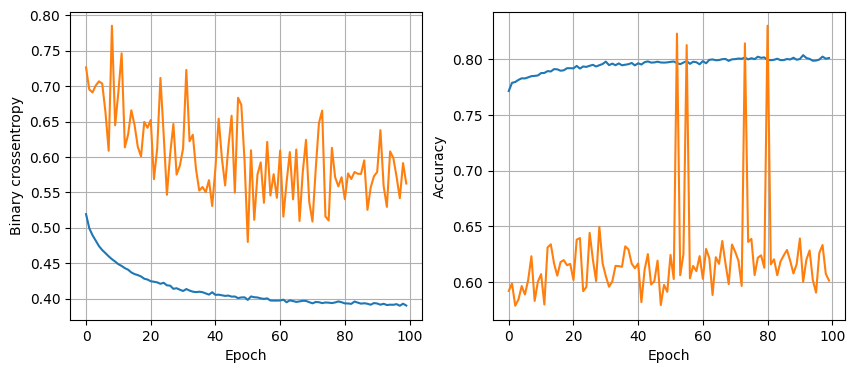

247/247 [==============================] - 2s 6ms/step - loss: 0.5375 - accuracy: 0.8480
16 nodes, dropout 0, lr 0.01, batch size 64


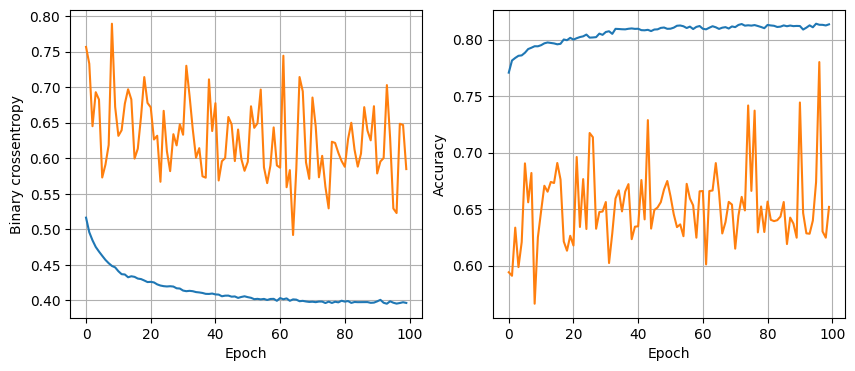

247/247 [==============================] - 3s 12ms/step - loss: 0.4907 - accuracy: 0.8413
16 nodes, dropout 0, lr 0.01, batch size 128


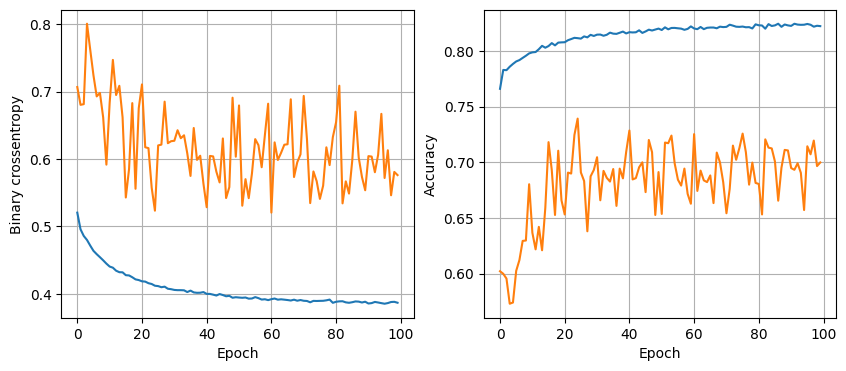

247/247 [==============================] - 4s 17ms/step - loss: 0.4999 - accuracy: 0.8255
16 nodes, dropout 0, lr 0.005, batch size 32


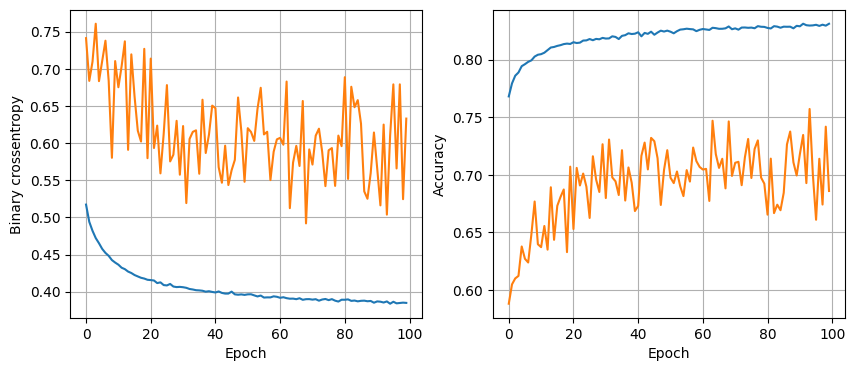

247/247 [==============================] - 5s 20ms/step - loss: 0.4306 - accuracy: 0.8381
16 nodes, dropout 0, lr 0.005, batch size 64


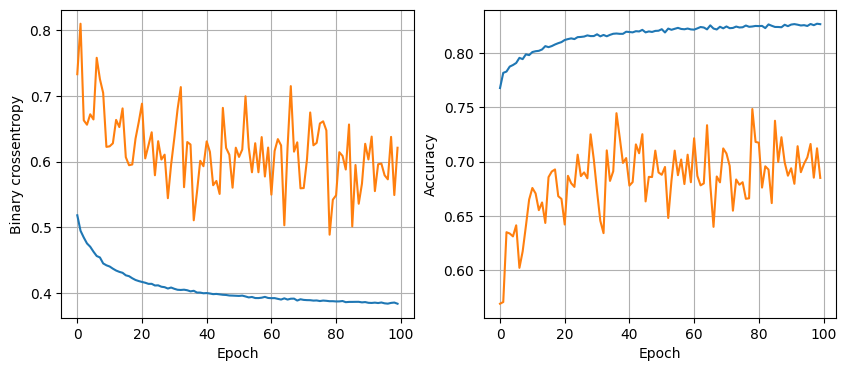

247/247 [==============================] - 0s 2ms/step - loss: 0.4699 - accuracy: 0.8353
16 nodes, dropout 0, lr 0.005, batch size 128


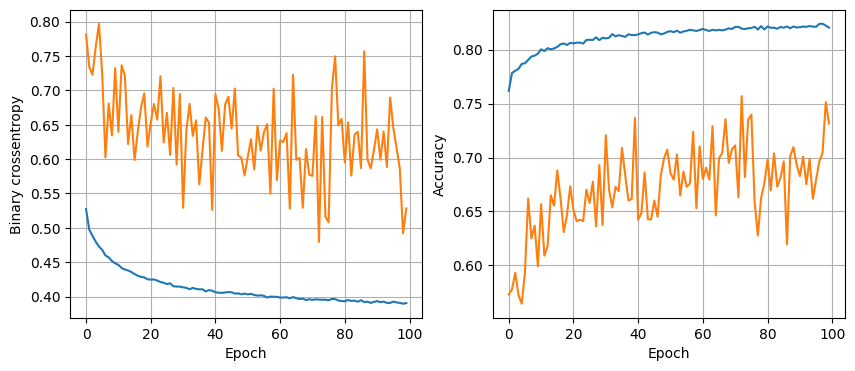

247/247 [==============================] - 0s 2ms/step - loss: 0.4882 - accuracy: 0.8076
16 nodes, dropout 0, lr 0.001, batch size 32


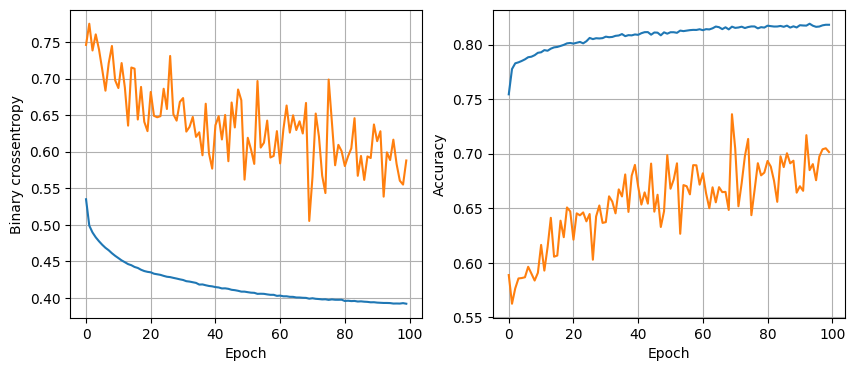

247/247 [==============================] - 1s 2ms/step - loss: 0.4580 - accuracy: 0.8213
16 nodes, dropout 0, lr 0.001, batch size 64


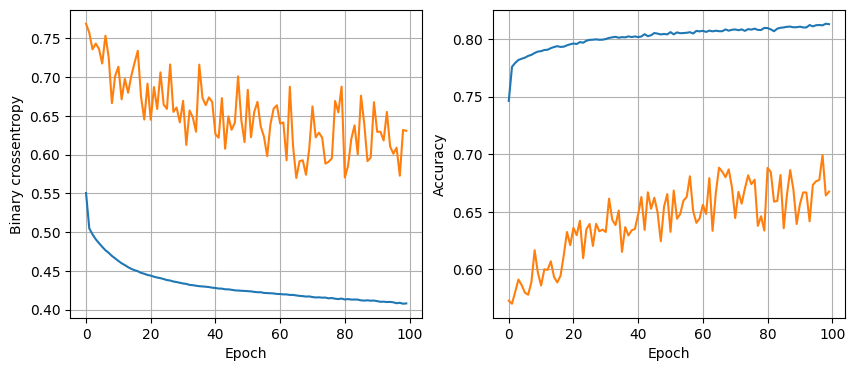

247/247 [==============================] - 3s 13ms/step - loss: 0.4450 - accuracy: 0.8321
16 nodes, dropout 0, lr 0.001, batch size 128


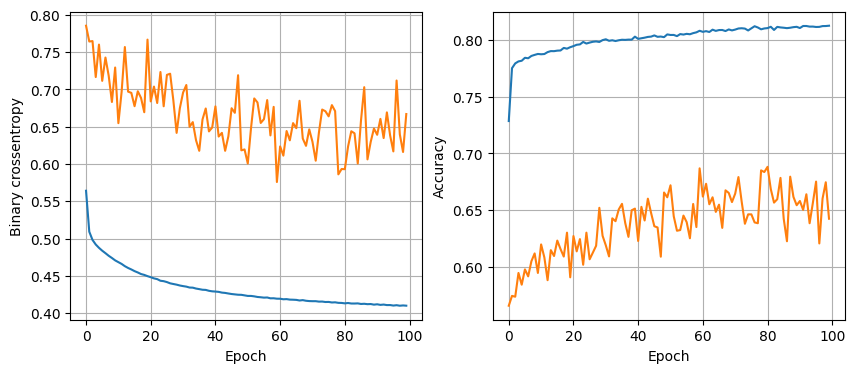

247/247 [==============================] - 4s 17ms/step - loss: 0.4312 - accuracy: 0.8366
16 nodes, dropout 0.2, lr 0.01, batch size 32


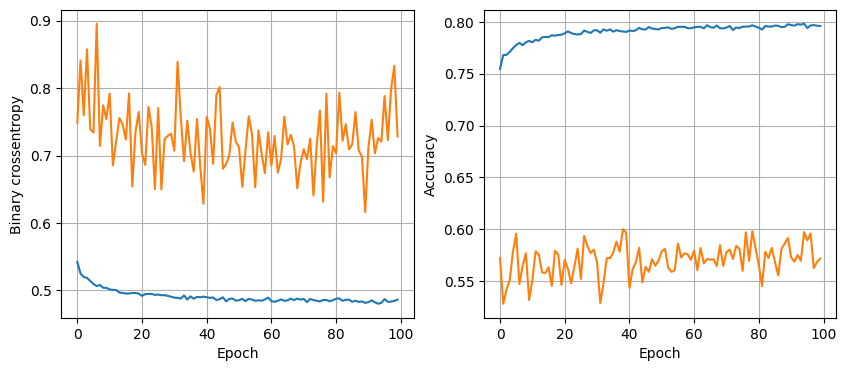

247/247 [==============================] - 0s 2ms/step - loss: 0.3969 - accuracy: 0.8741
16 nodes, dropout 0.2, lr 0.01, batch size 64


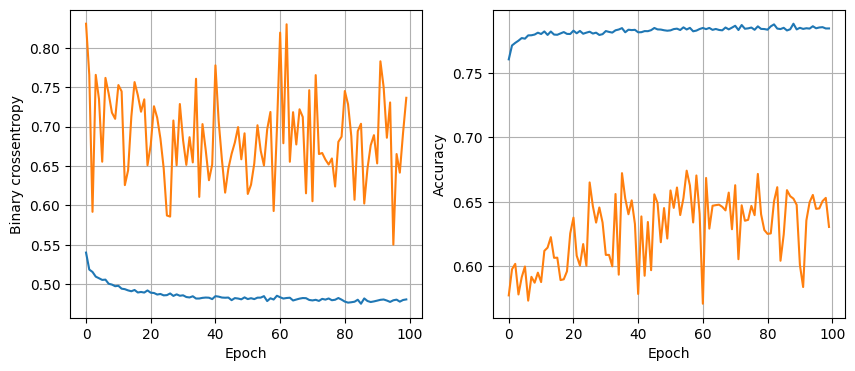

247/247 [==============================] - 0s 2ms/step - loss: 0.3904 - accuracy: 0.8463
16 nodes, dropout 0.2, lr 0.01, batch size 128


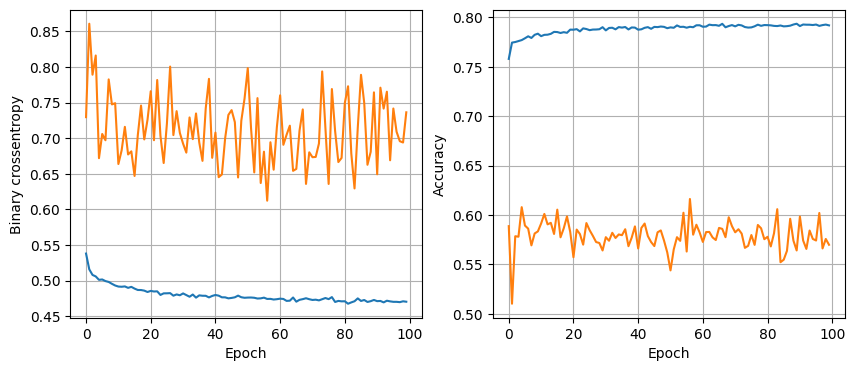

247/247 [==============================] - 3s 10ms/step - loss: 0.3800 - accuracy: 0.8760
16 nodes, dropout 0.2, lr 0.005, batch size 32


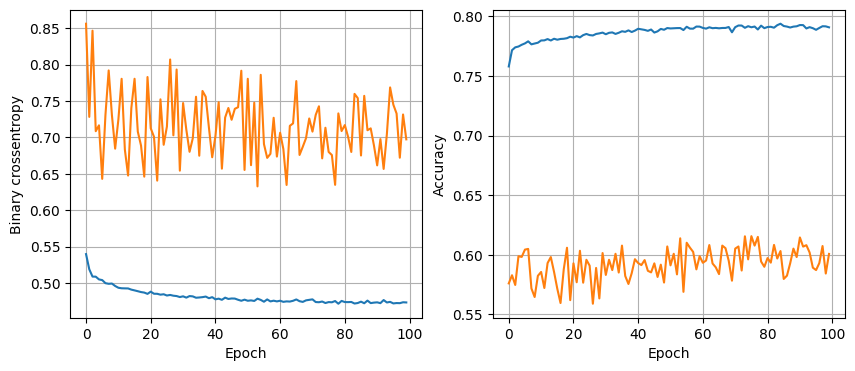

247/247 [==============================] - 1s 2ms/step - loss: 0.3980 - accuracy: 0.8677
16 nodes, dropout 0.2, lr 0.005, batch size 64


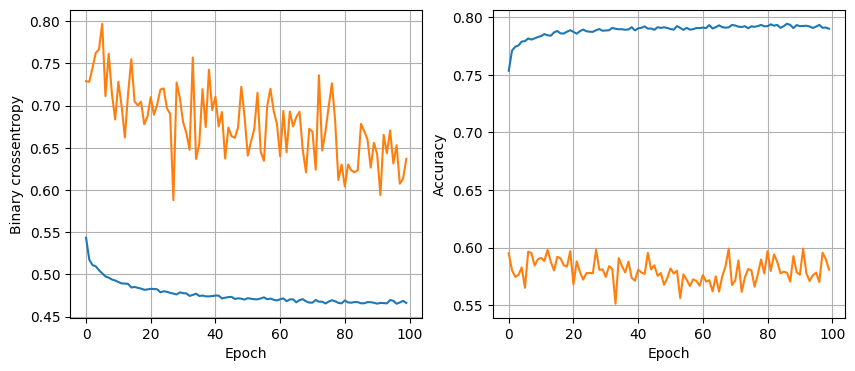

247/247 [==============================] - 0s 2ms/step - loss: 0.4179 - accuracy: 0.8722
16 nodes, dropout 0.2, lr 0.005, batch size 128


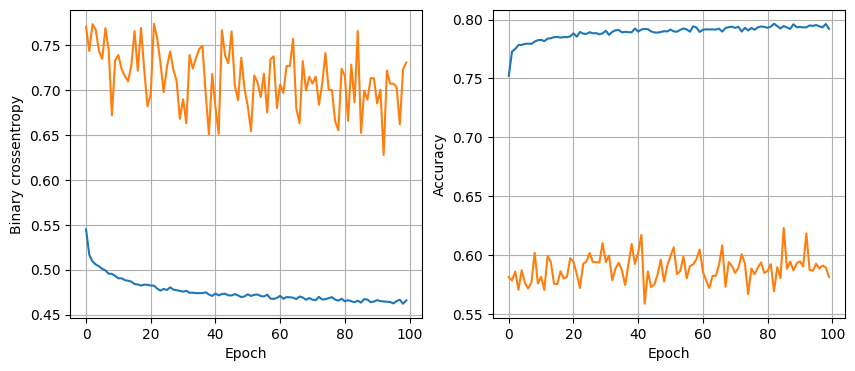

247/247 [==============================] - 0s 2ms/step - loss: 0.3813 - accuracy: 0.8702
16 nodes, dropout 0.2, lr 0.001, batch size 32


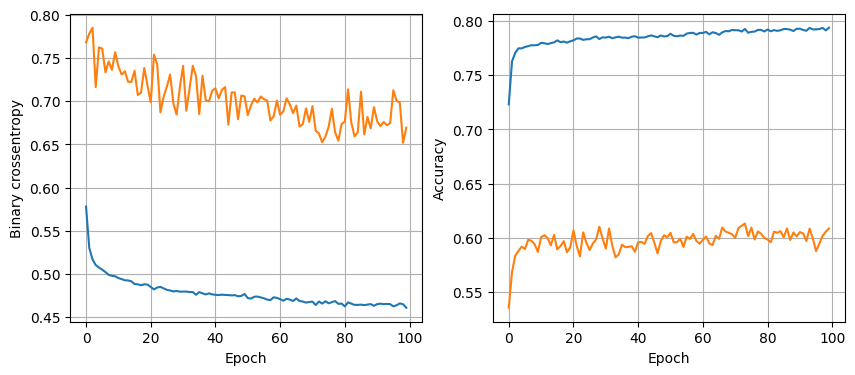

247/247 [==============================] - 0s 2ms/step - loss: 0.4033 - accuracy: 0.8651
16 nodes, dropout 0.2, lr 0.001, batch size 64


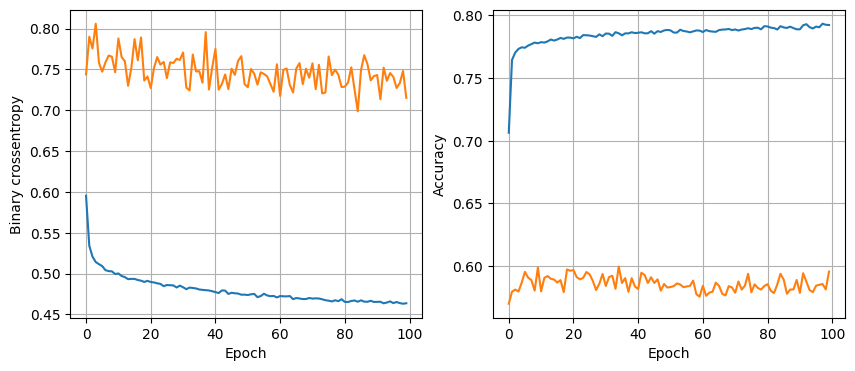

247/247 [==============================] - 0s 2ms/step - loss: 0.3843 - accuracy: 0.8680
16 nodes, dropout 0.2, lr 0.001, batch size 128


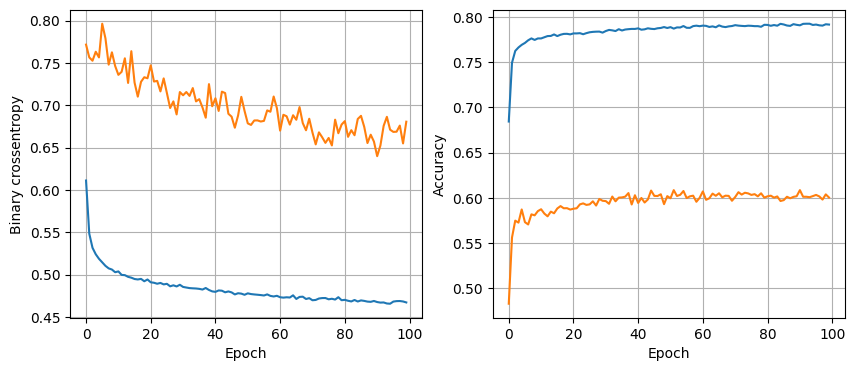

247/247 [==============================] - 0s 2ms/step - loss: 0.4011 - accuracy: 0.8640
32 nodes, dropout 0, lr 0.01, batch size 32


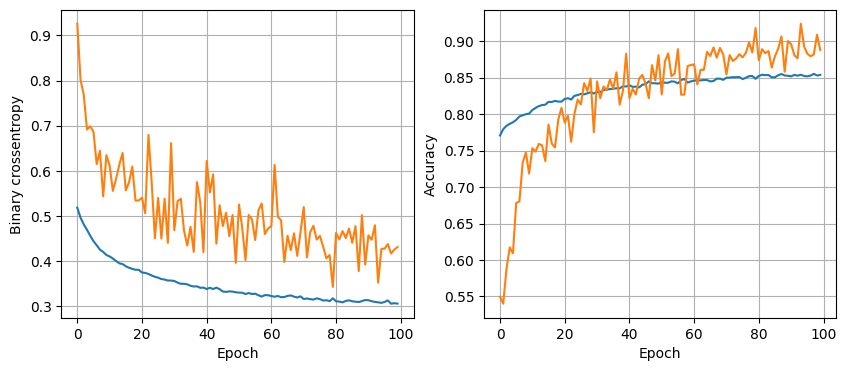

247/247 [==============================] - 0s 2ms/step - loss: 0.8230 - accuracy: 0.7542
32 nodes, dropout 0, lr 0.01, batch size 64


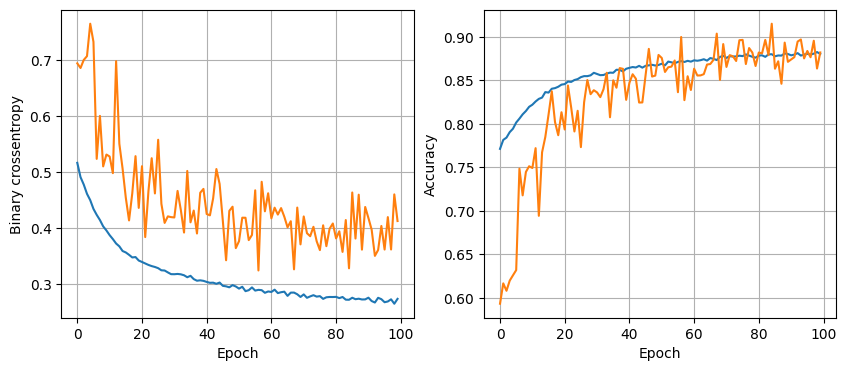

247/247 [==============================] - 1s 2ms/step - loss: 0.8250 - accuracy: 0.7873
32 nodes, dropout 0, lr 0.01, batch size 128


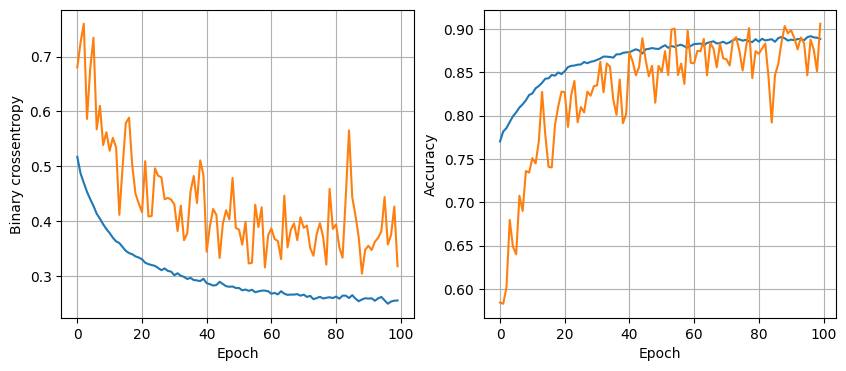

247/247 [==============================] - 0s 2ms/step - loss: 0.7875 - accuracy: 0.7889
32 nodes, dropout 0, lr 0.005, batch size 32


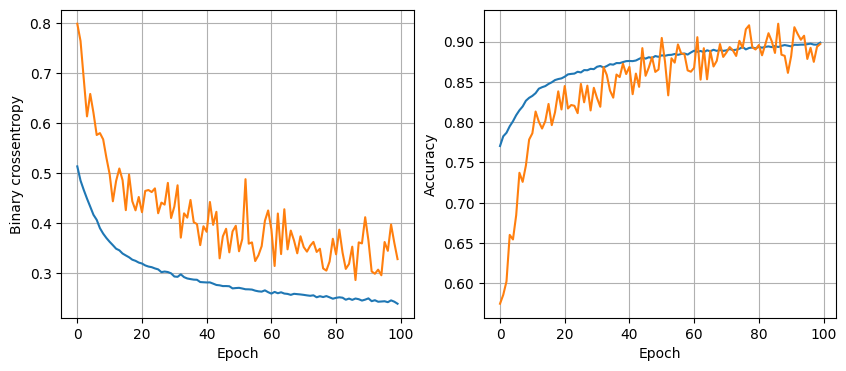

247/247 [==============================] - 1s 2ms/step - loss: 0.8660 - accuracy: 0.8061
32 nodes, dropout 0, lr 0.005, batch size 64


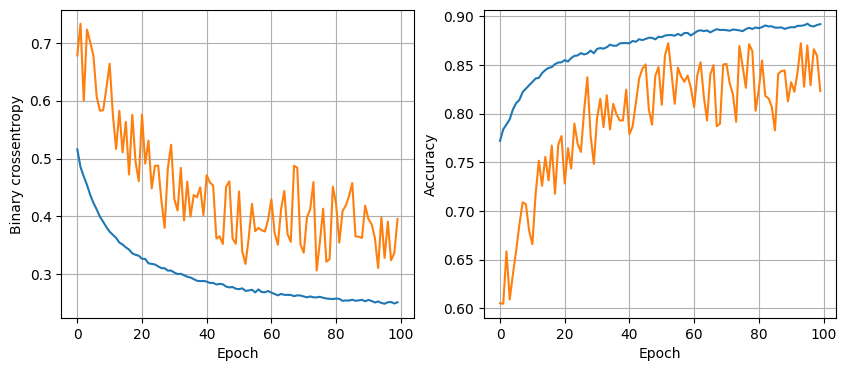

247/247 [==============================] - 0s 2ms/step - loss: 0.7095 - accuracy: 0.8136
32 nodes, dropout 0, lr 0.005, batch size 128


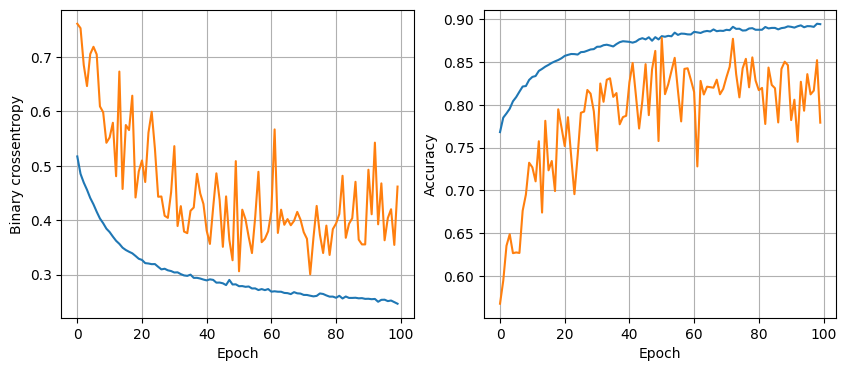

247/247 [==============================] - 1s 2ms/step - loss: 0.6664 - accuracy: 0.8244
32 nodes, dropout 0, lr 0.001, batch size 32


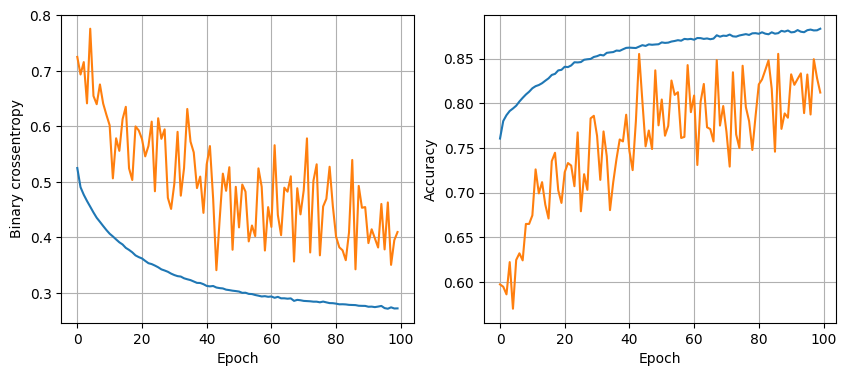

247/247 [==============================] - 1s 2ms/step - loss: 0.6362 - accuracy: 0.8009
32 nodes, dropout 0, lr 0.001, batch size 64


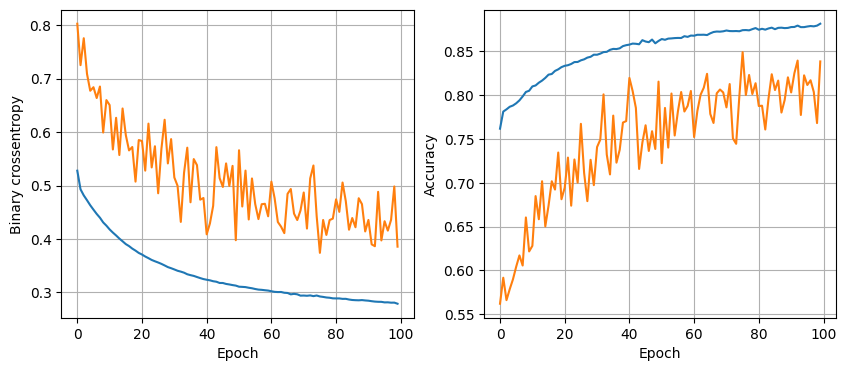

247/247 [==============================] - 1s 2ms/step - loss: 0.6368 - accuracy: 0.7957
32 nodes, dropout 0, lr 0.001, batch size 128


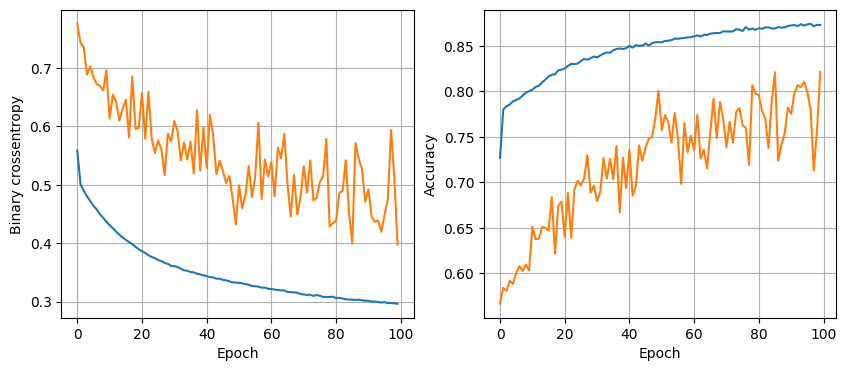

247/247 [==============================] - 1s 3ms/step - loss: 0.5636 - accuracy: 0.8041
32 nodes, dropout 0.2, lr 0.01, batch size 32


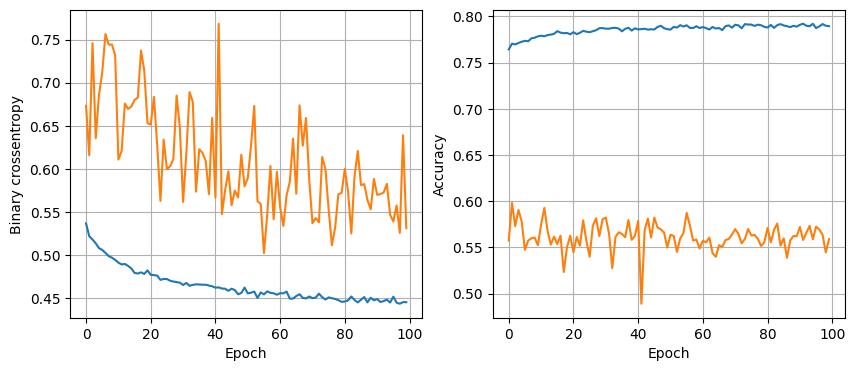

247/247 [==============================] - 1s 2ms/step - loss: 0.4722 - accuracy: 0.8758
32 nodes, dropout 0.2, lr 0.01, batch size 64


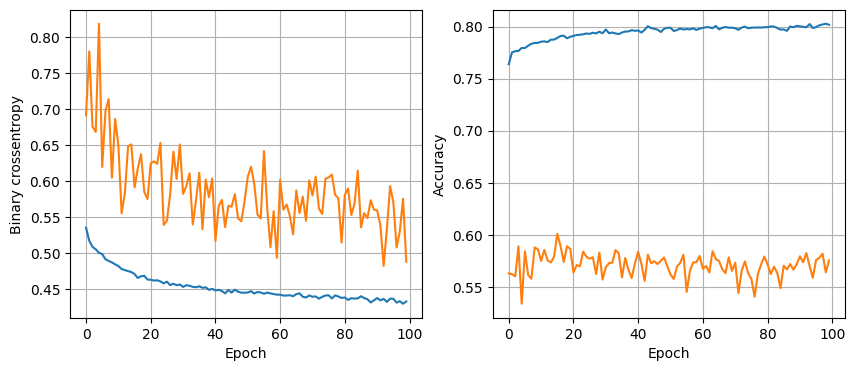

247/247 [==============================] - 1s 2ms/step - loss: 0.4743 - accuracy: 0.8758
32 nodes, dropout 0.2, lr 0.01, batch size 128


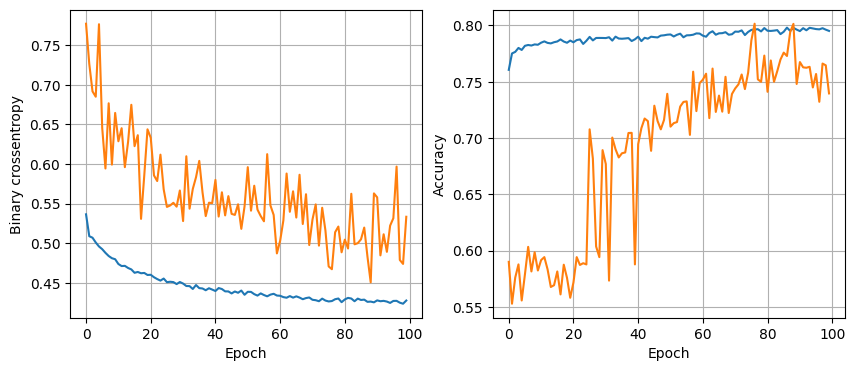

247/247 [==============================] - 1s 6ms/step - loss: 0.4321 - accuracy: 0.8186
32 nodes, dropout 0.2, lr 0.005, batch size 32


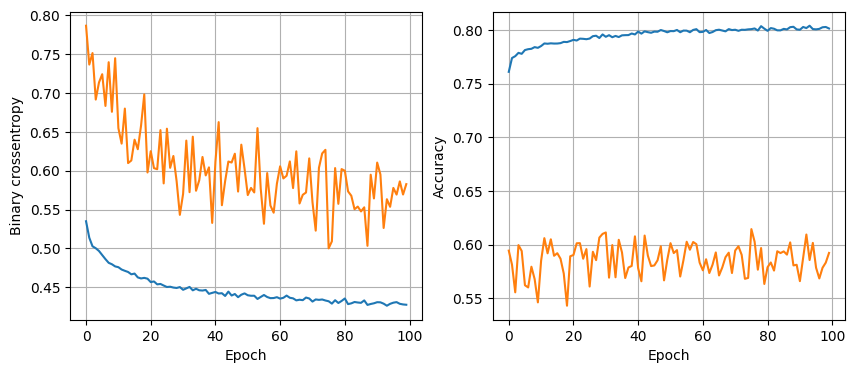

247/247 [==============================] - 1s 3ms/step - loss: 0.4157 - accuracy: 0.8758
32 nodes, dropout 0.2, lr 0.005, batch size 64


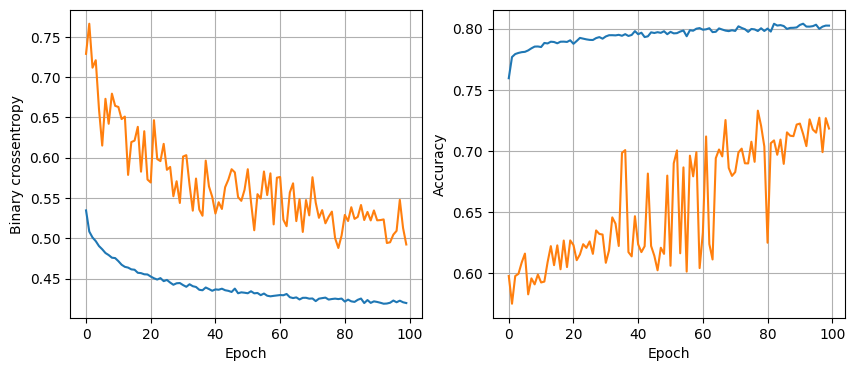

247/247 [==============================] - 1s 2ms/step - loss: 0.4341 - accuracy: 0.8288
32 nodes, dropout 0.2, lr 0.005, batch size 128


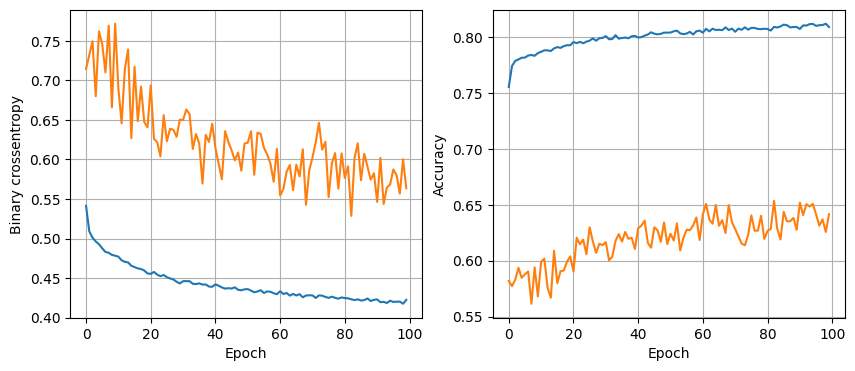

247/247 [==============================] - 1s 2ms/step - loss: 0.4079 - accuracy: 0.8640
32 nodes, dropout 0.2, lr 0.001, batch size 32


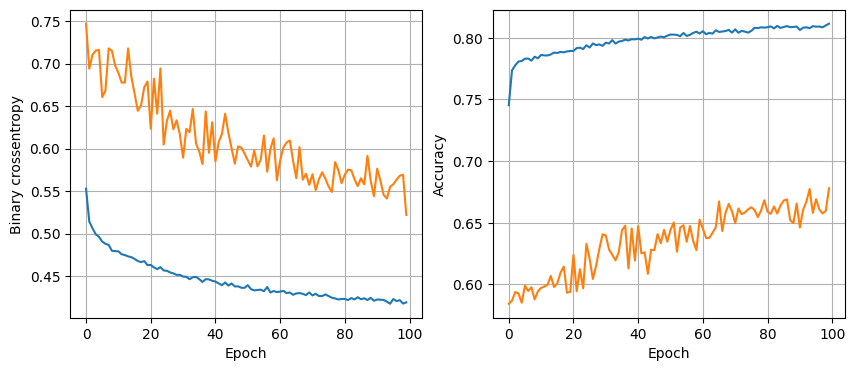

247/247 [==============================] - 1s 2ms/step - loss: 0.4234 - accuracy: 0.8528
32 nodes, dropout 0.2, lr 0.001, batch size 64


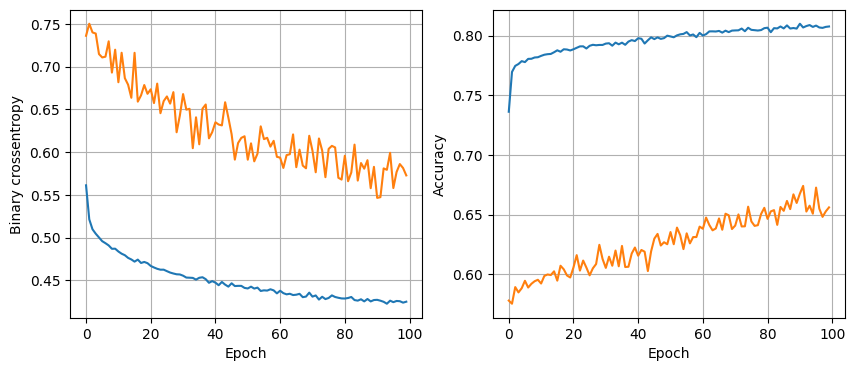

247/247 [==============================] - 1s 2ms/step - loss: 0.4025 - accuracy: 0.8599
32 nodes, dropout 0.2, lr 0.001, batch size 128


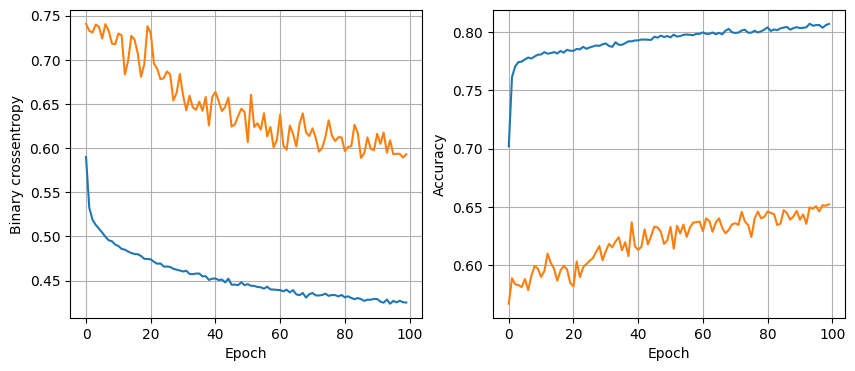

247/247 [==============================] - 1s 2ms/step - loss: 0.3923 - accuracy: 0.8608
64 nodes, dropout 0, lr 0.01, batch size 32


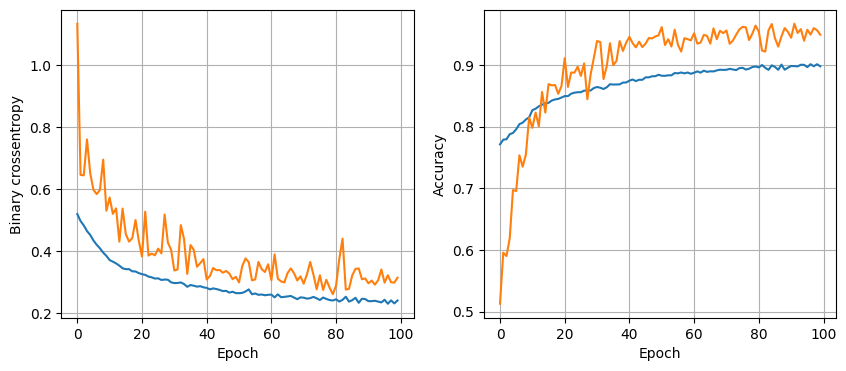

247/247 [==============================] - 1s 2ms/step - loss: 1.4256 - accuracy: 0.7749
64 nodes, dropout 0, lr 0.01, batch size 64


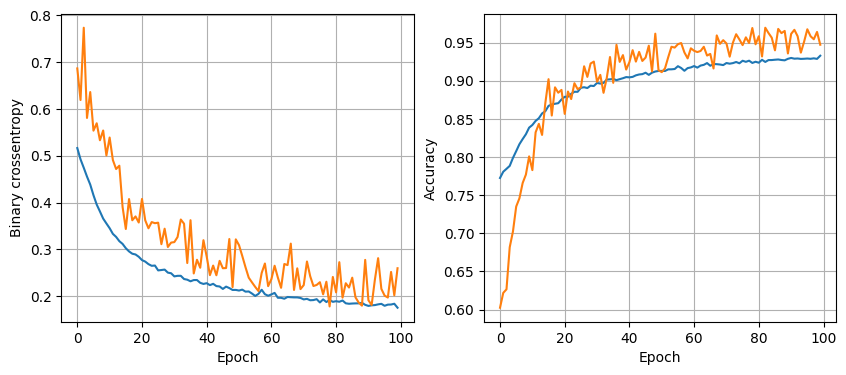

247/247 [==============================] - 1s 2ms/step - loss: 1.4861 - accuracy: 0.8021
64 nodes, dropout 0, lr 0.01, batch size 128


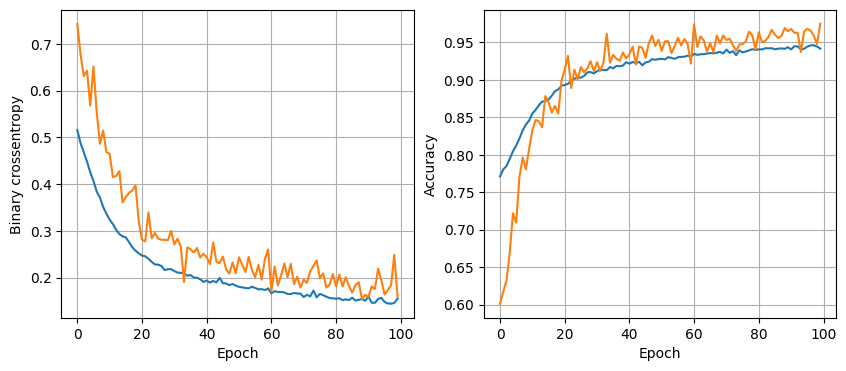

247/247 [==============================] - 1s 2ms/step - loss: 1.3511 - accuracy: 0.8156
64 nodes, dropout 0, lr 0.005, batch size 32


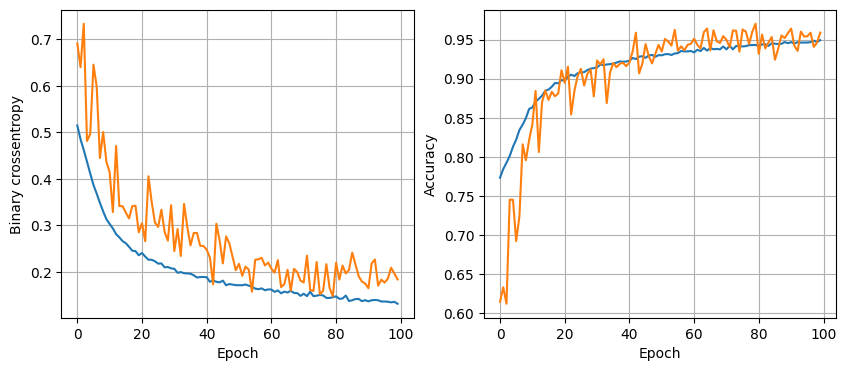

247/247 [==============================] - 1s 2ms/step - loss: 1.3979 - accuracy: 0.8243
64 nodes, dropout 0, lr 0.005, batch size 64


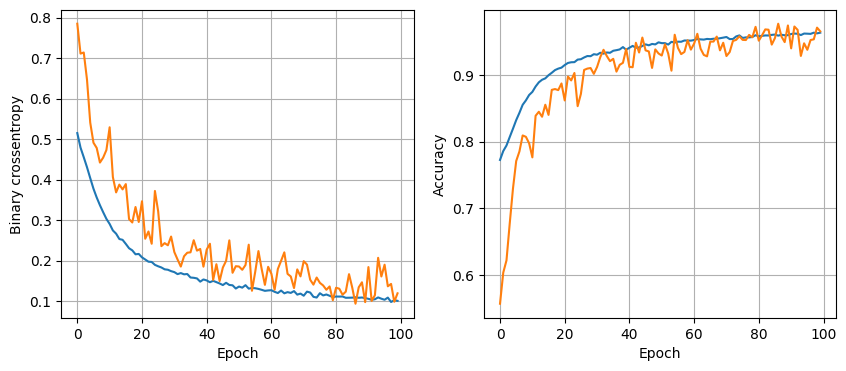

247/247 [==============================] - 1s 2ms/step - loss: 1.4562 - accuracy: 0.8249
64 nodes, dropout 0, lr 0.005, batch size 128


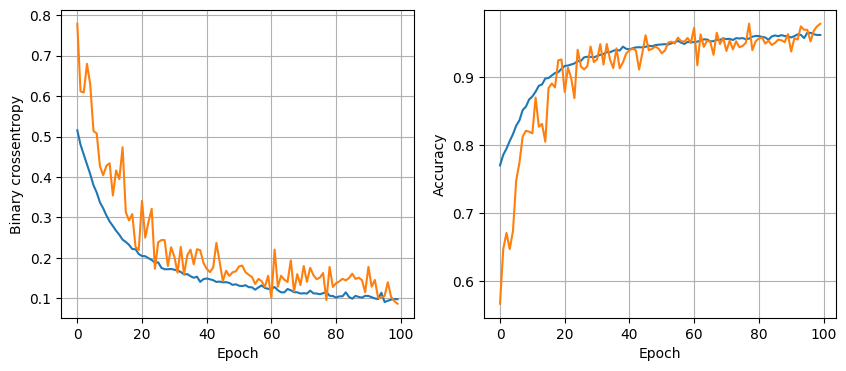

247/247 [==============================] - 1s 2ms/step - loss: 1.3469 - accuracy: 0.8255
64 nodes, dropout 0, lr 0.001, batch size 32


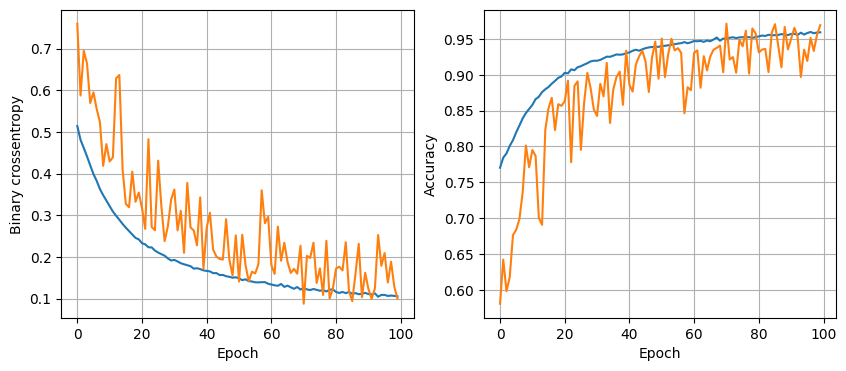

247/247 [==============================] - 1s 2ms/step - loss: 1.2728 - accuracy: 0.8202
64 nodes, dropout 0, lr 0.001, batch size 64


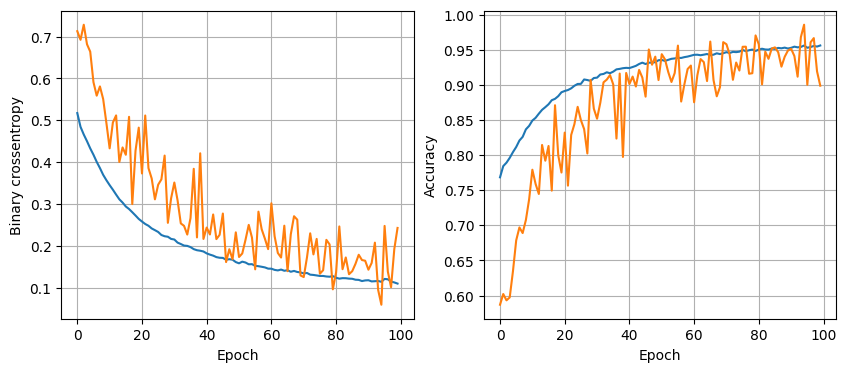

247/247 [==============================] - 1s 2ms/step - loss: 1.0634 - accuracy: 0.8408
64 nodes, dropout 0, lr 0.001, batch size 128


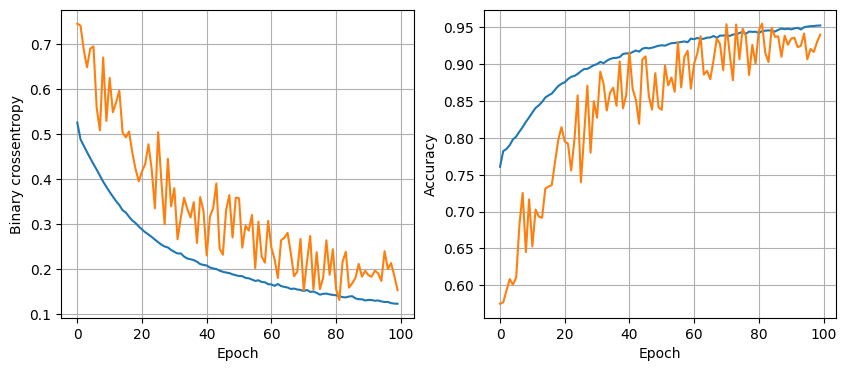

247/247 [==============================] - 0s 2ms/step - loss: 0.9547 - accuracy: 0.8238
64 nodes, dropout 0.2, lr 0.01, batch size 32


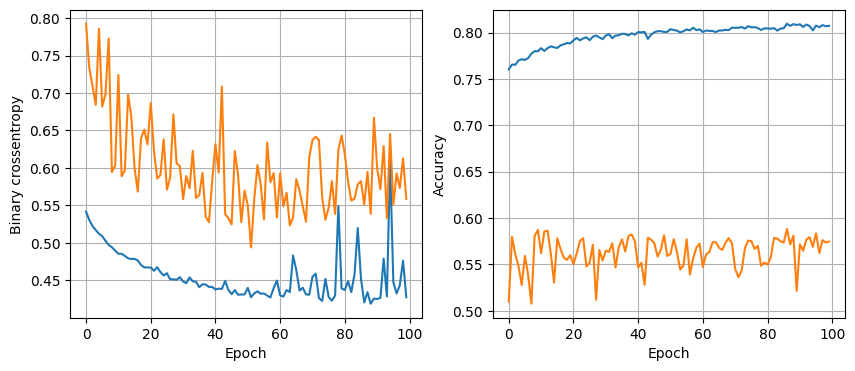

247/247 [==============================] - 1s 2ms/step - loss: 0.6426 - accuracy: 0.8801
64 nodes, dropout 0.2, lr 0.01, batch size 64


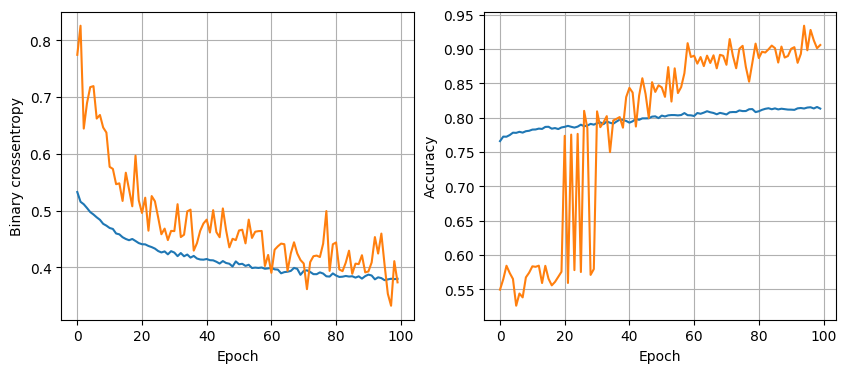

247/247 [==============================] - 1s 2ms/step - loss: 0.5124 - accuracy: 0.7674
64 nodes, dropout 0.2, lr 0.01, batch size 128


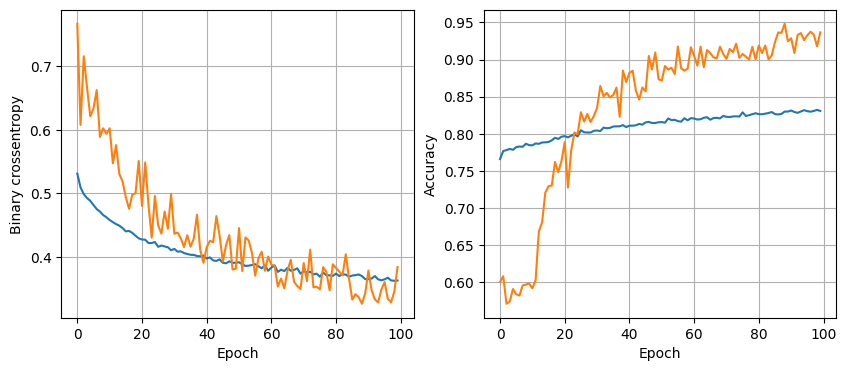

247/247 [==============================] - 1s 2ms/step - loss: 0.4653 - accuracy: 0.7631
64 nodes, dropout 0.2, lr 0.005, batch size 32


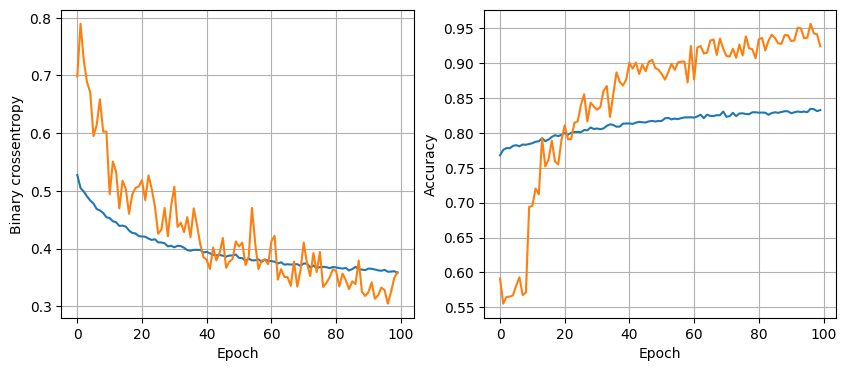

247/247 [==============================] - 1s 2ms/step - loss: 0.4767 - accuracy: 0.7839
64 nodes, dropout 0.2, lr 0.005, batch size 64


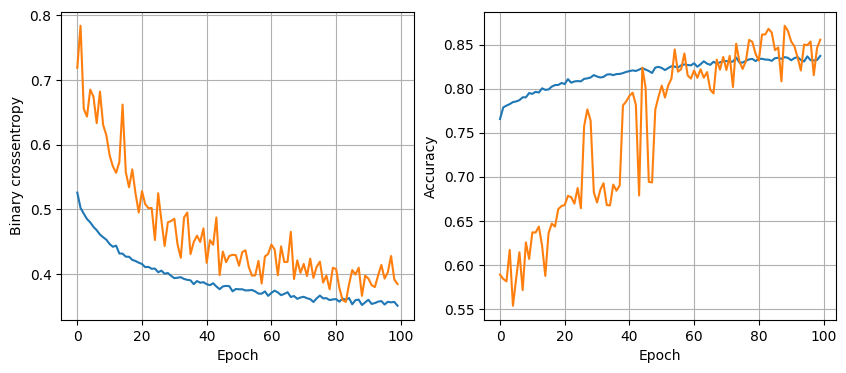

247/247 [==============================] - 1s 2ms/step - loss: 0.4463 - accuracy: 0.8139
64 nodes, dropout 0.2, lr 0.005, batch size 128


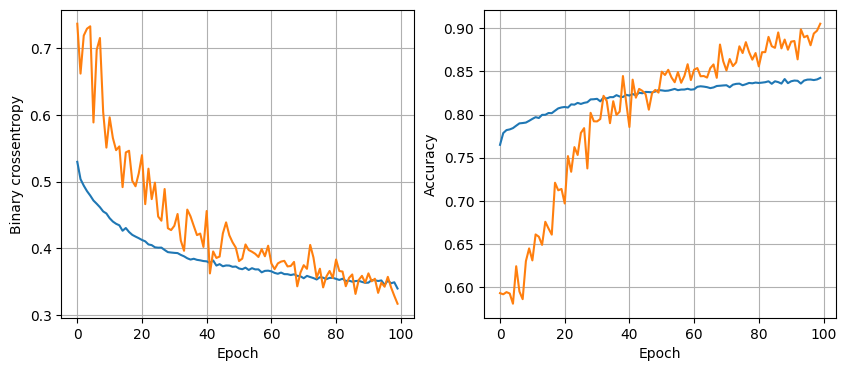

247/247 [==============================] - 1s 2ms/step - loss: 0.4776 - accuracy: 0.7967
64 nodes, dropout 0.2, lr 0.001, batch size 32


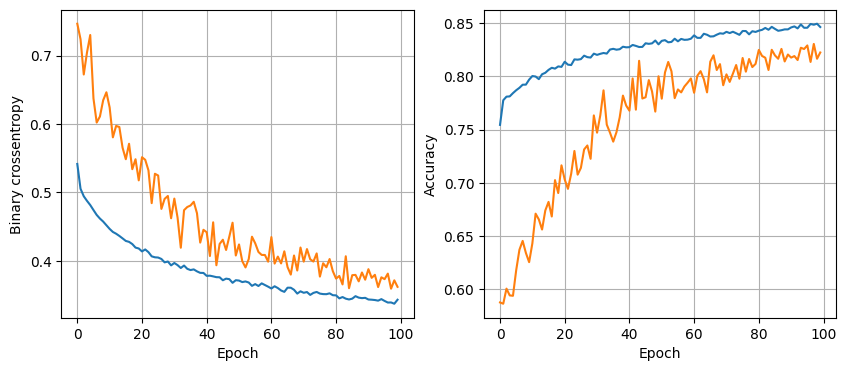

247/247 [==============================] - 1s 2ms/step - loss: 0.4192 - accuracy: 0.8387
64 nodes, dropout 0.2, lr 0.001, batch size 64


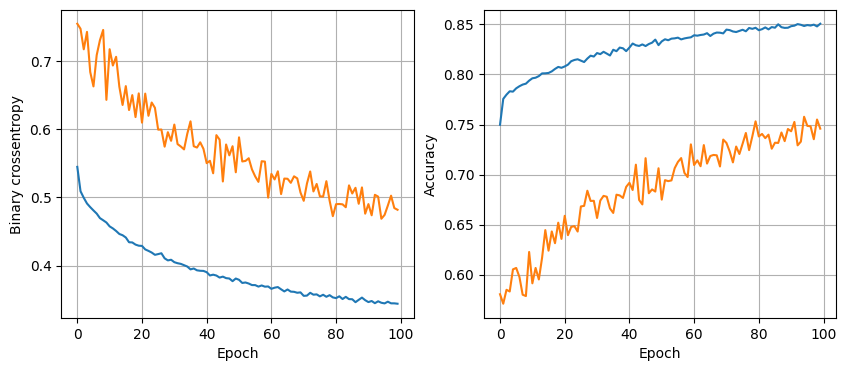

247/247 [==============================] - 1s 2ms/step - loss: 0.3795 - accuracy: 0.8674
64 nodes, dropout 0.2, lr 0.001, batch size 128


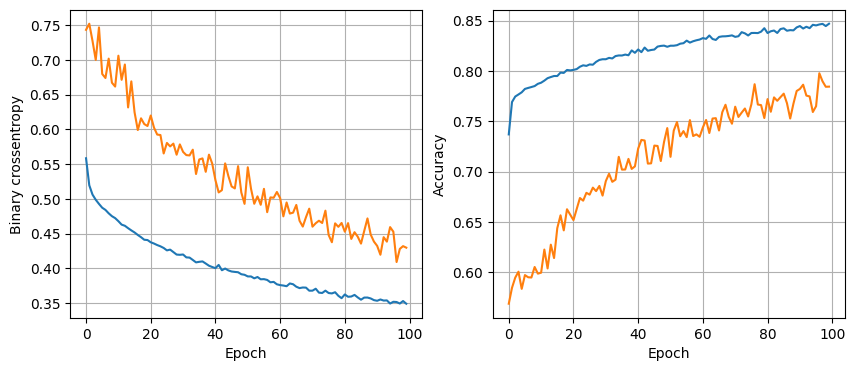

247/247 [==============================] - 1s 2ms/step - loss: 0.3877 - accuracy: 0.8583


In [ ]:
# Hyperparameter tuning
# Main loop that iterates over different learning rates, num_nodes, dropout_prob, and batch_size and passes it to the train_model function

least_val_loss = float('inf')
least_loss_model = None

epochs = 100 # Specify the number of epochs, this model uses 100 iterations

for num_nodes in [16, 32, 64]:
  for dropout_prob in [0, 0.2]:
    for lr in [0.01, 0.005, 0.001]:
      for batch_size in [32, 64, 128]:
        print(f"{num_nodes} nodes, dropout {dropout_prob}, lr {lr}, batch size {batch_size}")

        model, history = train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs)
        plot_history(history)
        val_loss = model.evaluate(X_valid, y_valid)[0]
        if val_loss < least_val_loss:
          least_val_loss = val_loss
          least_loss_model = model

# Keras sequential may not be the optimal model as we are dealing with a 44000 by 88 shape df and it would take significant time to train and see any difference and fine tune.
# Ave runtime is >3 hrs on a macbook pro M1 chip which produced 53 epochs/iterations before the runtime was disconnected.
# As the training data passess through each iteration the loss decreases, however accuracy is stochastic.
# If we would have ran through all epochs we would select the lowest error rate which is probably the last model, and assign it to least val_loss this is our base NN model.
# Note that the larger the number of epochs does not mean better results. Most models are sufficiently trained with 11 epochs.
# In our case when can already use the 12th iteration which has loss: 0.3800 - accuracy: 0.8760
# The last iteration before disconnection is loss: 0.3877 - accuracy: 0.8583

In [ ]:
# Did not run this part because variables were lost during the 4 hr training as colab disconnected. Therefore, we were not able to continue hyperparameter tuning and/or metric tests
# However based on the stored output of the plot_history function we did earlier, we can visually inspect the graph and the outputs in the print function
# 76-88 accuracy was the range and the last iteration returned a loss of .38

# Metric to get the classification report for our neural network method

y_pred = least_loss_model.predict(X_test) # get optimal model (least_loss_model) | we use .predict() on our test data to generate predicted probabilities.
y_pred = (y_pred > 0.5).astype(int).reshape(-1,) #converts the y_pred (predicted prob) into binary, threshhold at 0.5, where values <= 0.5 == 0 and values => 0.5 == 1 | reshaped to a 1D array

247/247 [==============================] - 3s 10ms/step


In [ ]:
print(classification_report(y_test, y_pred)) # print the metrics on our test set and predicted set

# Since the variables were lost during a 3 hr training. We would take the last iteration as our metrics
# The last iteration before disconnection is loss: 0.3877 - accuracy: 0.8583

'print(classification_report(y_test, y_pred))'

In [ ]:
# Side notes:
# Chat GPT uses a transformer architecture which is based on neural networks. Many of the Generative AI we use today uses neural networks as the base model or is derived from NNs.
# Sequential data (time series, sensors, gene sequences, weather, etc) or data that is reliant on previous data uses recurrent neural networks (RNNs), we have used a feedforward neural network (FNN).

In [ ]:
# Final Note and Analysis: While Neural Networs is a great tool for generative AI. A simple algorithm such as Logistic Regression or Naive Bayes is sufficient enough to generate good results
# By visual examination of the plots, each iteration reduces the loss function and also smoothens the graph.

---
# Part 2: Second Methodology

---
## Preprocessing

In [ ]:
# In this section, we would approach the preprocessing and modeling differently.
# This will provide comparison for our final model discussed in Part 3')

In [ ]:
# Feature Selection
df2

age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   
41187   74      retired  married  professional.course       no     yes   no   

         contact month day_of_week  ...  campaign  pdays  previous  \
0      telephone   may         mon  ...         1    999         0   
1      telephone   may         mon  ...         1    999         0   
2      telephone   may         mon  ...         1    999         0   
3      telephone   may         mon  ...         1    999         0   
4      telephone   may         mon  ...         1    999         0   
...          ...   ...         ...  ...       ...    ...       ...   
41183   cellular   nov         fri  ...         1    999         0   
41184   cellular   nov         fri  ...         1    999         0   
41185   cellular   nov         fri  ...         2    999         0   
41186   cellular   nov         fri  ...         1    999         0   
41187   cellular   nov         fri  ...         3    999         1   

          poutcome emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0      nonexistent          1.1          93.994          -36.4      4.857   
1      nonexistent          1.1          93.994          -36.4      4.857   
2      nonexistent          1.1          93.994          -36.4      4.857   
3      nonexistent          1.1          93.994          -36.4      4.857   
4      nonexistent          1.1          93.994          -36.4      4.857   
...            ...          ...             ...            ...        ...   
41183  nonexistent         -1.1          94.767          -50.8      1.028   
41184  nonexistent         -1.1          94.767          -50.8      1.028   
41185  nonexistent         -1.1          94.767          -50.8      1.028   
41186  nonexistent         -1.1          94.767          -50.8      1.028   
41187      failure         -1.1          94.767          -50.8      1.028   

       nr.employed    y  
0           5191.0   no  
1           5191.0   no  
2           5191.0   no  
3           5191.0   no  
4           5191.0   no  
...            ...  ...  
41183       4963.6  yes  
41184       4963.6   no  
41185       4963.6   no  
41186       4963.6  yes  
41187       4963.6   no  

[41188 rows x 21 columns]

In [ ]:
'''
Feature Selection

Note: Our feature selection is based on a combination of logic, domain knowledge, and EDA distribution to balance the chosen features
Important Note: Our bias is to add more features. This is because machine learning prediction is positively correlated with the amount of training data.

Not chosen:
contact: Imbalanced per EDA and does not relate to the real world as everything uses cellular
duration: Per attribute information on first cell this should be discarded
previous: not taken as it appears to be correlated to campaign feature which would not have an impact (treated as a duplicate)

Chosen:
month: Evenly distributed  data aside from month of May and seasonality influences people’s decisions to make a term deposit. 13th month, bonuses, etc.
day_of_week: evenly distributed
campaign: Good distribution even if blue is high on the lower side of the number of contacts the red is more evenly distributed over the latter portion of number of contacts
pdays: More data and evenly distributed (need to convert to categorical as this is ordinal data and not numeric)
poutcome: good distribution
emp.var.rate: good distribution and adds socio economic context
cons.price.idx: good distribution and adds socio economic context
cons.conf.idx: confidence index indicates is a measure of risk profile of consumers which may affect their term deposit availability. The less confidence the more risk the less term deposit as household liquidity (cash) is prioritized
euribor3m: Euribor is the acronym for the Euro Interbank Offered Rate. This is the interest rate at which credit institutions lend money to each other, which is often referred to as “the price of money”
nr.employed: employment data is good for gauging how much money the client holds which may affect their term deposit decision. if they have no stable income they may not deposit cash
'''

'\nFeature Selection\nNote: Our feature selection is based on a combination of logic, domain knowledge, and EDA distribution to balance the chosen features\nNote1: Our bias is to add more features. This is because machine learning prediction is positively correlated with the amount of training data. \n\nNot chosen:\ncontact: Imbalanced per EDA and does not relate to the real world as everything uses cellular \nduration: Per attribute information on first cell this should be discarded\nprevious: not taken as it appears to be correlated to campaign feature which would not have an impact (treated as a duplicate) \n\nChosen:\nmonth: Evenly distributed  data aside from month of May and seasonality influences people’s decisions to make a term deposit. 13th month, bonuses, etc. \nday_of_week: evenly distributed \nCampaign: Good distribution even if blue is high on the lower side of the number of contacts the red is more evenly distributed over the latter portion of number of contacts\npdays: 

In [ ]:
# Chosen Features to drop
df2 = df2.drop(['duration', 'contact', 'previous'], axis=1)
df2.columns.tolist()

In [ ]:
# Drop Duplicates
df2 = df2.drop_duplicates(keep='first')

<function matplotlib.pyplot.show(close=None, block=None)>

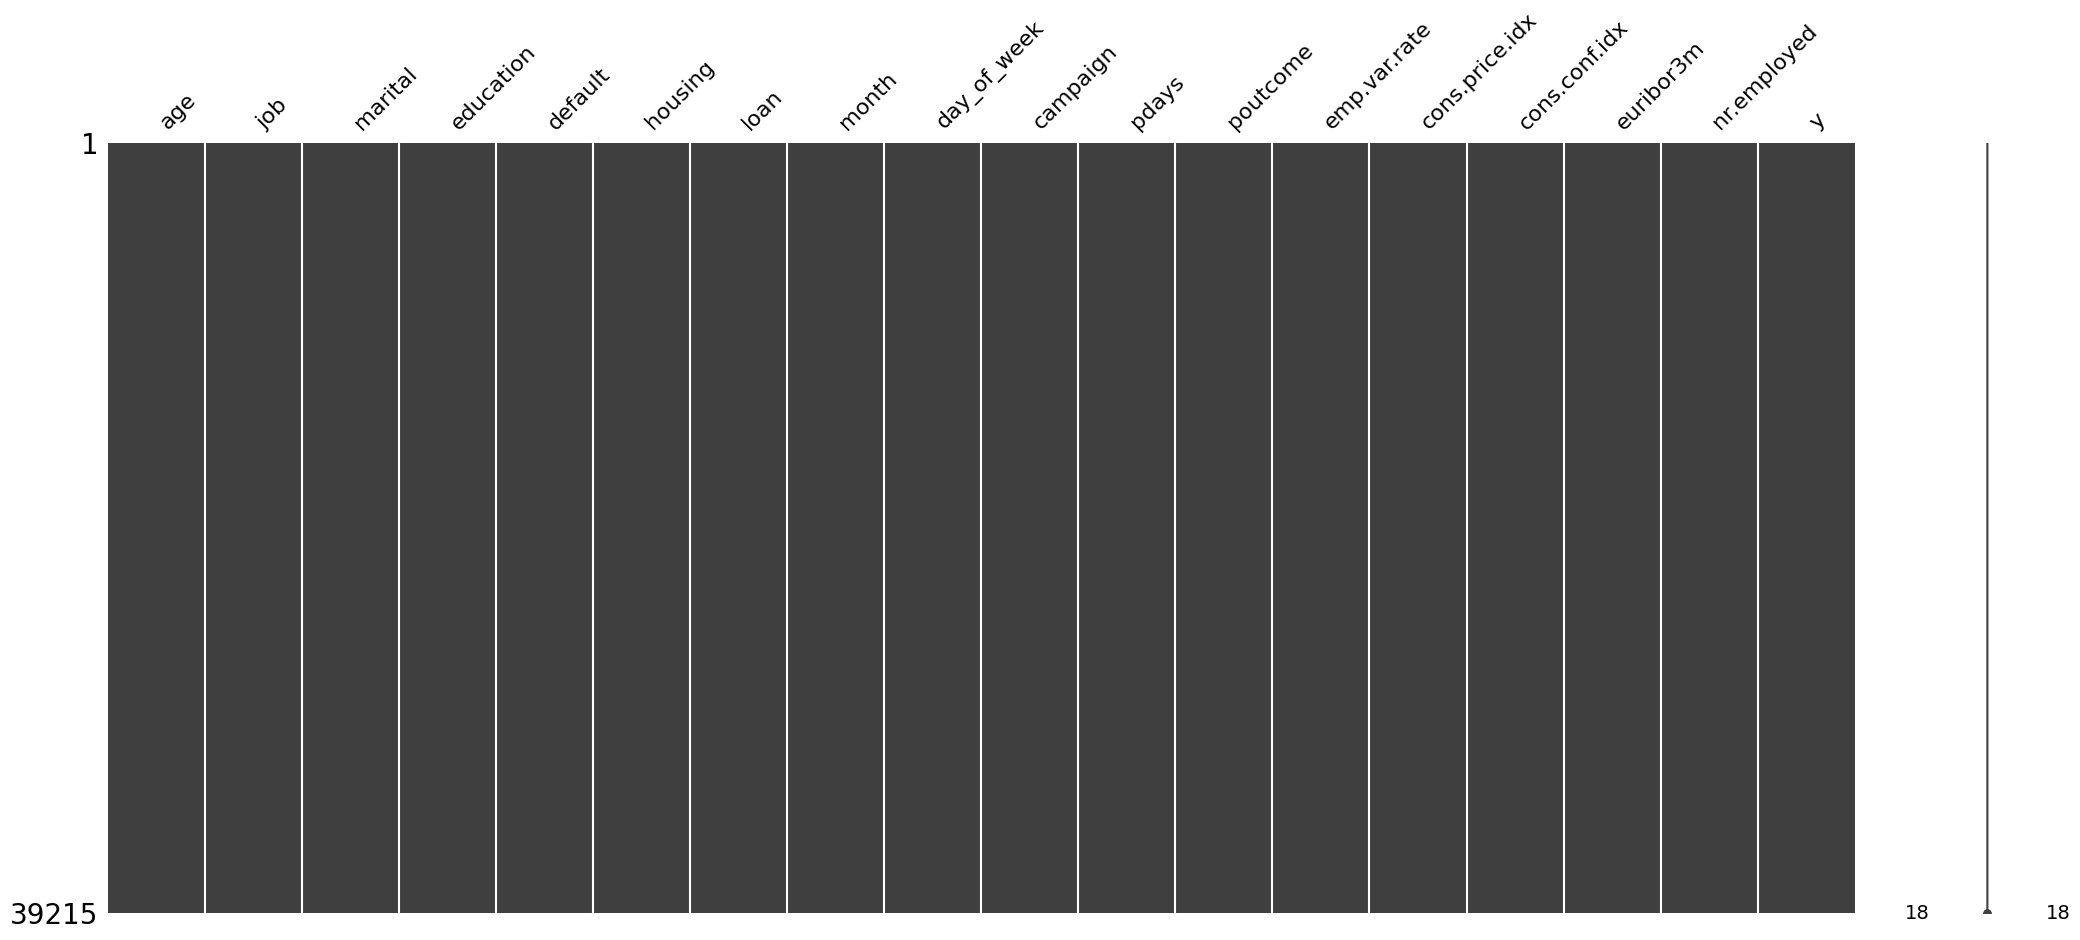

In [ ]:
# Missing Data
msno.matrix(df2)
plt.show


In [ ]:
# categorical conversion of ordinal ['month', 'day_of_week', 'pdays']

df2['pdays'] = df2['pdays'].astype('category')
df2['month'] = df2['month'].astype('category')
df2['day_of_week'] = df2['day_of_week'].astype('category')

In [ ]:
# converting [y] into binary, no == 0, yes == 1
df2['y'] = (df2['y'] == 'yes').astype(int)
df2['y']



0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, Length: 39215, dtype: int64

In [ ]:
df2['y'].unique() # Checking if .astype() error has not occured. Confirmed there are unique 1 values in the df2

array([0, 1])

In [ ]:
# One hot encoding
# Listing Categorical columns
# Listing Number of Columns vs Old number of columns

categorical_columns = df2.select_dtypes(include=['object', 'category'])
categorical_columns = categorical_columns.columns.tolist()
print('Categorical Columns:', categorical_columns)

#  converts categorical variables into dummy variables Each category in the original column gets its own dummy column with binary values.
df2_encoded = pd.get_dummies(df2)
print('-> With dummies:', len(df2_encoded.columns), 'columns vs','without dummies: ', len(df2.columns), 'columns')

df2 = df2_encoded

# note that pd.get_dummies(dataframe) appends the dummy columns to the last column which is our y (target var), hence the target variable is now in the middle column of our df
df2

Categorical Columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'day_of_week', 'pdays', 'poutcome']
-> With dummies: 86 columns vs without dummies:  18 columns


age  campaign  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0       56         1           1.1          93.994          -36.4      4.857   
1       57         1           1.1          93.994          -36.4      4.857   
2       37         1           1.1          93.994          -36.4      4.857   
3       40         1           1.1          93.994          -36.4      4.857   
4       56         1           1.1          93.994          -36.4      4.857   
...    ...       ...           ...             ...            ...        ...   
41183   73         1          -1.1          94.767          -50.8      1.028   
41184   46         1          -1.1          94.767          -50.8      1.028   
41185   56         2          -1.1          94.767          -50.8      1.028   
41186   44         1          -1.1          94.767          -50.8      1.028   
41187   74         3          -1.1          94.767          -50.8      1.028   

       nr.employed  y  job_admin.  job_blue-collar  ...  pdays_20  pdays_21  \
0           5191.0  0           0                0  ...         0         0   
1           5191.0  0           0                0  ...         0         0   
2           5191.0  0           0                0  ...         0         0   
3           5191.0  0           1                0  ...         0         0   
4           5191.0  0           0                0  ...         0         0   
...            ... ..         ...              ...  ...       ...       ...   
41183       4963.6  1           0                0  ...         0         0   
41184       4963.6  0           0                1  ...         0         0   
41185       4963.6  0           0                0  ...         0         0   
41186       4963.6  1           0                0  ...         0         0   
41187       4963.6  0           0                0  ...         0         0   

       pdays_22  pdays_25  pdays_26  pdays_27  pdays_999  poutcome_failure  \
0             0         0         0         0          1                 0   
1             0         0         0         0          1                 0   
2             0         0         0         0          1                 0   
3             0         0         0         0          1                 0   
4             0         0         0         0          1                 0   
...         ...       ...       ...       ...        ...               ...   
41183         0         0         0         0          1                 0   
41184         0         0         0         0          1                 0   
41185         0         0         0         0          1                 0   
41186         0         0         0         0          1                 0   
41187         0         0         0         0          1                 1   

       poutcome_nonexistent  poutcome_success  
0                         1                 0  
1                         1                 0  
2                         1                 0  
3                         1                 0  
4                         1                 0  
...                     ...               ...  
41183                     1                 0  
41184                     1                 0  
41185                     1                 0  
41186                     1                 0  
41187                     0                 0  

[39215 rows x 86 columns]

In [ ]:
# Bring target var back into the last column
# Note that our target column ['y] position has shifted in the middle of our dataframe during categorical conversion (see df above this cell)
# This code returns it to the proper position in the last column
# Important note: without this code the model is overfitted. managed to fix the overfitting (0.999 accuracy) in the last iteration sent over email (capstoneRG2.ipynb) using this simple debug method.
df2['y'] = df2.pop('y')
df2 = pd.concat([df2.iloc[:, :-1], df2.iloc[:, -1]], axis=1)
df2

age  campaign  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0       56         1           1.1          93.994          -36.4      4.857   
1       57         1           1.1          93.994          -36.4      4.857   
2       37         1           1.1          93.994          -36.4      4.857   
3       40         1           1.1          93.994          -36.4      4.857   
4       56         1           1.1          93.994          -36.4      4.857   
...    ...       ...           ...             ...            ...        ...   
41183   73         1          -1.1          94.767          -50.8      1.028   
41184   46         1          -1.1          94.767          -50.8      1.028   
41185   56         2          -1.1          94.767          -50.8      1.028   
41186   44         1          -1.1          94.767          -50.8      1.028   
41187   74         3          -1.1          94.767          -50.8      1.028   

       nr.employed  job_admin.  job_blue-collar  job_entrepreneur  ...  \
0           5191.0           0                0                 0  ...   
1           5191.0           0                0                 0  ...   
2           5191.0           0                0                 0  ...   
3           5191.0           1                0                 0  ...   
4           5191.0           0                0                 0  ...   
...            ...         ...              ...               ...  ...   
41183       4963.6           0                0                 0  ...   
41184       4963.6           0                1                 0  ...   
41185       4963.6           0                0                 0  ...   
41186       4963.6           0                0                 0  ...   
41187       4963.6           0                0                 0  ...   

       pdays_21  pdays_22  pdays_25  pdays_26  pdays_27  pdays_999  \
0             0         0         0         0         0          1   
1             0         0         0         0         0          1   
2             0         0         0         0         0          1   
3             0         0         0         0         0          1   
4             0         0         0         0         0          1   
...         ...       ...       ...       ...       ...        ...   
41183         0         0         0         0         0          1   
41184         0         0         0         0         0          1   
41185         0         0         0         0         0          1   
41186         0         0         0         0         0          1   
41187         0         0         0         0         0          1   

       poutcome_failure  poutcome_nonexistent  poutcome_success  y  
0                     0                     1                 0  0  
1                     0                     1                 0  0  
2                     0                     1                 0  0  
3                     0                     1                 0  0  
4                     0                     1                 0  0  
...                 ...                   ...               ... ..  
41183                 0                     1                 0  1  
41184                 0                     1                 0  0  
41185                 0                     1                 0  0  
41186                 0                     1                 0  1  
41187                 1                     0                 0  0  

[39215 rows x 86 columns]

In [ ]:
# Extracting X

data_encoded = df2.copy(deep = True) # creating a copy to replicate original process for consistency
predictors = df2.columns[df2.columns != 'y'] # extract X columns

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the encoded features / predictors
df_scaled = scaler.fit_transform(data_encoded[predictors])

df_standardized = pd.DataFrame(df_scaled, columns=predictors)
df_standardized.head()

age  campaign  emp.var.rate  cons.price.idx  cons.conf.idx  ...  \
0  1.517127 -0.575883      0.656737        0.711763       0.881087  ...   
1  1.612677 -0.575883      0.656737        0.711763       0.881087  ...   
2 -0.298338 -0.575883      0.656737        0.711763       0.881087  ...   
3 -0.011686 -0.575883      0.656737        0.711763       0.881087  ...   
4  1.517127 -0.575883      0.656737        0.711763       0.881087  ...   

   pdays_27  pdays_999  poutcome_failure  poutcome_nonexistent  \
0  -0.00505   0.200257         -0.344579              0.405262   
1  -0.00505   0.200257         -0.344579              0.405262   
2  -0.00505   0.200257         -0.344579              0.405262   
3  -0.00505   0.200257         -0.344579              0.405262   
4  -0.00505   0.200257         -0.344579              0.405262   

   poutcome_success  
0         -0.190264  
1         -0.190264  
2         -0.190264  
3         -0.190264  
4         -0.190264  

[5 rows x 85 columns]

In [ ]:
df2['y'].unique()

array([0, 1])

In [ ]:
# Split

# Split the data into features and target variable
X = df_standardized
y = df2['y']


# Split the data into the training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify = y, random_state = 19)

# Test size is 40% as so we can have a comparison with the Part 1 Methodology,
# Stratify is a seed for split shuffle consistency

---
## Modeling and metrics

---
### Logistic Regression

In [ ]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
logistic_predictions = logistic_model.predict(X_test)

In [ ]:
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
print(f"Logistic regression accuracy: {logistic_accuracy}")
logistic_report = classification_report(y_test, logistic_predictions)
print(f"Logistic regression classification report: {logistic_report}")

Logistic regression accuracy: 0.8951931658804029
Logistic regression classification report:               precision    recall  f1-score   support

           0       0.90      0.98      0.94     13849
           1       0.66      0.22      0.33      1837

    accuracy                           0.90     15686
   macro avg       0.78      0.60      0.64     15686
weighted avg       0.88      0.90      0.87     15686



<Axes: >

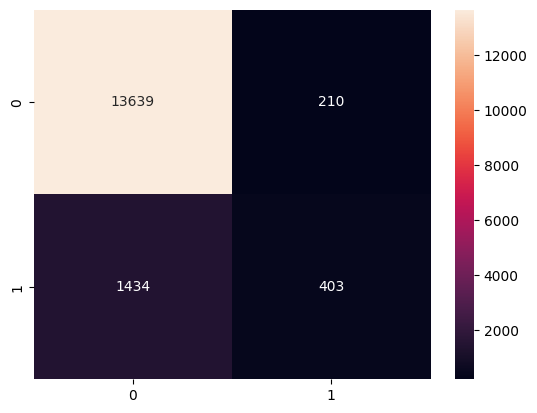

In [ ]:
# Heatmap Visualizer - confusion matrix for logistic regression
sns.heatmap(confusion_matrix(y_test, logistic_predictions), annot = True, fmt = 'd')


In [ ]:
# Display the coefficients of the Logistic Regression model
logistic_coefficients = logistic_model.coef_[0]  # Assuming binary classification for simplicity

# Create a DataFrame to display feature names and their corresponding coefficients
feature_names = df2.columns[:-1]  # Adjust this if the feature names are in a different form
coefficients_df = pd.DataFrame(logistic_coefficients, index=predictors, columns=['Coefficient'])

# Display the coefficients for interpretation
print(coefficients_df)

                      Coefficient
age                     -0.011370
campaign                -0.149893
emp.var.rate            -1.316191
cons.price.idx           0.516135
cons.conf.idx           -0.016602
...                           ...
pdays_27                 0.035167
pdays_999               -0.091071
poutcome_failure        -0.100152
poutcome_nonexistent     0.035068
poutcome_success         0.101521

[85 rows x 1 columns]


---
### Decision Trees

In [ ]:
# Stratify deals with the imbalanced data
# random_state is a seed for consistency
# 40% is used as training for comparison on First Methodology

X = df_standardized
y = df2['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, stratify = y, random_state = 4)

In [ ]:
tree_model = DecisionTreeClassifier(max_depth = 3)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [ ]:
tree_predictions = tree_model.predict(X_test)

In [ ]:
tree_accuracy = accuracy_score(y_test, tree_predictions)
print(f"Decision Tree accuracy: {tree_accuracy}")
tree_report = classification_report(y_test, tree_predictions)
print(f"Decision Tree classification report: {tree_report}")

Decision Tree accuracy: 0.8960219303837818
Decision Tree classification report:               precision    recall  f1-score   support

           0       0.90      0.99      0.94     13849
           1       0.70      0.20      0.31      1837

    accuracy                           0.90     15686
   macro avg       0.80      0.59      0.63     15686
weighted avg       0.88      0.90      0.87     15686



<Axes: >

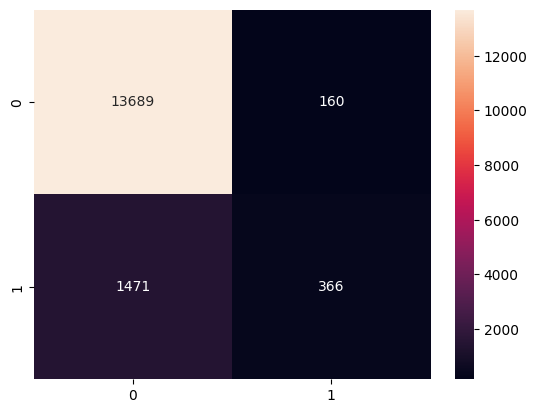

In [ ]:
sns.heatmap(confusion_matrix(y_test, tree_predictions), annot=True, fmt='d')

In [ ]:
df2.head(-1)

age  campaign  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0       56         1           1.1          93.994          -36.4      4.857   
1       57         1           1.1          93.994          -36.4      4.857   
2       37         1           1.1          93.994          -36.4      4.857   
3       40         1           1.1          93.994          -36.4      4.857   
4       56         1           1.1          93.994          -36.4      4.857   
...    ...       ...           ...             ...            ...        ...   
41181   37         1          -1.1          94.767          -50.8      1.028   
41182   29         1          -1.1          94.767          -50.8      1.028   
41183   73         1          -1.1          94.767          -50.8      1.028   
41184   46         1          -1.1          94.767          -50.8      1.028   
41185   56         2          -1.1          94.767          -50.8      1.028   

       nr.employed  job_admin.  job_blue-collar  job_entrepreneur  ...  \
0           5191.0           0                0                 0  ...   
1           5191.0           0                0                 0  ...   
2           5191.0           0                0                 0  ...   
3           5191.0           1                0                 0  ...   
4           5191.0           0                0                 0  ...   
...            ...         ...              ...               ...  ...   
41181       4963.6           1                0                 0  ...   
41182       4963.6           0                0                 0  ...   
41183       4963.6           0                0                 0  ...   
41184       4963.6           0                1                 0  ...   
41185       4963.6           0                0                 0  ...   

       pdays_21  pdays_22  pdays_25  pdays_26  pdays_27  pdays_999  \
0             0         0         0         0         0          1   
1             0         0         0         0         0          1   
2             0         0         0         0         0          1   
3             0         0         0         0         0          1   
4             0         0         0         0         0          1   
...         ...       ...       ...       ...       ...        ...   
41181         0         0         0         0         0          1   
41182         0         0         0         0         0          0   
41183         0         0         0         0         0          1   
41184         0         0         0         0         0          1   
41185         0         0         0         0         0          1   

       poutcome_failure  poutcome_nonexistent  poutcome_success  y  
0                     0                     1                 0  0  
1                     0                     1                 0  0  
2                     0                     1                 0  0  
3                     0                     1                 0  0  
4                     0                     1                 0  0  
...                 ...                   ...               ... ..  
41181                 0                     1                 0  1  
41182                 0                     0                 1  0  
41183                 0                     1                 0  1  
41184                 0                     1                 0  0  
41185                 0                     1                 0  0  

[39213 rows x 86 columns]

In [ ]:
feature_names = X.columns.tolist()

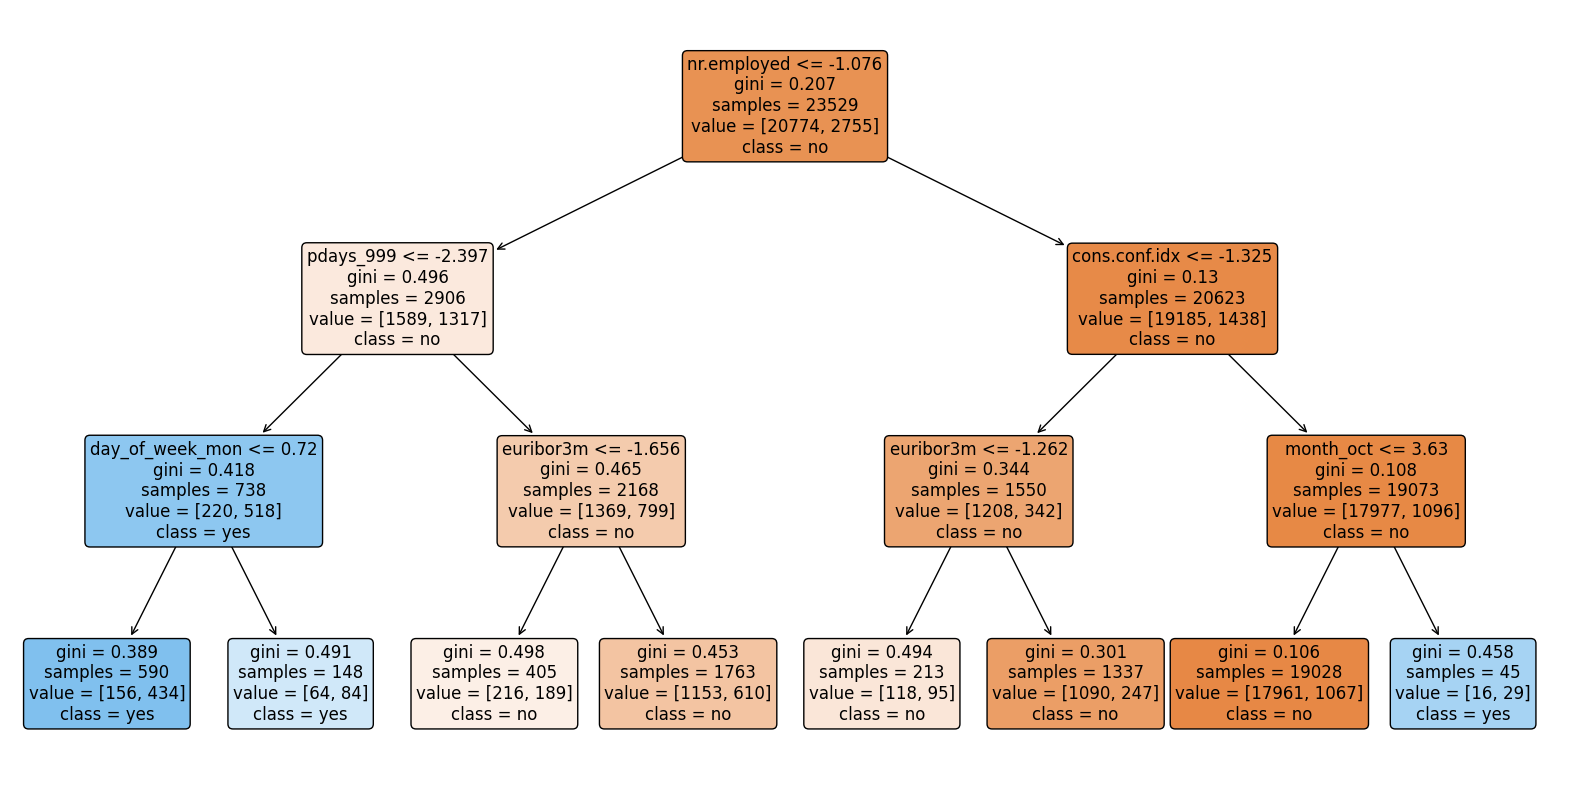

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(tree_model,
          feature_names=feature_names,
          class_names=['no', 'yes'],
          filled=True,
          rounded=True,
          fontsize=12)

plt.show()

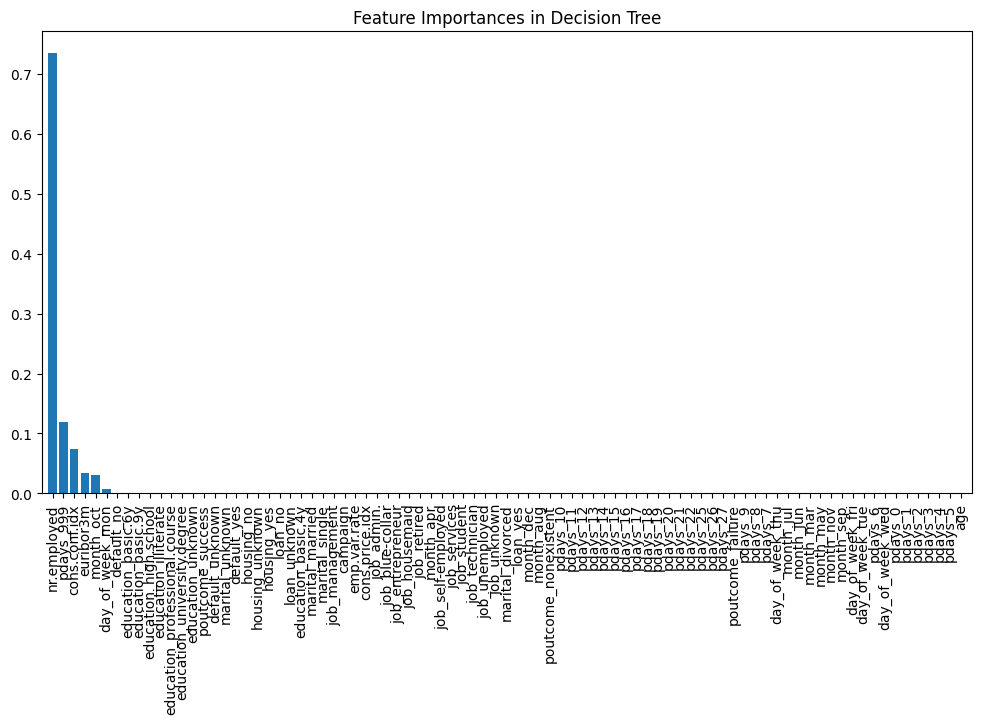

In [ ]:
# Get Feature Importances
importances = tree_model.feature_importances_
#Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

#Rearrange the feature names so they match the sorted importances
sorted_feature_names = [feature_names[i] for i in indices]

#Create the plot
plt.figure(figsize=(12,6))
plt.title("Feature Importances in Decision Tree")
plt.bar(range(X_train.shape[1]),importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), sorted_feature_names, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

---
### Random Forest


In [ ]:
X = df_standardized
y = df2['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, stratify = y, random_state = 19)

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=25,
    random_state=23,
    criterion='entropy'
)

In [ ]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=25, random_state=23)

In [ ]:
rf_predictions = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Decision Tree accuracy: {rf_accuracy}")
rf_report = classification_report(y_test, rf_predictions)
print(f"Decision Tree classification report: {rf_report}")

Decision Tree accuracy: 0.887288027540482
Decision Tree classification report:               precision    recall  f1-score   support

           0       0.91      0.97      0.94     13849
           1       0.54      0.26      0.35      1837

    accuracy                           0.89     15686
   macro avg       0.72      0.62      0.65     15686
weighted avg       0.87      0.89      0.87     15686



<Axes: >

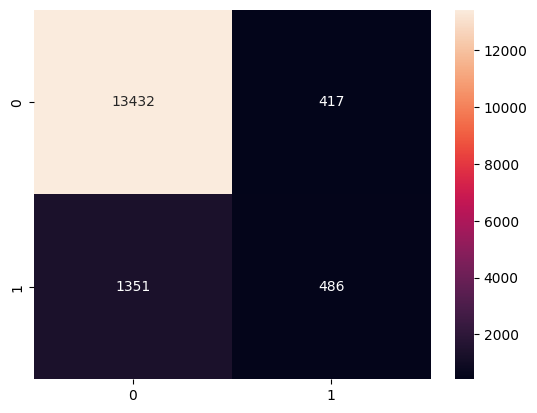

In [ ]:
sns.heatmap(confusion_matrix(y_test, rf_predictions), annot = True, fmt = 'd')

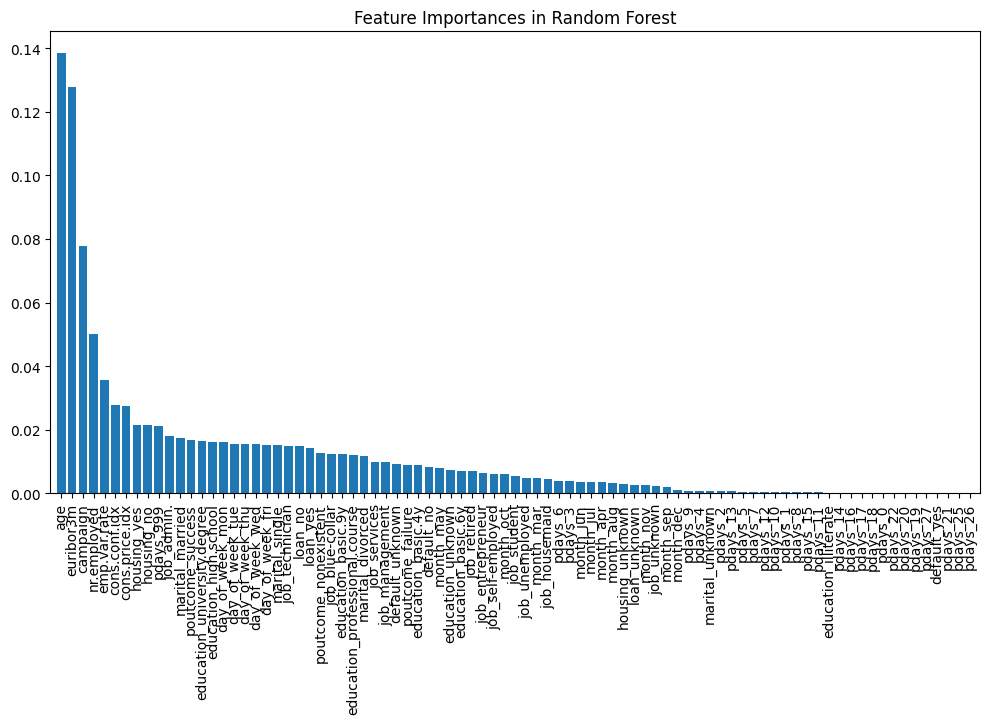

In [ ]:
# Get Feature Importances
importances = rf_model.feature_importances_
#Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

#Rearrange the feature names so they match the sorted importances
sorted_feature_names = [feature_names[i] for i in indices]

#Create the plot
plt.figure(figsize=(12,6))
plt.title("Feature Importances in Random Forest")
plt.bar(range(X_train.shape[1]),importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), sorted_feature_names, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

---
# Part 3: Conclusion and Analysis


In [ ]:
# Final Analysis
# This is mostly a workflow and thought process - to acquire more specific information (ie. feature selection) and code logic please visit the relative cell
'''
---

Preprocessing notes on both methods
We have dropped [duration] on both methods due to high impact on our target variable and instructed to do so in the dataset information
We have several features that were described as numerical however appears to be ordinal which is also categorical in nature
These variables that should be categorical are dates [pdays, day_of_week, months,] which uses dates which are categorical in nature, except for pdays which is contact times,
however they are ordered and 999 is used as an alias for not contacted which further suggests it is not numerical in nature.
We have also shown that pdays is categorical/ordinal using .unique() function which returns unique values and ignores recurring values which is important in a large dataset.
There are no outliers since the remaining features are categorical and quantitative.
The quantitative data are socio economic indicators in the form of ratios or percentages which are not categorical but numerical in nature.
Percentages are a way of expressing numerical values as a fraction of 100 and therefore should not contain any outliers.
Therefore, we have handled, missing data aka unknowns aka NaNs (there are no missing data in the whole dataset), duplicates, outliers, categorical conversion,
and numeric which are actually categorical in nature.


---
Load the necessary imports and dataset. EDA is independent of the two methods so we run this first. Further explained in the below sentence.

---
First Method
Then we take a quick look at the data using a for loop that iterates on the columns and plots them against each other using a histogram,
it takes the values of each columns as the x axis and returns the probability of it being a 1 == yes or 0 == no.
This gives us a good view on which variables to select and how our data looks like.
We select all the data in this method. This is because we want to test if the machine learning can determine which features are important by itself mainly in the neural network.
Then we take a look at the target variable, it is imbalanced. We have fixed this in the first part using imblearn package ROS or
Random Over Sampler which oversamples or creates synthetic data for the minority class.
We drop the duplicates and duration column as per attribute information on cell 1.
We convert the numerical but actually ordinal/categorical features into categorical dtype. We confirm this using .unique() function
We convert the y var into binary and proceed with creating our dummy variables for our categorical columns.
We then train valid test split the data. Valid is used in deep neural nets. It is a pre testing portion similar to test that is used as a reality check during training or hyperparameter tuning.

SVM and NN yielded the highest accuracy with 84 and 85 respectively, however NNs are not reliable and may change as the optimizer it uses is inherently stochastic (random). This is also the case
for Naive Bayes which yielded a result of 89%, 90%, and 12% on several reruns on the whole dataset. It maybe due to the stochastic nature of sampling, and ML model imports
may choose different parameters on each run. Yielding different results every time. This is normal for machine learning. And it is addressed in the second method by using a seed parameter.

---
Second Method
In the second method we use variable selection to choose our features. The logic is stated on the preprocessing cell for the second methodology
We only drop 3 features which are contact, duration, and previous. The logic is stated on the cells above.
We have then chosen the rest of the data and perform the same preprocessing except we do not choose a valid dataset to split and use a 60:40 ratio for consistency on our first method (60:20:20).
Preprocessing of data is the same except for the code syntax.
We have also chosen a different imbalanced data set method which is stratify.

Here the Logistic regression yielded a 90% accuracy rate which is mainly due to the inclusion of the variable [nr.employed]. 90% is greater than the imbalance 88%.
This can be explained by feature selection which was used on the second method and not on the computation of the 88% EDA cell prior to the first method.
Feature selecting [nr.employed] as one of the highest predictors when plotted in a correlation map is significant to both the imbalance and accuracy. This suggests it is highly correlated as well.

In a financial context, being employed is a good predictor for a person taking out a term deposit for a bank. Therefore, banks should look for this information when making term deposit decisions.

-> To concluded, logistic regression yielded the highest score with 90% accuracy and 403 true positives. This is on the second method.
Random Forest yielded a higher True Positive of 483 however 89% accuracy. Therefore, both methods should be considered when doing classification analysis.
However, since our goal is to increase True Positive, while accuracy is important we would use this as a second metric. Therfore, Random Forest is our Base Model

Further, domain knowledge via feature selection [nr.employed] is a good method for getting the right predictors.

Notes:
Encountered error on overfitting 0.99% accuracy. Determined it was an error with the dataframe wherein the target column has shifted to the middle of the datasetwhen performing one hot encoding.
Fixed it by df.pop() and bringing it back by pd.concat

'''

---

In [ ]:
# END of Capstone;

---
# Appendix


---
### Preprocessing

In [ ]:
# This portion is only intended for future reference on Clustering, violin plots, and Agglomerative Clustering Methods and is irrelevant from the Capstone Analysis however they both use the same dataset

In [ ]:
my_report = sv.analyze(df)
my_report.show_html()
# Check colab file tab on top left bottom portion for the html file

In [ ]:

# Select columns with data type 'object' (typically used for categorical variables)
categorical_columns = df.select_dtypes(include=['object', 'category'])


# One-hot encode the categorical columns
one_hot_encoded = pd.get_dummies(categorical_columns, drop_first=True)

# Concatenate the one-hot encoded columns with the original DataFrame
df_encoded = pd.concat([df, one_hot_encoded], axis=1)

# Drop the original categorical columns since they are now one-hot encoded
df_encoded.drop(categorical_columns.columns, axis=1, inplace=True)



In [ ]:
# Standard scaling
scaler = StandardScaler()

# Fit scaler on df
df_scaled = scaler.fit_transform(df_encoded)

# reinitialize DF structure
df_standardized = pd.DataFrame(df_scaled, columns=df_encoded.columns)

---
### Kmeans Clustering Elbow Method

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

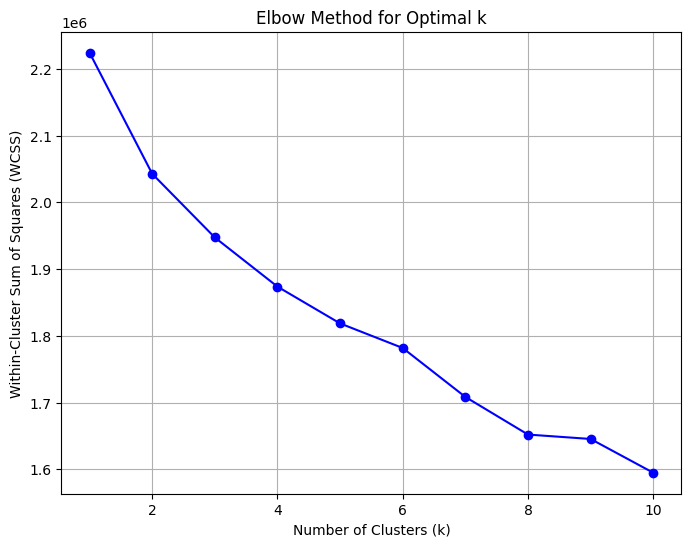

In [ ]:
# Kmeans Elbow method

# Turns the dataframe into Nunpy Arrays
X = df_standardized.values

# Initialize a list to store the WCSS values for different k
wcss = []

# Define a range of k values to test
k_range = range(1, 11)  # You can adjust the range as needed

# Perform K-Means clustering for each k and calculate WCSS
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


In [ ]:
# K means

# After the elbow method, it seems that the elbow maybe 5 or 8
k = 5

#Create a final dataframe to hold the results of the clusters
df_final = df_standardized.copy()

# # Fit K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
df_final['cluster'] = kmeans.fit_predict(df_standardized)  # Replace with your feature names

# # Obtain cluster centers
# cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_final.columns.to_list())

# Calculate feature importance (variance within clusters)
variance_within_clusters = df_final.groupby('cluster').var()

df_final.groupby('cluster').mean()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


age  duration  campaign     pdays  previous  emp.var.rate  \
cluster                                                                   
0        0.026988 -0.008164  0.086825  0.195414 -0.349329      0.712499   
1        0.098977 -0.098911 -0.039143  0.195414 -0.188859      0.448399   
2       -0.059308  0.021516 -0.159733  0.195414  0.305736     -1.340962   
3        0.175060  0.243286 -0.269163 -5.110260  3.016447     -1.385925   
4       -0.111919  0.050525  0.241214  0.195414 -0.349494      0.839061   

         cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  \
cluster                                                         ...   
0              1.012401       0.463674   0.728348     0.516156  ...   
1             -0.399814       0.429734   0.574165     0.662263  ...   
2             -1.014405      -0.578333  -1.394893    -1.234947  ...   
3             -0.401051       0.467098  -1.519504    -1.908070  ...   
4              0.591424      -0.474791   0.772760     0.845170  ...   

         month_nov  month_oct  month_sep  day_of_week_mon  day_of_week_thu  \
cluster                                                                      
0        -0.332532  -0.092501  -0.118462        -0.027053        -0.075122   
1         1.033507  -0.132325  -0.118462        -0.044778         0.037642   
2        -0.240895   0.181280   0.171925         0.048435         0.013501   
3         0.085763   0.657583   0.795659        -0.004200         0.041163   
4        -0.332532  -0.133197  -0.118462         0.021846         0.054213   

         day_of_week_tue  day_of_week_wed  poutcome_nonexistent  \
cluster                                                           
0               0.004936         0.022002              0.397467   
1               0.019083         0.024394              0.166199   
2              -0.044013        -0.049739             -0.428208   
3               0.038223        -0.005935             -2.514421   
4               0.036506         0.018718              0.397706   

         poutcome_success     y_yes  
cluster                              
0               -0.185700 -0.234501  
1               -0.185700 -0.191212  
2               -0.185700  0.258801  
3                4.856233  1.659831  
4               -0.185700 -0.163746  

[5 rows x 54 columns]

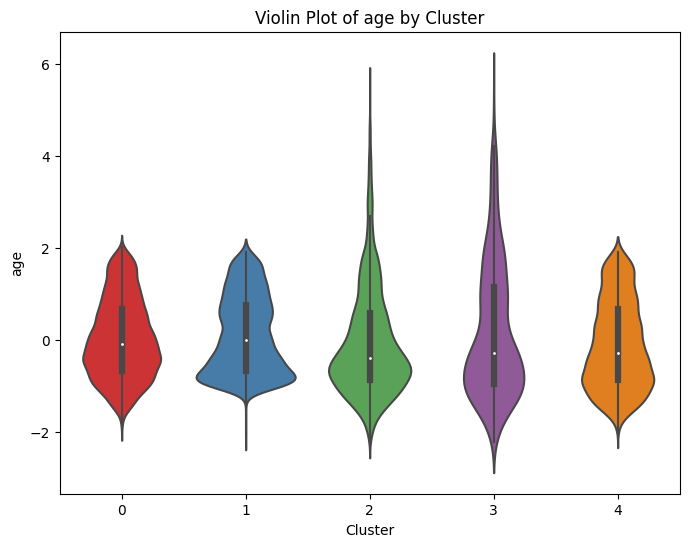

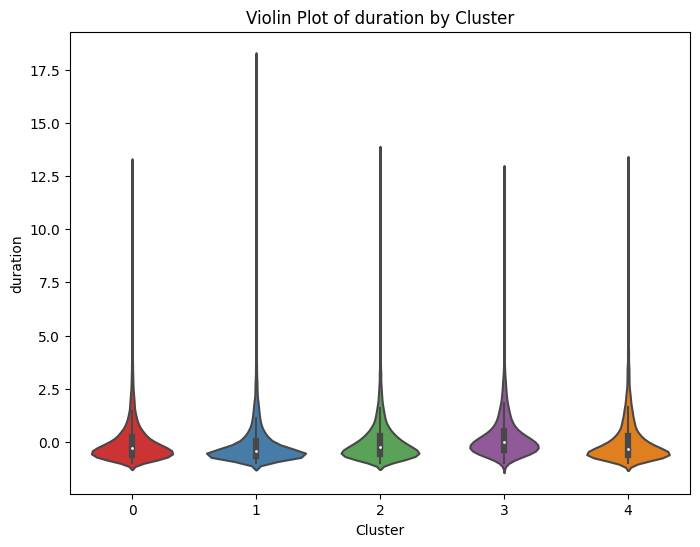

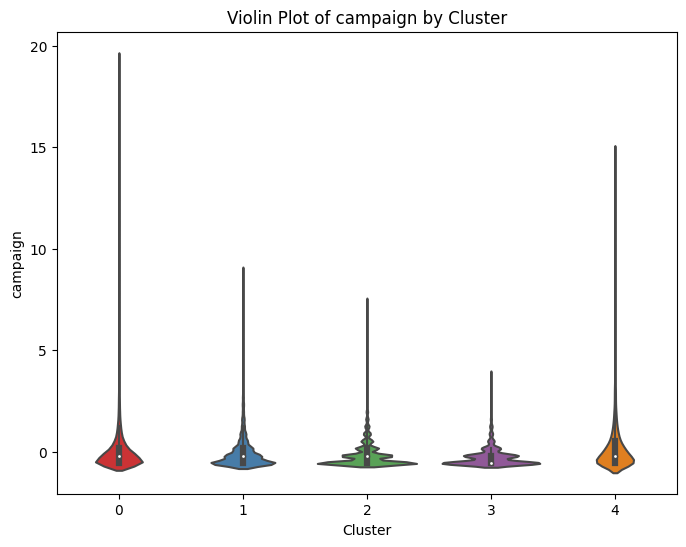

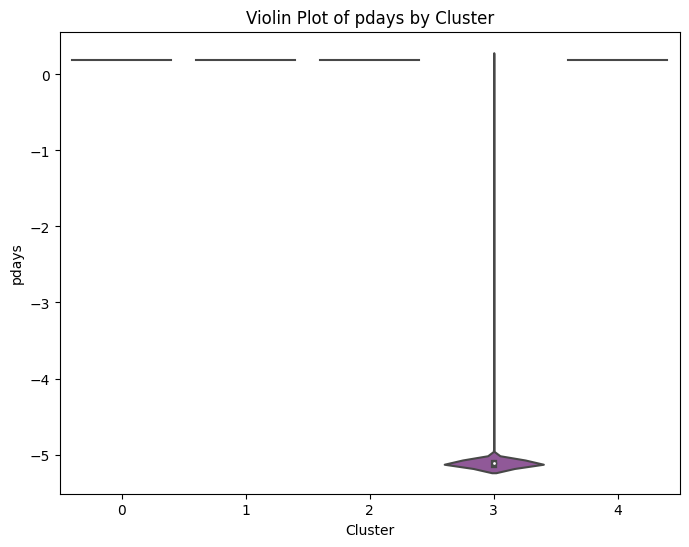

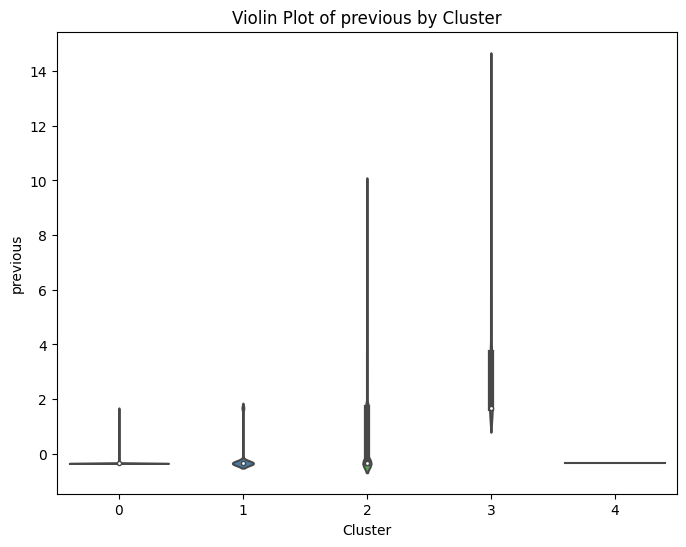

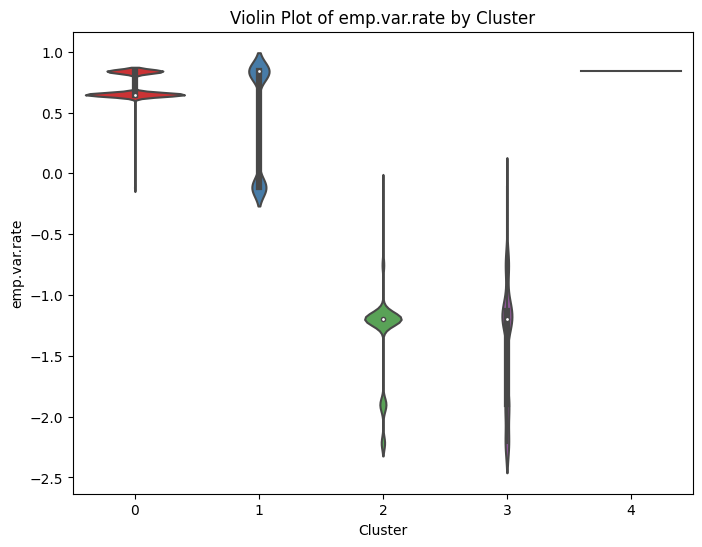

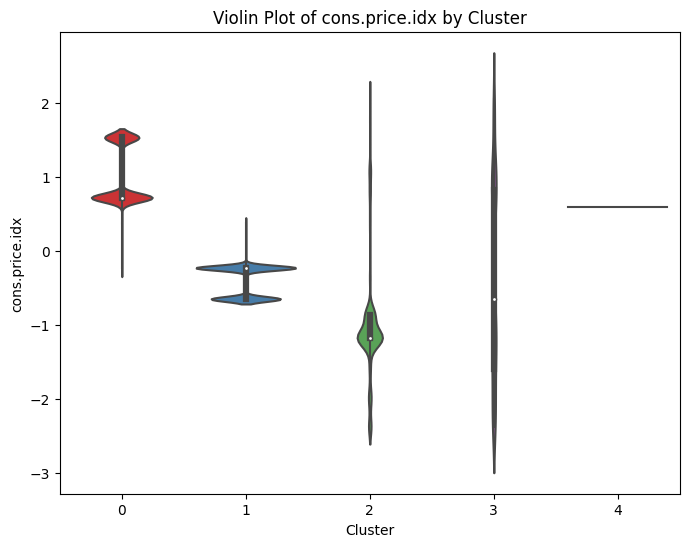

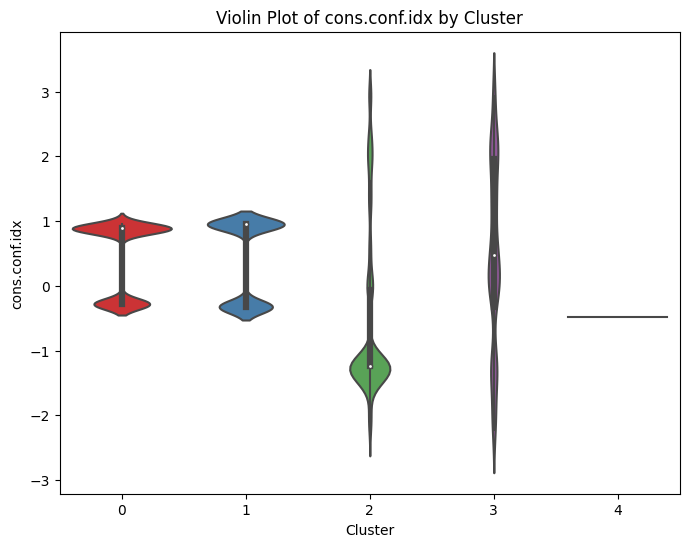

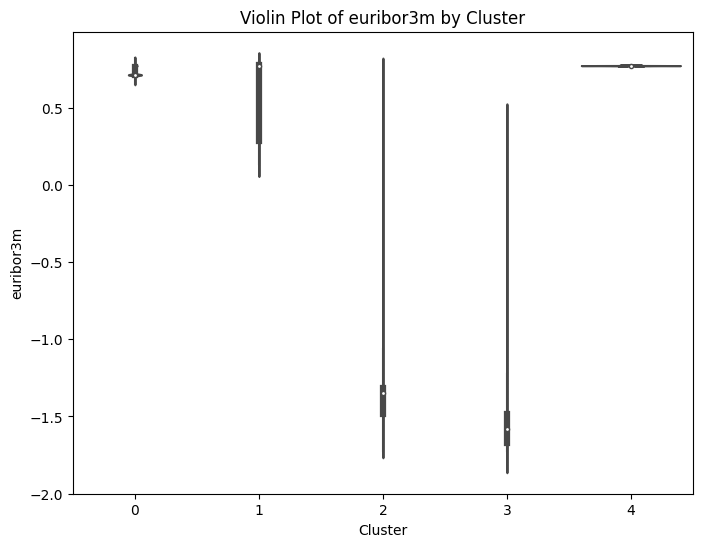

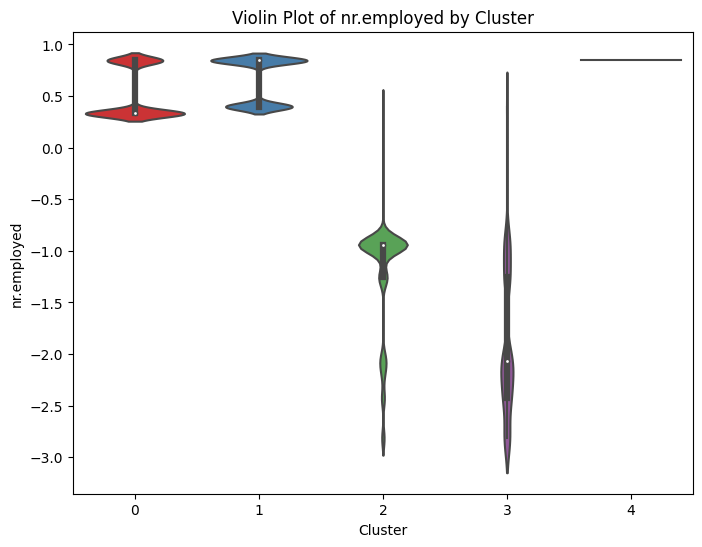

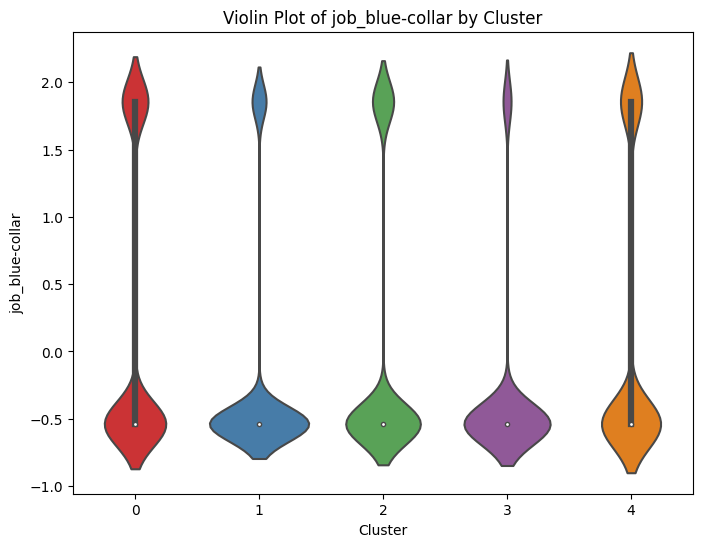

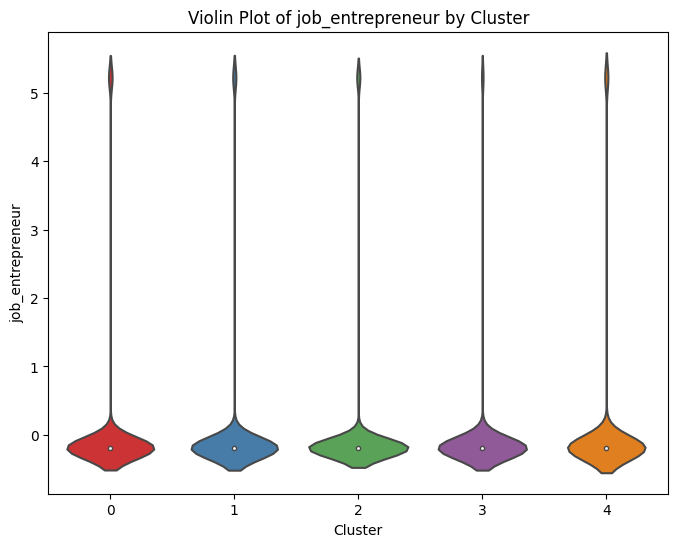

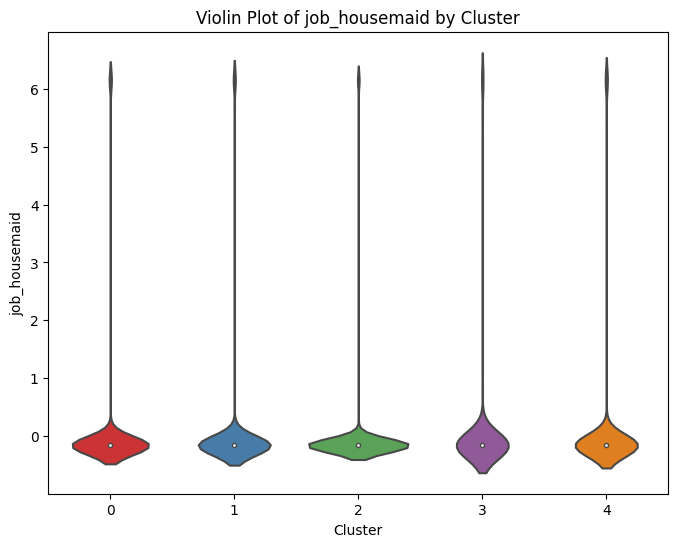

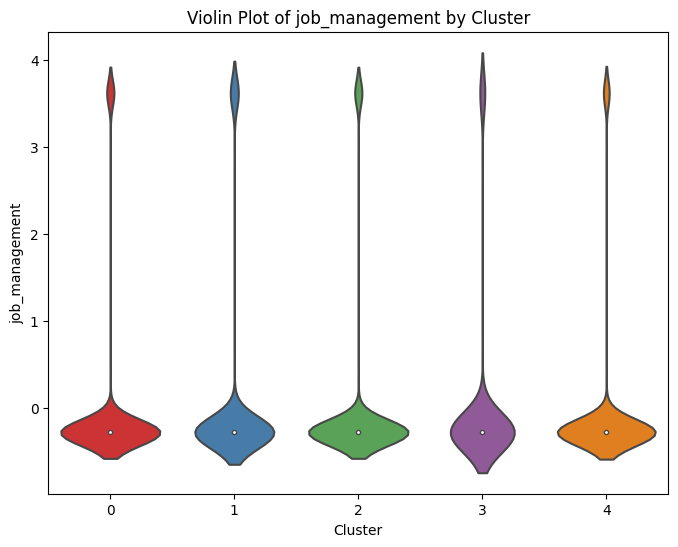

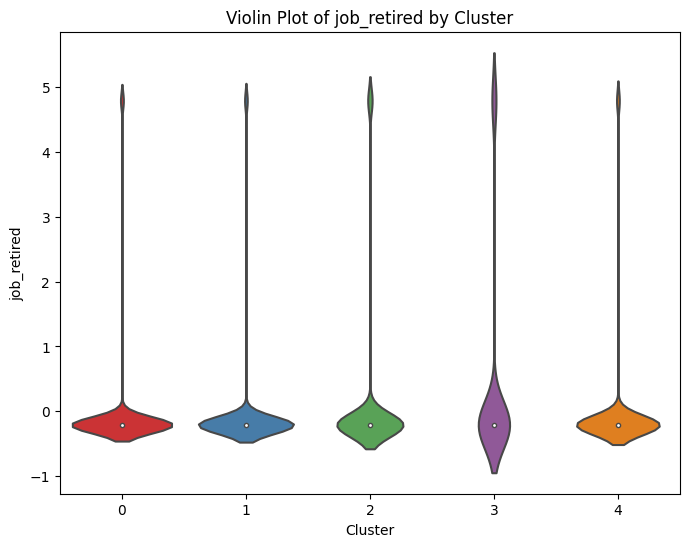

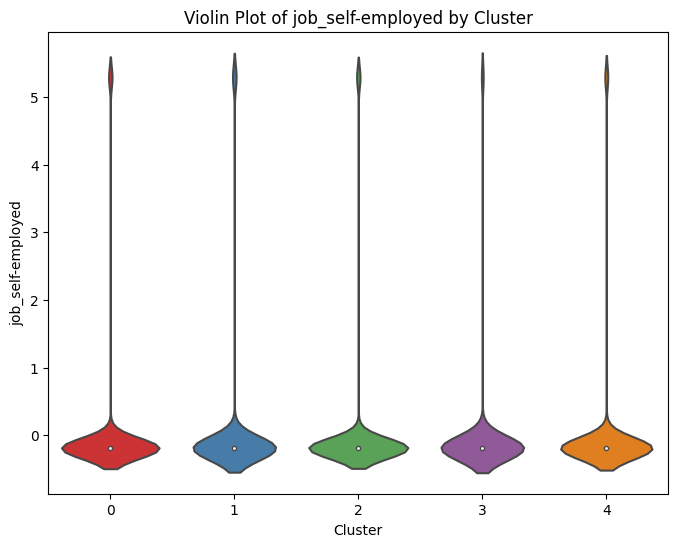

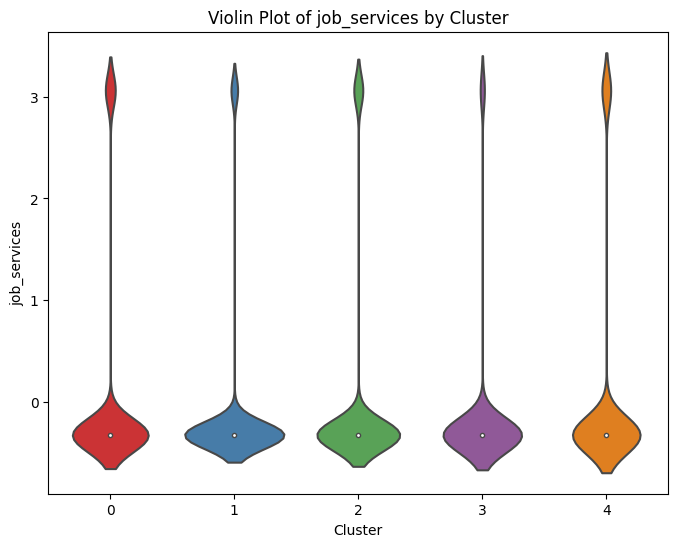

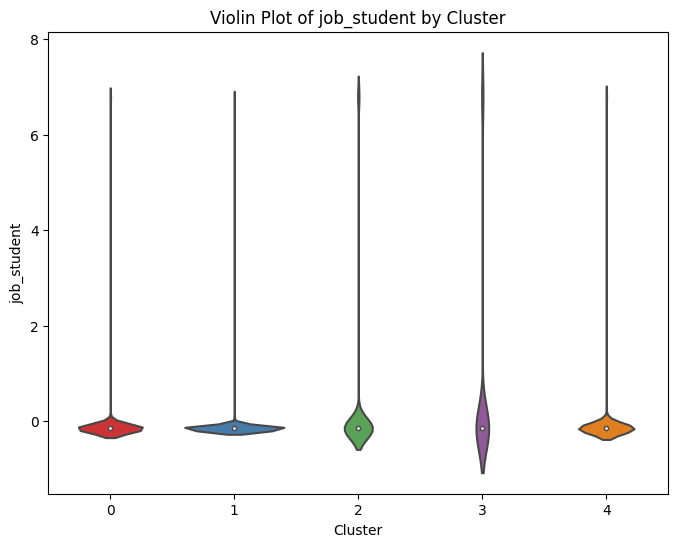

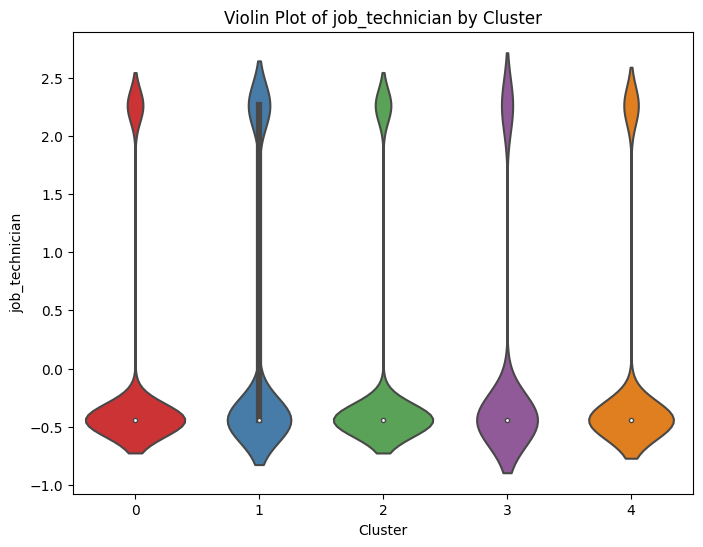

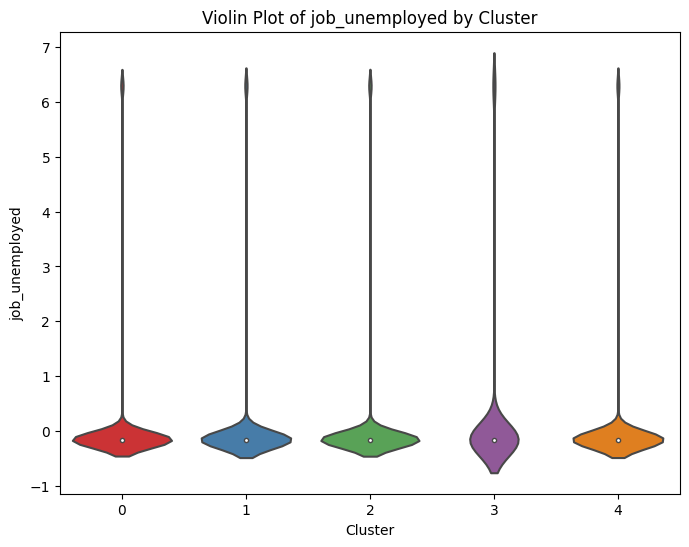

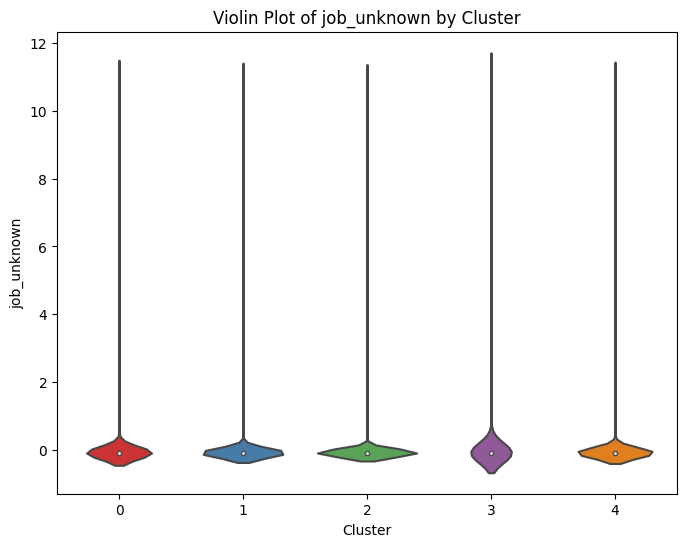

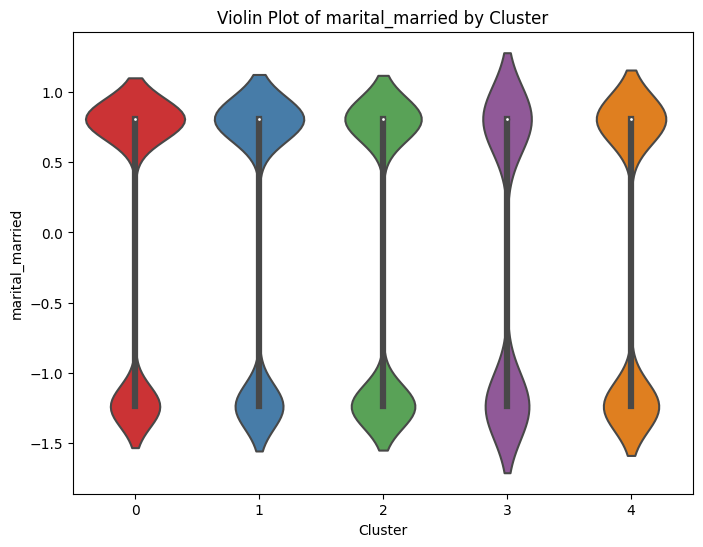

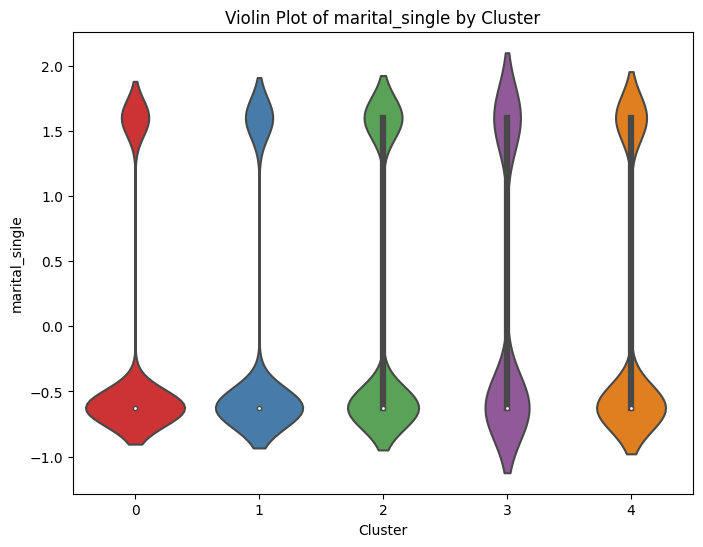

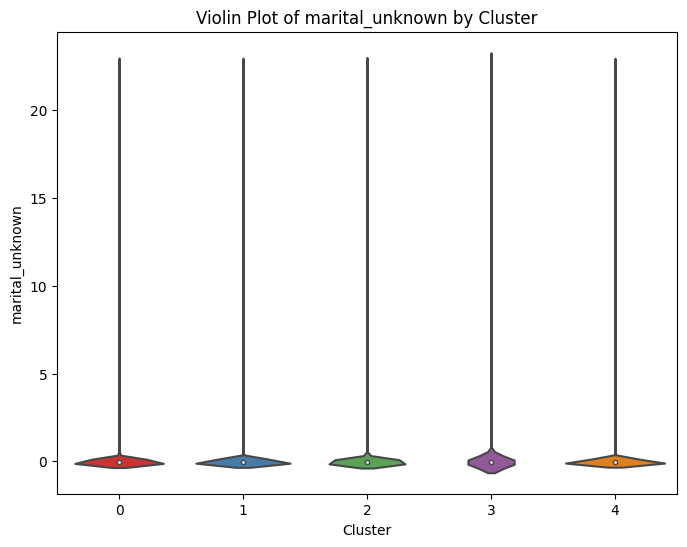

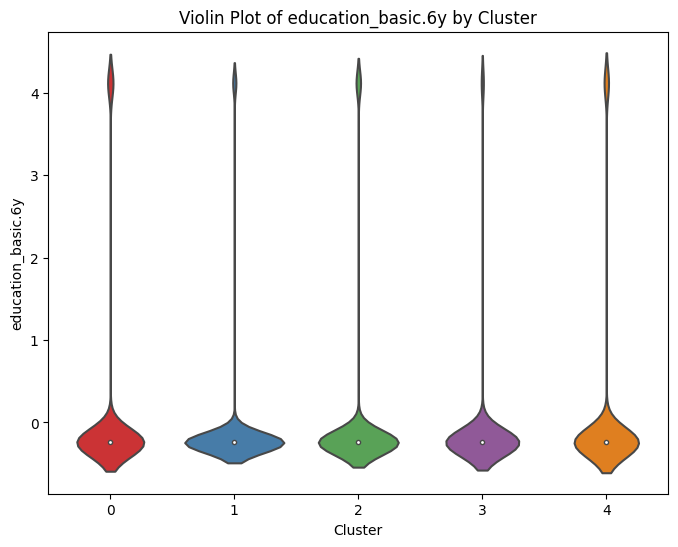

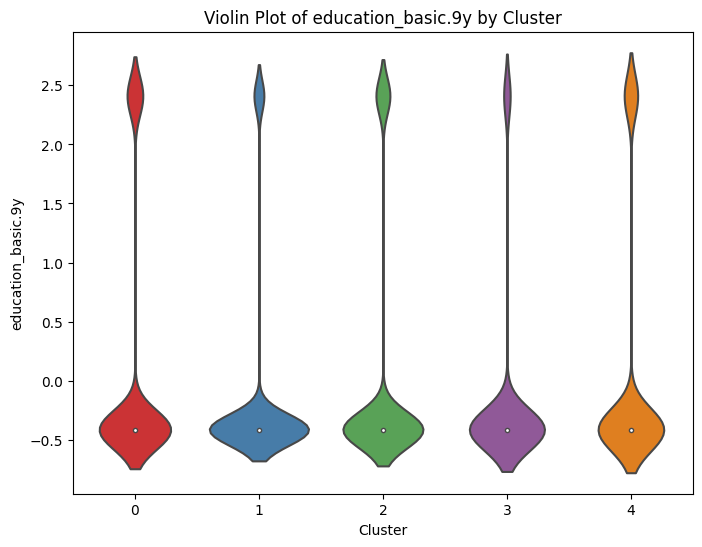

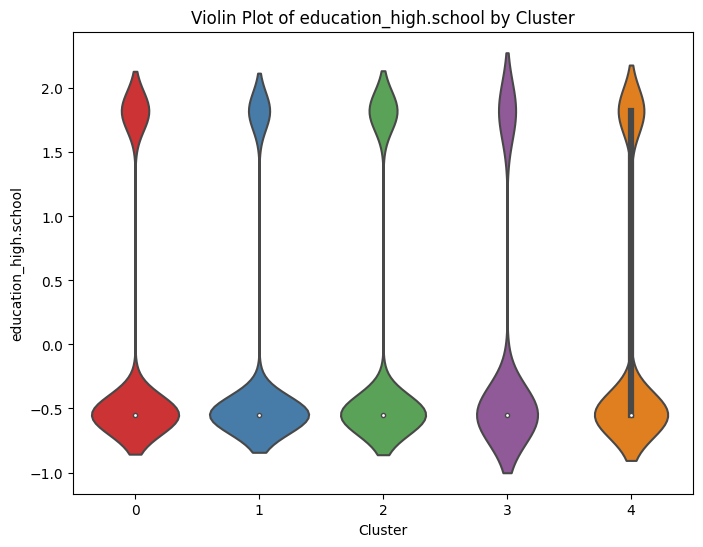

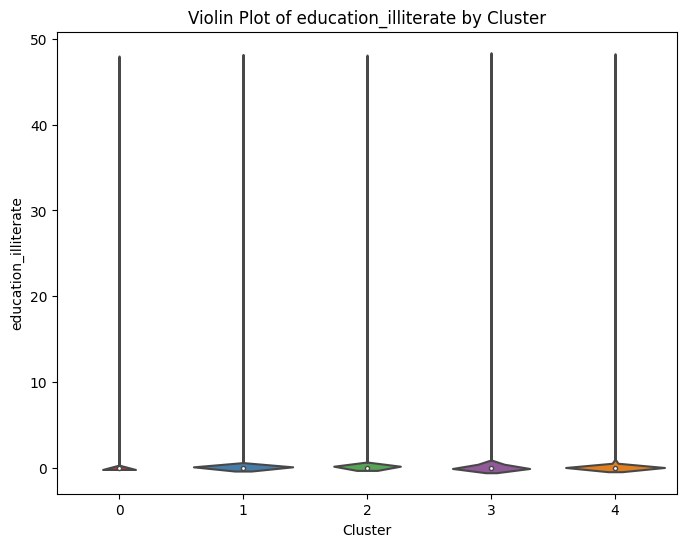

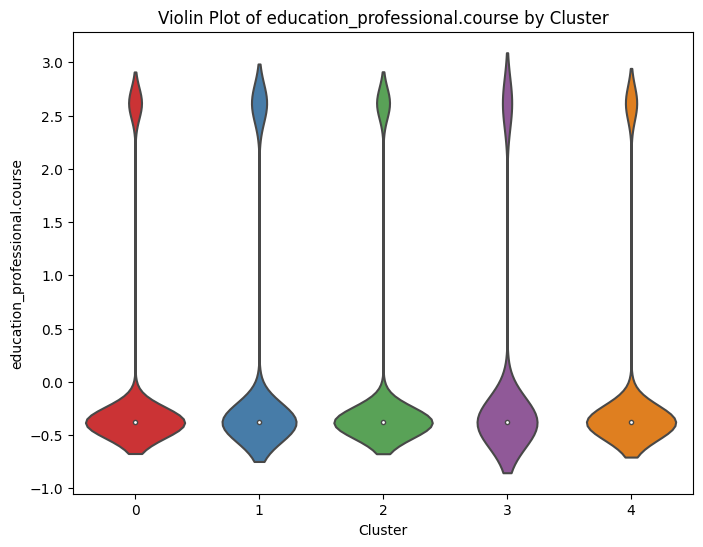

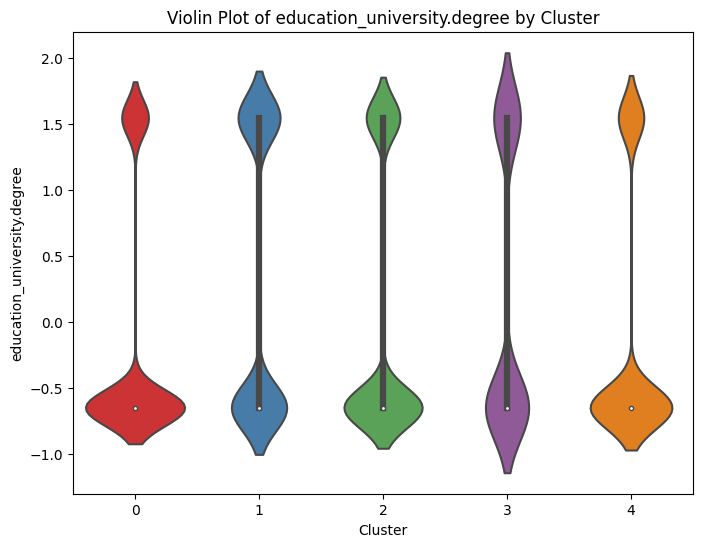

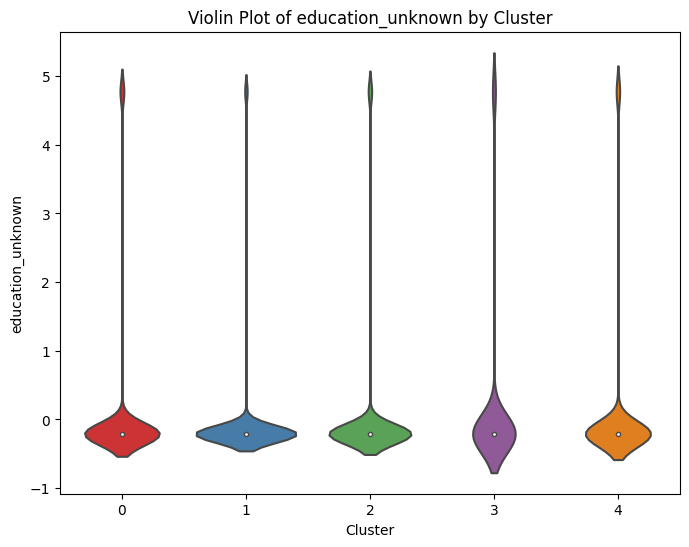

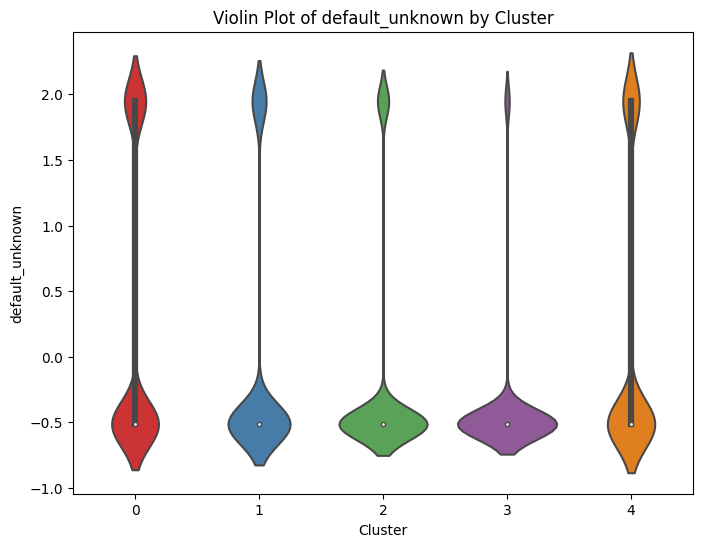

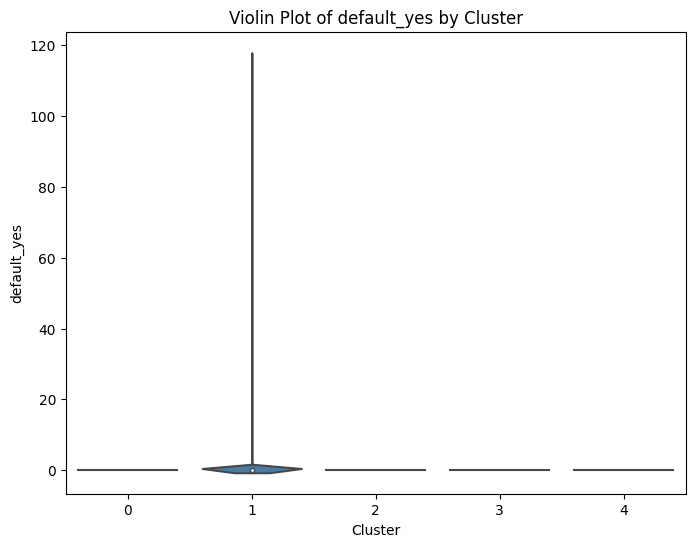

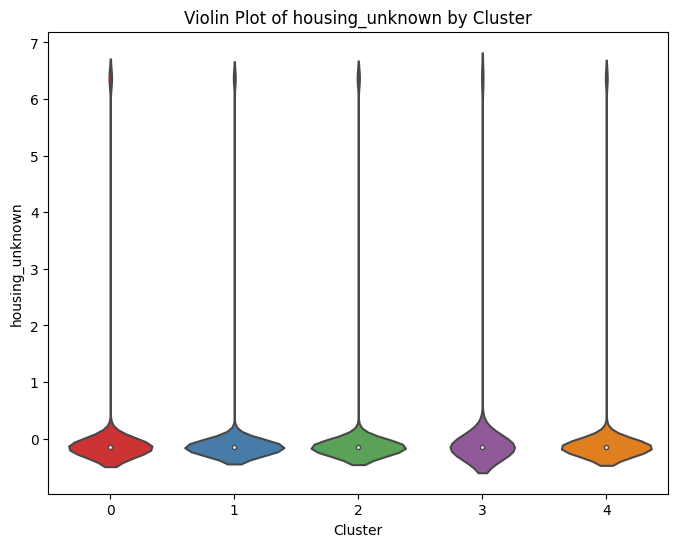

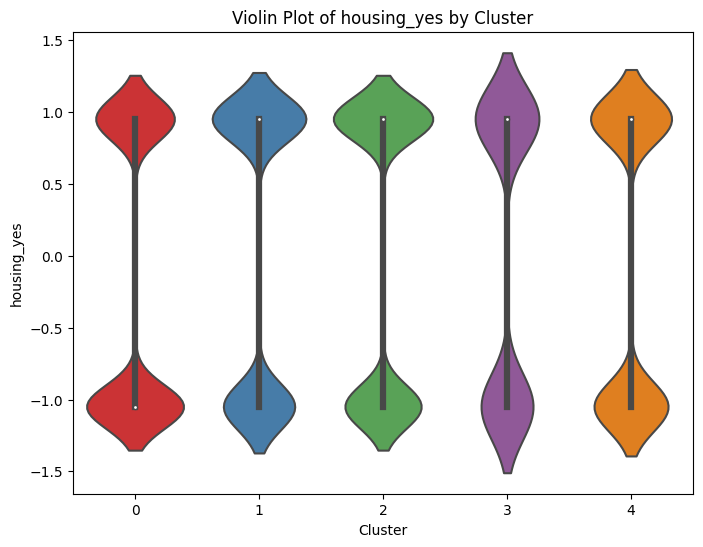

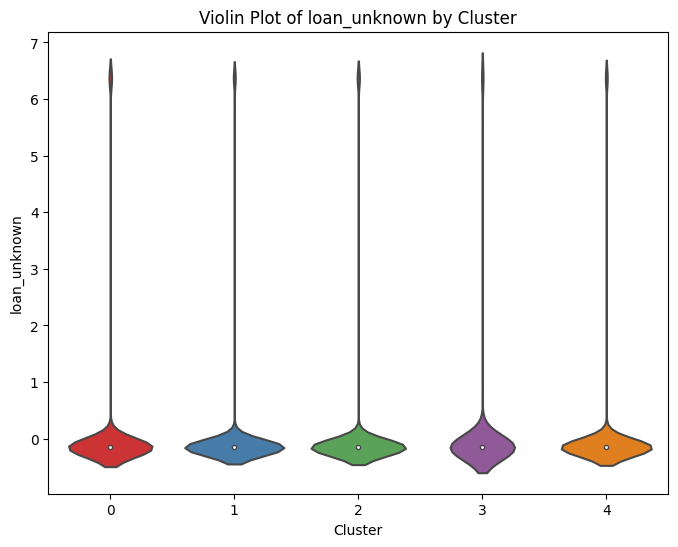

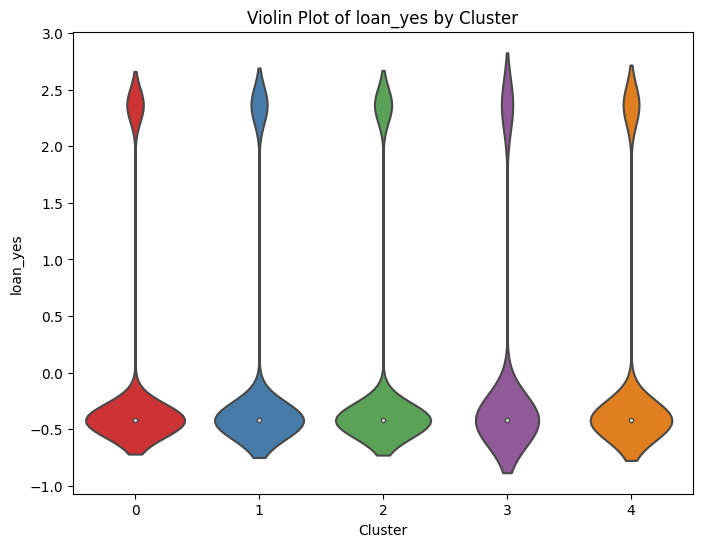

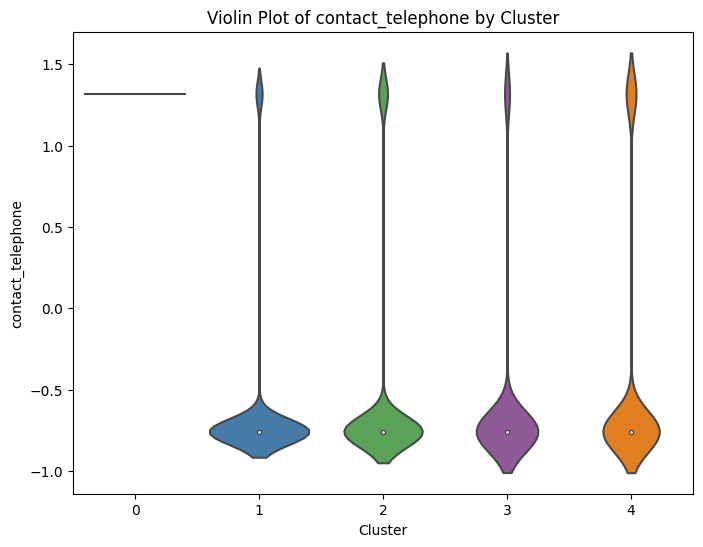

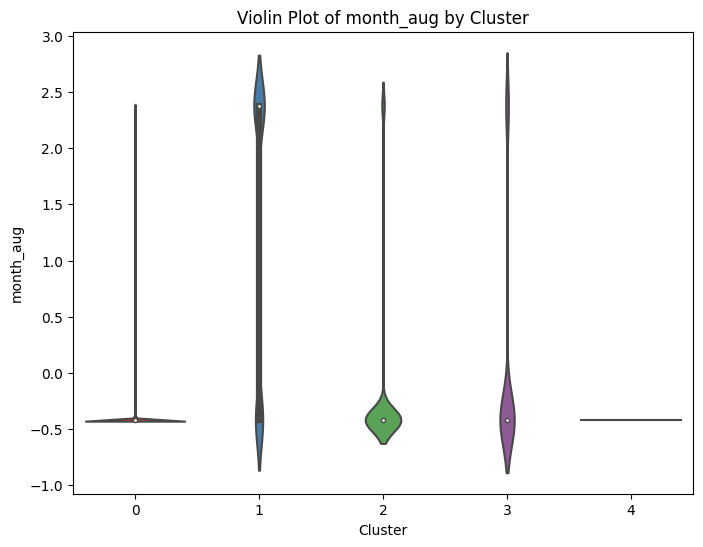

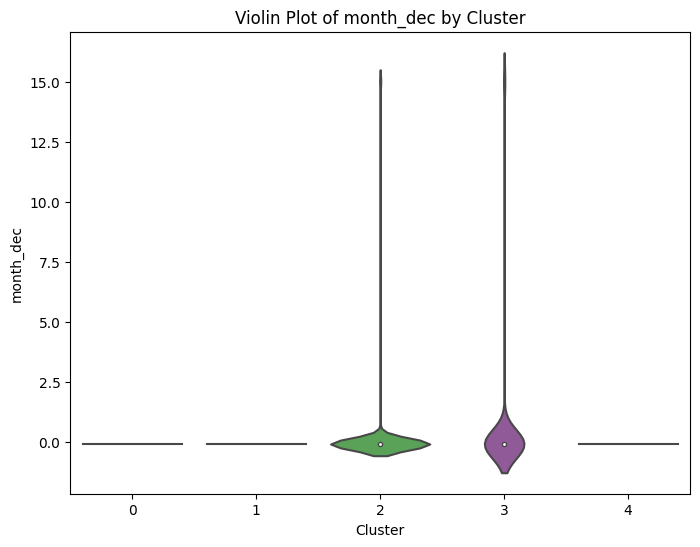

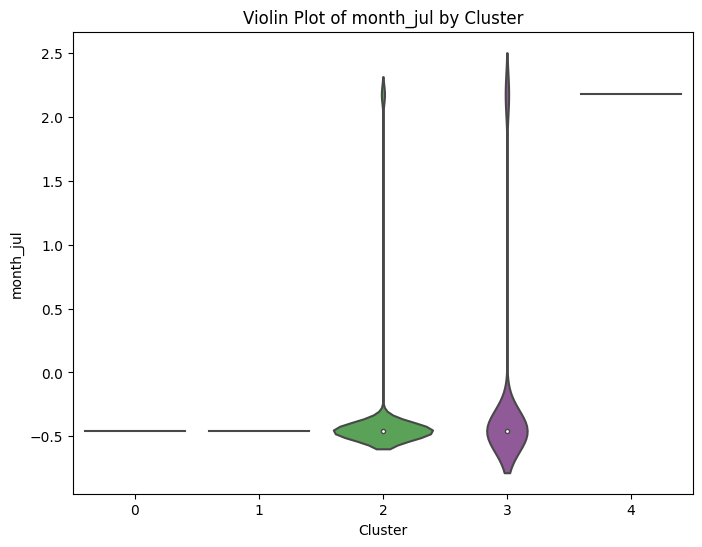

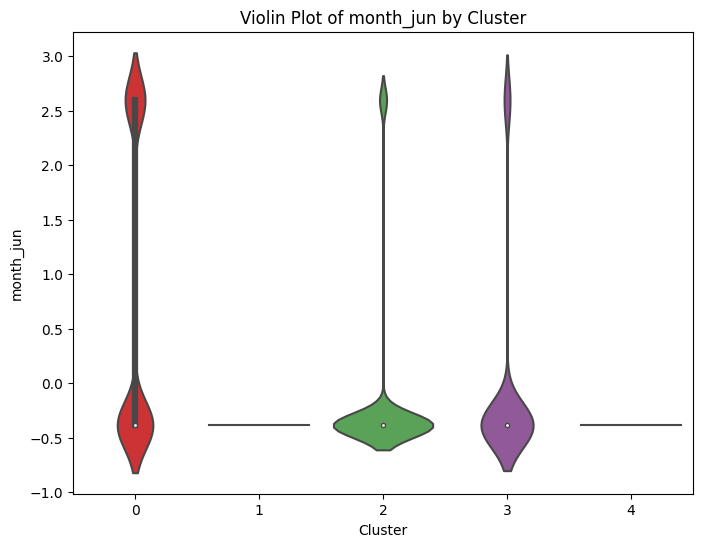

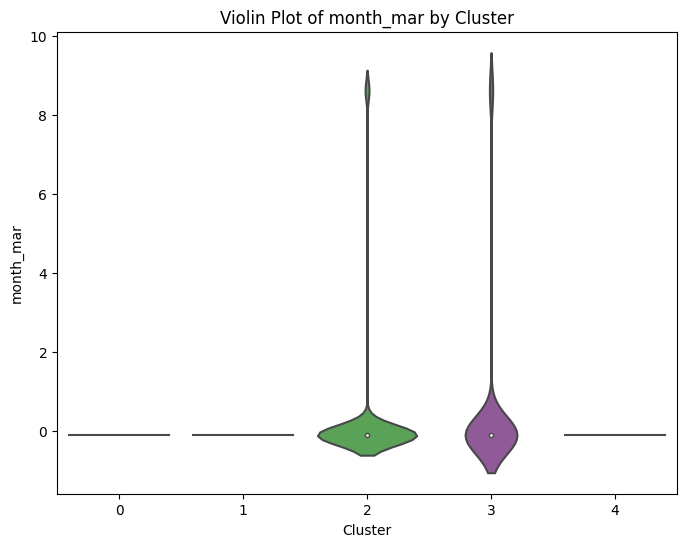

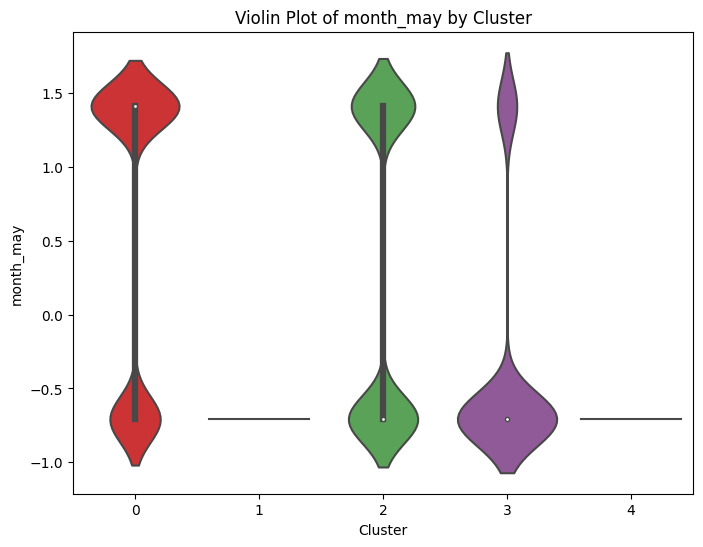

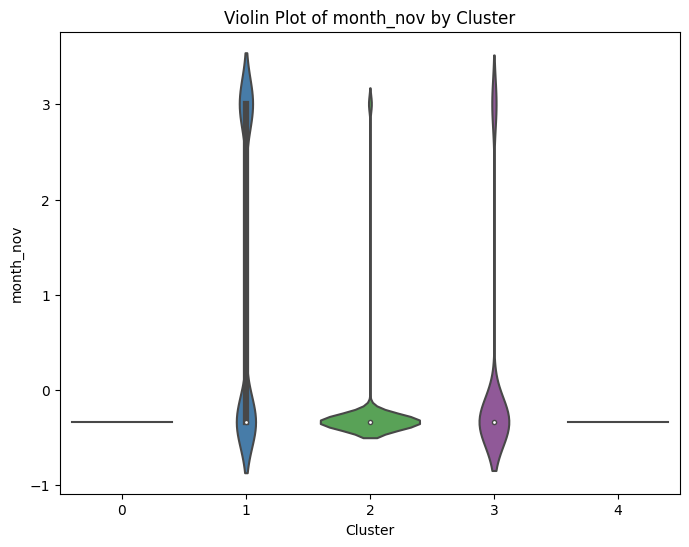

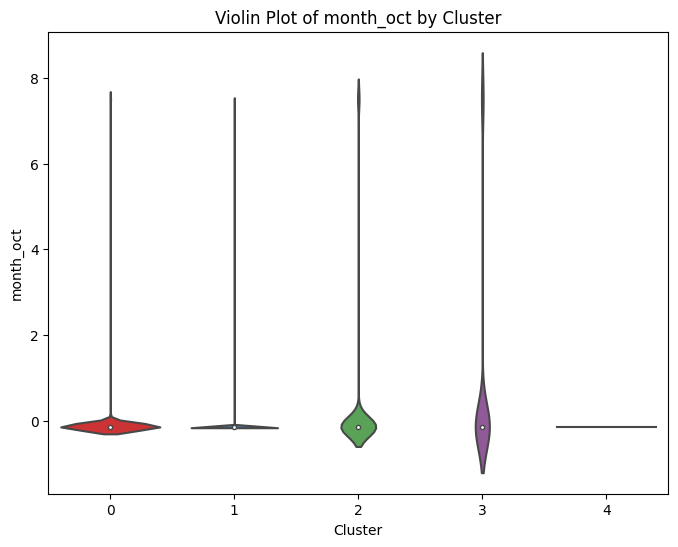

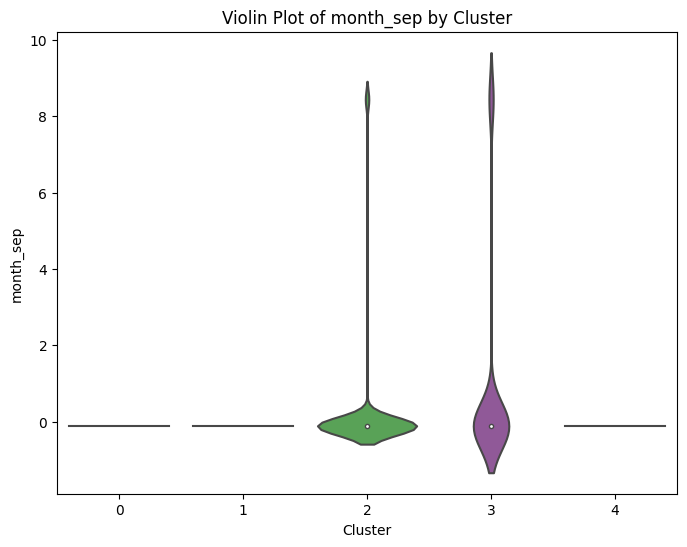

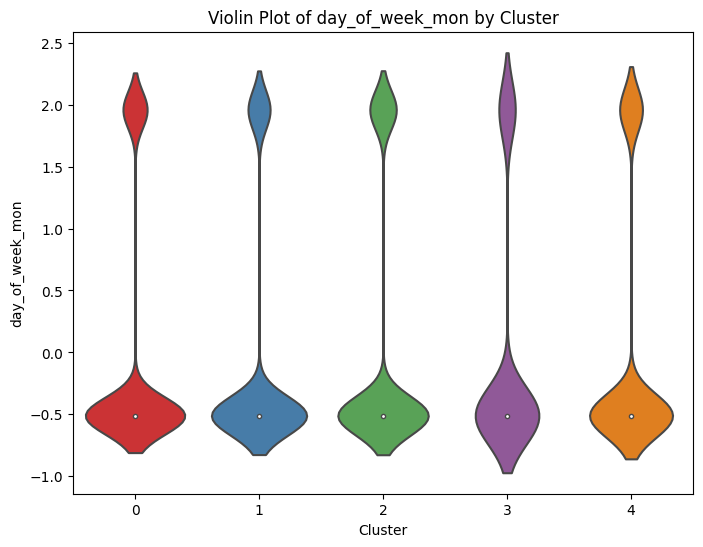

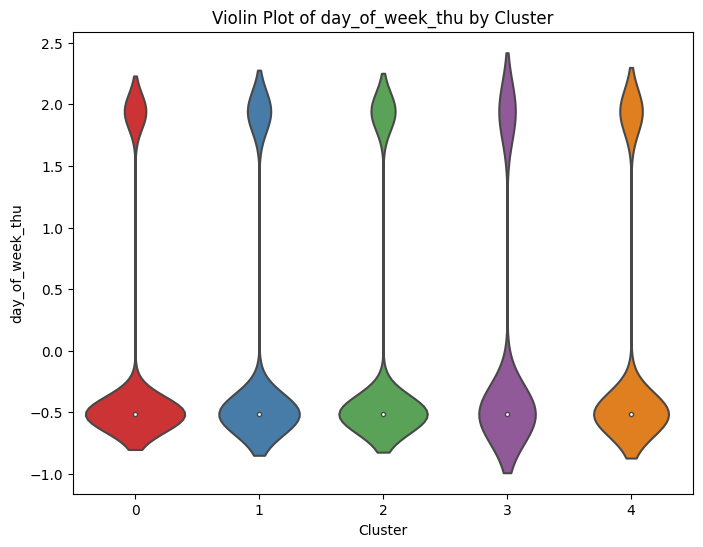

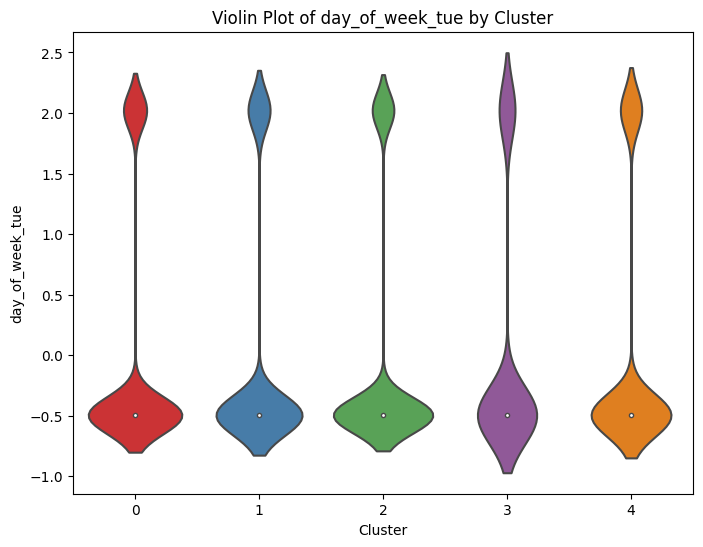

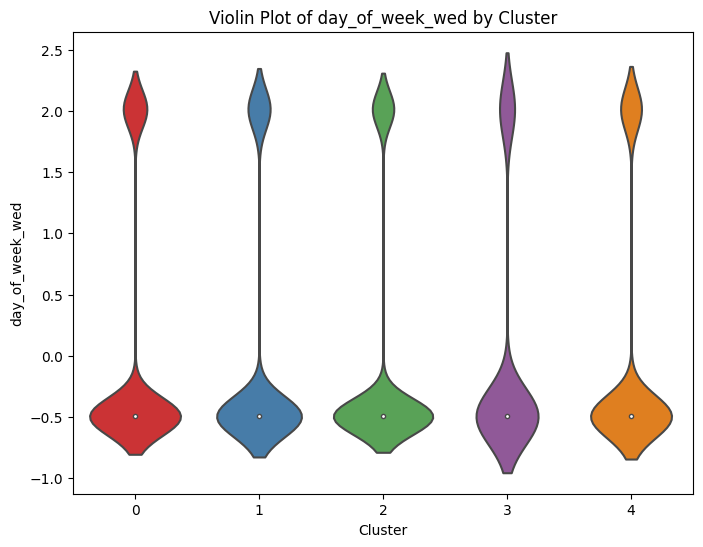

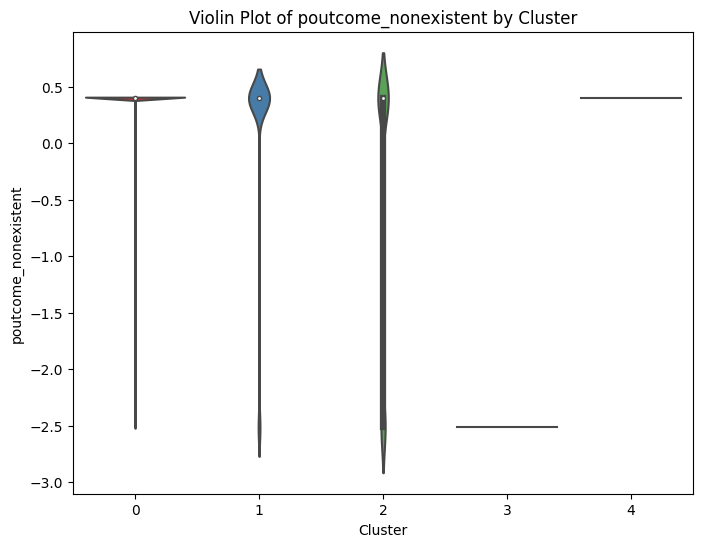

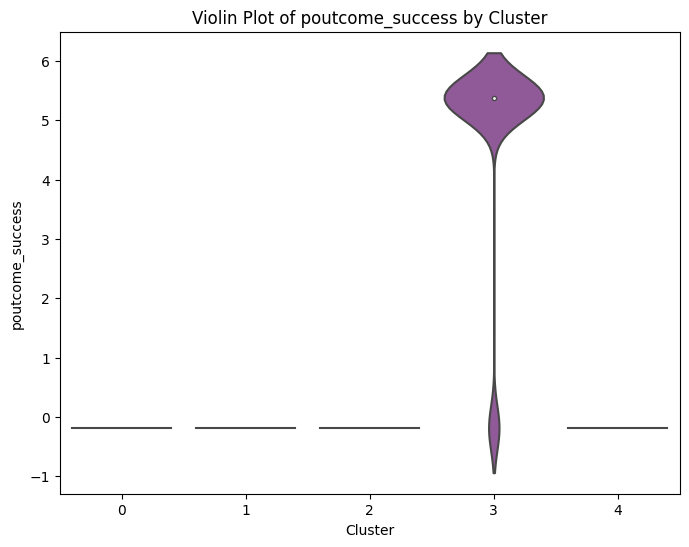

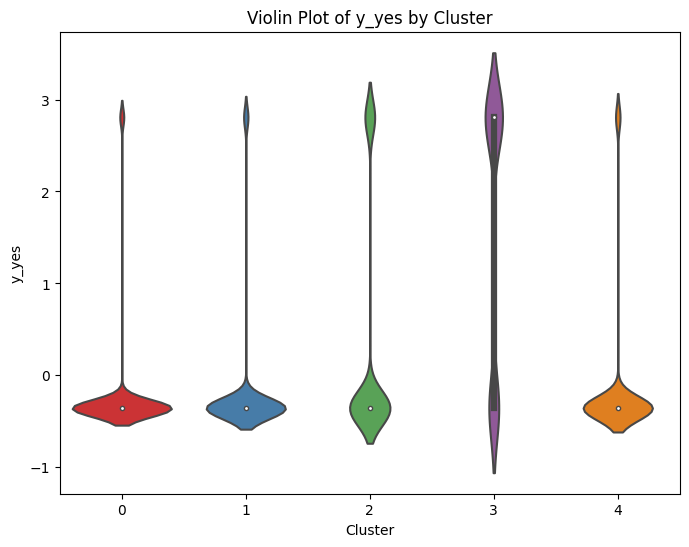

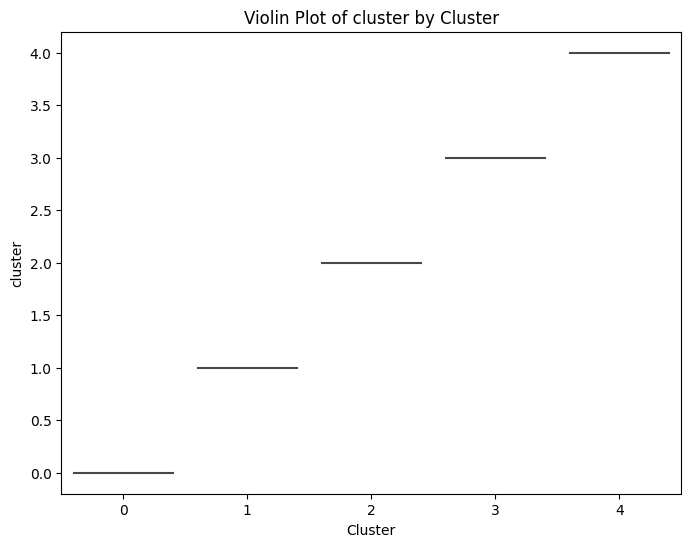

In [ ]:
# Data Visualization

# List of features to create violin plots for
features_to_plot = df_final.columns.to_list()  # Replace with your feature names

for feature in features_to_plot:
    try:
        # Assuming 'df_final' DataFrame is properly prepared
        plt.figure(figsize=(8, 6))
        sns.violinplot(x='cluster', y=feature, data=df_final, palette='Set1')
        plt.title(f'Violin Plot of {feature} by Cluster')
        plt.xlabel('Cluster')
        plt.ylabel(feature)
        plt.show()
    except Exception as e:
        print(f"An error occurred: {str(e)}")



---
### Agglomerative Clustering

In [ ]:
# Agglomerative Clustering
# aka Heirarchal Cluster

k = 5
df_final = df_standardized.copy()


 # Statistics within clusters
kmeans = KMeans(n_clusters=k, random_state=42)
df_final['cluster'] = kmeans.fit_predict(df_standardized)

variance_within_clusters = df_final.groupby('cluster').var()
df_final.groupby('cluster').mean()

def hierarchical_cluster_dataframe(df, k):
    df_final = df.copy()

    # Hierarchical Clustering
    hierarchical_clustering = AgglomerativeClustering(n_clusters=k)
    df_final['cluster'] = hierarchical_clustering.fit_predict(df)
    return df_final
df_final

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


age  duration  campaign     pdays  previous  emp.var.rate  \
0      1.533034  0.010471 -0.565922  0.195414 -0.349494      0.648092   
1      1.628993 -0.421501 -0.565922  0.195414 -0.349494      0.648092   
2     -0.290186 -0.124520 -0.565922  0.195414 -0.349494      0.648092   
3     -0.002309 -0.413787 -0.565922  0.195414 -0.349494      0.648092   
4      1.533034  0.187888 -0.565922  0.195414 -0.349494      0.648092   
...         ...       ...       ...       ...       ...           ...   
41183  3.164336  0.292025 -0.565922  0.195414 -0.349494     -0.752343   
41184  0.573445  0.481012 -0.565922  0.195414 -0.349494     -0.752343   
41185  1.533034 -0.267225 -0.204909  0.195414 -0.349494     -0.752343   
41186  0.381527  0.708569 -0.565922  0.195414 -0.349494     -0.752343   
41187  3.260295 -0.074380  0.156105  0.195414  1.671136     -0.752343   

       cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month_oct  \
0            0.722722       0.886447   0.712460     0.331680  ...  -0.133197   
1            0.722722       0.886447   0.712460     0.331680  ...  -0.133197   
2            0.722722       0.886447   0.712460     0.331680  ...  -0.133197   
3            0.722722       0.886447   0.712460     0.331680  ...  -0.133197   
4            0.722722       0.886447   0.712460     0.331680  ...  -0.133197   
...               ...            ...        ...          ...  ...        ...   
41183        2.058168      -2.224953  -1.495186    -2.815697  ...  -0.133197   
41184        2.058168      -2.224953  -1.495186    -2.815697  ...  -0.133197   
41185        2.058168      -2.224953  -1.495186    -2.815697  ...  -0.133197   
41186        2.058168      -2.224953  -1.495186    -2.815697  ...  -0.133197   
41187        2.058168      -2.224953  -1.495186    -2.815697  ...  -0.133197   

       month_sep  day_of_week_mon  day_of_week_thu  day_of_week_tue  \
0      -0.118462         1.959000        -0.514581        -0.494394   
1      -0.118462         1.959000        -0.514581        -0.494394   
2      -0.118462         1.959000        -0.514581        -0.494394   
3      -0.118462         1.959000        -0.514581        -0.494394   
4      -0.118462         1.959000        -0.514581        -0.494394   
...          ...              ...              ...              ...   
41183  -0.118462        -0.510465        -0.514581        -0.494394   
41184  -0.118462        -0.510465        -0.514581        -0.494394   
41185  -0.118462        -0.510465        -0.514581        -0.494394   
41186  -0.118462        -0.510465        -0.514581        -0.494394   
41187  -0.118462        -0.510465        -0.514581        -0.494394   

       day_of_week_wed  poutcome_nonexistent  poutcome_success     y_yes  \
0            -0.496067              0.397706           -0.1857 -0.356309   
1            -0.496067              0.397706           -0.1857 -0.356309   
2            -0.496067              0.397706           -0.1857 -0.356309   
3            -0.496067              0.397706           -0.1857 -0.356309   
4            -0.496067              0.397706           -0.1857 -0.356309   
...                ...                   ...               ...       ...   
41183        -0.496067              0.397706           -0.1857  2.806550   
41184        -0.496067              0.397706           -0.1857 -0.356309   
41185        -0.496067              0.397706           -0.1857 -0.356309   
41186        -0.496067              0.397706           -0.1857  2.806550   
41187        -0.496067             -2.514421           -0.1857 -0.356309   

       cluster  
0            0  
1            0  
2            0  
3            0  
4            0  
...        ...  
41183        2  
41184        2  
41185        2  
41186        2  
41187        2  

[41188 rows x 55 columns]